In [1]:
import warnings
warnings.filterwarnings("ignore", "in-band")

import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import zuko

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
#from river.data.dataset import #DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *

import sealgw
import lal

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
f2=20
f1=100

m=1.
duration = sealgw.simulation.generating_data.tau_of_f(f1,m1=m, m2=m)-sealgw.simulation.generating_data.tau_of_f(f2,m1=m, m2=m)
length = duration*(f2-f1)

print(duration, length)

-272.09049989704596 21767.239991763676


In [2]:
source_type = 'BNS'
detector_names = ['H1']#['H1', 'L1', 'V1'] 
duration = 12000
f_low = 5
f_high = 20

f_ref = 20
sampling_frequency = 64
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'zero_noise' #'zero_noise' bilby_default
use_sealgw_detector = True

In [3]:
data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

data_generator_test = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

f = data_generator.frequency_array_masked

07:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
07:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
Using zero_noise PSDs to generate data.


In [15]:
def cancel_phases(h, m1, m2, f):
    c = lal.C_SI
    pi = np.pi
    G = lal.G_SI
    gamma = 0.5772
    
    mc = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    m = m1+m2
    eta = (m1*m2) / (m1+m2)**2
    
    v = (G*pi*m*lal.MSUN_SI*f/c**3)**(1/3)
    flso = 1/6**1.5/2/pi*c**3/G / lal.MSUN_SI / m
    vlso = (G*pi*m*lal.MSUN_SI*flso/c**3)**(1/3)
    
    ###
    #eta = 0.24
    #m = mc / eta**(3/5)
    ###
    
    p1 = 3/128/eta/v**5
    p2 = p1 * 20/9*(743/336+11/4*eta)*v**2
    p3 = p1 * -16*pi * v**3
    p4 = p1 * 10*(3058673/1016064 + 5429/1008 * eta + 617/144 * eta**2)*v**4 
    p5 = p1 * pi*(38645/756-65/9*eta)*(1+3*np.log(v/vlso))*v**5
    p6 = p1 * (11583231236531/4694215680 - 640/3*pi**2 - 6848*gamma/21 - 6848*np.log(4*v)/21 +\
               (-15737765635/3048192 + 2255*pi**2/12)*eta + 76055/1728*eta**2 - 127825/1296*eta**3 ) * v**6
    p7 = p1 * pi*(77096675/254016 + 378515/1512*eta - 74045/756*eta**2) * v**7

    phase_corr_Newton = np.exp(-1j * p1)
    #phase_corr_2PN = np.exp(-1j * (p1+p2+p3+p4))
    phase_corr_3p5PN = np.exp(-1j * (p1+p2+p3+p4+p5+p6+p7))
    amp_corr = mc**(5/6) * f**(-7/6)
    
    #return h / phase_corr_3p5PN / amp_corr 
    return h / phase_corr_Newton / amp_corr 

In [17]:
n_components=512
ipca = IncrementalPCA(n_components=n_components)

In [18]:
Nsample_template = 1024
Nround = 10 # actual sample of training will be Nsample_template * Nround


for i in range(Nround):
    print(f'round {i}.')
    injection_parameters_template = generate_BNS_injection_parameters(
        Nsample_template,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)
    injection_parameters_template['luminosity_distance'] = np.zeros(Nsample_template) + 1

    data_generator.inject_signals(injection_parameters_template, Nsample_template, Nneeded=1000)

    h_train = np.array(data_generator.data['strains']['H1'])
    
    for j,h in enumerate(h_train):
        m1 = data_generator.data['injection_parameters']['mass_1'][j]
        m2 = data_generator.data['injection_parameters']['mass_2'][j]
        h_train[j] = cancel_phases(h, m1=m1, m2=m2, f = f)
    ipca.fit(np.real(h_train))
    ipca.fit(np.imag(h_train))
    
    
    del h_train, data_generator
    data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)
    
    print(f'round {i} finished.')

round 0.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
Injecting 27-th signal, 2.64% done
Injecting 28-th signal, 

Injecting 222-th signal, 21.68% done
Injecting 223-th signal, 21.78% done
Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
I

Injecting 438-th signal, 42.77% done
Injecting 439-th signal, 42.87% done
Injecting 440-th signal, 42.97% done
Injecting 441-th signal, 43.07% done
Injecting 442-th signal, 43.16% done
Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
SNR=3.1149342167168927<8, this injection is not recorded.
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th 

Injecting 652-th signal, 63.67% done
Injecting 653-th signal, 63.77% done
Injecting 654-th signal, 63.87% done
Injecting 655-th signal, 63.96% done
Injecting 656-th signal, 64.06% done
Injecting 657-th signal, 64.16% done
Injecting 658-th signal, 64.26% done
Injecting 659-th signal, 64.36% done
Injecting 660-th signal, 64.45% done
Injecting 661-th signal, 64.55% done
Injecting 662-th signal, 64.65% done
Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
I

Injecting 874-th signal, 85.35% done
Injecting 875-th signal, 85.45% done
Injecting 876-th signal, 85.55% done
Injecting 877-th signal, 85.64% done
Injecting 878-th signal, 85.74% done
Injecting 879-th signal, 85.84% done
Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Inject

09:12 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 0 finished.
round 1.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 220-th signal, 21.48% done
Injecting 221-th signal, 21.58% done
Injecting 222-th signal, 21.68% done
Injecting 223-th signal, 21.78% done
Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
I

Injecting 442-th signal, 43.16% done
Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
SNR=7.421087925885229<8, this injection is not recorded.
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
Injecting 467-th s

Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injecting 686-th signal, 66.99% done
Injecting 687-th signal, 67.09% done
Injecting 688-th signal, 67.19% done
Injecting 689-th signal, 67.29% done
Injecting 690-th signal, 67.38% done
Injec

Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
Injecting 905-th signal, 88.38% done
Injecting 906-th signal, 88.48% done
Injecting 907-th signal, 88.57% done
Injecting 908-th signal, 88.67% done
Injecting 909-th signal, 88.77% done
Injecting 910-th signal, 88.87% done
Injecting 911-th signal, 88.96% done
Injecting 912-th signal, 89.06% done
Inject

09:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 1 finished.
round 2.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
SNR=5.8974811838200525<8, this injection is not recorded.
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
SNR=6.642481662398616<8, this injection is not r

Injecting 220-th signal, 21.48% done
Injecting 221-th signal, 21.58% done
Injecting 222-th signal, 21.68% done
Injecting 223-th signal, 21.78% done
Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
I

Injecting 440-th signal, 42.97% done
Injecting 441-th signal, 43.07% done
Injecting 442-th signal, 43.16% done
Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
I

Injecting 660-th signal, 64.45% done
SNR=4.681552169276508<8, this injection is not recorded.
Injecting 661-th signal, 64.55% done
Injecting 662-th signal, 64.65% done
Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
SNR=7.133537291020657<8, this injection is not recorded.
I

Injecting 876-th signal, 85.55% done
Injecting 877-th signal, 85.64% done
Injecting 878-th signal, 85.74% done
Injecting 879-th signal, 85.84% done
Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Inject

09:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 2 finished.
round 3.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 221-th signal, 21.58% done
Injecting 222-th signal, 21.68% done
Injecting 223-th signal, 21.78% done
Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
I

Injecting 440-th signal, 42.97% done
Injecting 441-th signal, 43.07% done
Injecting 442-th signal, 43.16% done
Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
SNR=5.868735400633627<8, this injection is not recorded.
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th s

Injecting 659-th signal, 64.36% done
Injecting 660-th signal, 64.45% done
Injecting 661-th signal, 64.55% done
Injecting 662-th signal, 64.65% done
Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injec

Injecting 875-th signal, 85.45% done
Injecting 876-th signal, 85.55% done
Injecting 877-th signal, 85.64% done
Injecting 878-th signal, 85.74% done
Injecting 879-th signal, 85.84% done
Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
SNR=4.038652582947468<8, this injection is not recorded.
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal

09:29 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 3 finished.
round 4.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
Injecting 249-th signal, 24.32% done
Injecting 250-th signal, 24.41% done
I

Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
Injecting 467-th signal, 45.61% done
Injecting 468-th signal, 45.7% done
Injecting 469-th signal, 45.8% done
Injecting 470-th signal, 45.9% done
Inje

Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
SNR=5.4892887743844065<8, this injection is not recorded.
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injecting 686-th signal, 66.99% done
Injecting 687-th signal, 67.09% done
Injecting 688-th signal, 67.19% done
Injecting 689-th sign

Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
Injecting 905-th signal, 88.38% done
Injecting 906-th signal, 88.48% done
Inject

09:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 4 finished.
round 5.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 222-th signal, 21.68% done
Injecting 223-th signal, 21.78% done
Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
SNR=6.160074957327332<8, this injection is not recorded.
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th s

Injecting 436-th signal, 42.58% done
Injecting 437-th signal, 42.68% done
Injecting 438-th signal, 42.77% done
Injecting 439-th signal, 42.87% done
Injecting 440-th signal, 42.97% done
Injecting 441-th signal, 43.07% done
Injecting 442-th signal, 43.16% done
Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
I

Injecting 658-th signal, 64.26% done
Injecting 659-th signal, 64.36% done
Injecting 660-th signal, 64.45% done
Injecting 661-th signal, 64.55% done
Injecting 662-th signal, 64.65% done
Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
SNR=5.100528879545322<8, this injection is not recorded.
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th sig

Injecting 876-th signal, 85.55% done
Injecting 877-th signal, 85.64% done
Injecting 878-th signal, 85.74% done
Injecting 879-th signal, 85.84% done
Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
SNR=6.944396833163113<8, this injection is not recorded.
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal

09:39 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 5 finished.
round 6.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
SNR=5.800176447028302<8, this injection is not recorded.
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-t

Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
Injecting 249-th signal, 24.32% done
Injecting 250-th signal, 24.41% done
I

Injecting 443-th signal, 43.26% done
Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
Injecting 467-th signal, 45.61% done
Injecting 468-th signal, 45.7% done
Injecting 469-th signal, 45.8% done
Inj

Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injecting 686-th signal, 66.99% done
Injecting 687-th signal, 67.09% done
Injecting 688-th signal, 67.19% done
Injecting 689-th signal, 67.29% done
Injec

Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
Injecting 905-th signal, 88.38% done
Injecting 906-th signal, 88.48% done
Injecting 907-th signal, 88.57% done
Injecting 908-th signal, 88.67% done
Injecting 909-th signal, 88.77% done
Injecting 910-th signal, 88.87% done
Injecting 911-th signal, 88.96% done
Inject

09:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 6 finished.
round 7.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
SNR=3.765052050801904<8, this injection is not recorded.
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-t

Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
Injecting 249-th signal, 24.32% done
Injecting 250-th signal, 24.41% done
Injecting 251-th signal, 24.51% done
I

Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
Injecting 467-th signal, 45.61% done
Injecting 468-th signal, 45.7% done
Injecting 469-th signal, 45.8% done
Injecting 470-th signal, 45.9% done
Injecting 471-th signal, 46.0% done
Injecting 472-th signal, 46.09% done
Injecting 473-th signal, 46.19% done
Injec

Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
SNR=6.183344221910552<8, this injection is not recorded.
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injecting 686-th signal, 66.99% done
Injecting 687-th signal, 67.09% done
Injecting 688-th signa

Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
Injecting 905-th signal, 88.38% done
Injecting 906-th signal, 88.48% done
Injecting 907-th signal, 88.57% done
Injecting 908-th signal, 88.67% done
Injecting 909-th signal, 88.77% done
Inject

09:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 7 finished.
round 8.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
SNR=7.539806660640247<8, this injection is not recorded.
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
Injecting 249-th s

Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
SNR=2.1109730818696586<8, this injection is not recorded.
Injecting 467-th signal, 45.61% done
Injecting 468-th signal, 45.7% done
Injecting 469-th s

Injecting 658-th signal, 64.26% done
Injecting 659-th signal, 64.36% done
Injecting 660-th signal, 64.45% done
Injecting 661-th signal, 64.55% done
Injecting 662-th signal, 64.65% done
Injecting 663-th signal, 64.75% done
Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injec

Injecting 880-th signal, 85.94% done
Injecting 881-th signal, 86.04% done
Injecting 882-th signal, 86.13% done
Injecting 883-th signal, 86.23% done
Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
Injecting 905-th signal, 88.38% done
SNR=6.9064702424528<8, this injection is no

09:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 8 finished.
round 9.
Injecting 0-th signal, 0.0% done
Injecting 1-th signal, 0.1% done
Injecting 2-th signal, 0.2% done
Injecting 3-th signal, 0.29% done
Injecting 4-th signal, 0.39% done
Injecting 5-th signal, 0.49% done
Injecting 6-th signal, 0.59% done
Injecting 7-th signal, 0.68% done
Injecting 8-th signal, 0.78% done
Injecting 9-th signal, 0.88% done
Injecting 10-th signal, 0.98% done
Injecting 11-th signal, 1.07% done
Injecting 12-th signal, 1.17% done
Injecting 13-th signal, 1.27% done
Injecting 14-th signal, 1.37% done
Injecting 15-th signal, 1.46% done
Injecting 16-th signal, 1.56% done
Injecting 17-th signal, 1.66% done
Injecting 18-th signal, 1.76% done
Injecting 19-th signal, 1.86% done
Injecting 20-th signal, 1.95% done
Injecting 21-th signal, 2.05% done
Injecting 22-th signal, 2.15% done
Injecting 23-th signal, 2.25% done
Injecting 24-th signal, 2.34% done
Injecting 25-th signal, 2.44% done
Injecting 26-th signal, 2.54% done
I

Injecting 224-th signal, 21.88% done
Injecting 225-th signal, 21.97% done
Injecting 226-th signal, 22.07% done
Injecting 227-th signal, 22.17% done
Injecting 228-th signal, 22.27% done
Injecting 229-th signal, 22.36% done
Injecting 230-th signal, 22.46% done
Injecting 231-th signal, 22.56% done
Injecting 232-th signal, 22.66% done
Injecting 233-th signal, 22.75% done
Injecting 234-th signal, 22.85% done
Injecting 235-th signal, 22.95% done
Injecting 236-th signal, 23.05% done
Injecting 237-th signal, 23.14% done
Injecting 238-th signal, 23.24% done
Injecting 239-th signal, 23.34% done
Injecting 240-th signal, 23.44% done
Injecting 241-th signal, 23.54% done
Injecting 242-th signal, 23.63% done
Injecting 243-th signal, 23.73% done
Injecting 244-th signal, 23.83% done
Injecting 245-th signal, 23.93% done
Injecting 246-th signal, 24.02% done
Injecting 247-th signal, 24.12% done
Injecting 248-th signal, 24.22% done
Injecting 249-th signal, 24.32% done
Injecting 250-th signal, 24.41% done
I

Injecting 444-th signal, 43.36% done
Injecting 445-th signal, 43.46% done
Injecting 446-th signal, 43.55% done
Injecting 447-th signal, 43.65% done
Injecting 448-th signal, 43.75% done
Injecting 449-th signal, 43.85% done
Injecting 450-th signal, 43.95% done
Injecting 451-th signal, 44.04% done
Injecting 452-th signal, 44.14% done
Injecting 453-th signal, 44.24% done
Injecting 454-th signal, 44.34% done
Injecting 455-th signal, 44.43% done
Injecting 456-th signal, 44.53% done
Injecting 457-th signal, 44.63% done
Injecting 458-th signal, 44.73% done
Injecting 459-th signal, 44.82% done
Injecting 460-th signal, 44.92% done
Injecting 461-th signal, 45.02% done
Injecting 462-th signal, 45.12% done
Injecting 463-th signal, 45.21% done
Injecting 464-th signal, 45.31% done
Injecting 465-th signal, 45.41% done
Injecting 466-th signal, 45.51% done
Injecting 467-th signal, 45.61% done
Injecting 468-th signal, 45.7% done
Injecting 469-th signal, 45.8% done
Injecting 470-th signal, 45.9% done
Inje

Injecting 664-th signal, 64.84% done
Injecting 665-th signal, 64.94% done
Injecting 666-th signal, 65.04% done
Injecting 667-th signal, 65.14% done
Injecting 668-th signal, 65.23% done
Injecting 669-th signal, 65.33% done
Injecting 670-th signal, 65.43% done
Injecting 671-th signal, 65.53% done
Injecting 672-th signal, 65.62% done
Injecting 673-th signal, 65.72% done
Injecting 674-th signal, 65.82% done
Injecting 675-th signal, 65.92% done
Injecting 676-th signal, 66.02% done
Injecting 677-th signal, 66.11% done
Injecting 678-th signal, 66.21% done
Injecting 679-th signal, 66.31% done
Injecting 680-th signal, 66.41% done
Injecting 681-th signal, 66.5% done
Injecting 682-th signal, 66.6% done
Injecting 683-th signal, 66.7% done
Injecting 684-th signal, 66.8% done
Injecting 685-th signal, 66.89% done
Injecting 686-th signal, 66.99% done
Injecting 687-th signal, 67.09% done
Injecting 688-th signal, 67.19% done
Injecting 689-th signal, 67.29% done
Injecting 690-th signal, 67.38% done
Injec

Injecting 884-th signal, 86.33% done
Injecting 885-th signal, 86.43% done
Injecting 886-th signal, 86.52% done
Injecting 887-th signal, 86.62% done
Injecting 888-th signal, 86.72% done
Injecting 889-th signal, 86.82% done
Injecting 890-th signal, 86.91% done
Injecting 891-th signal, 87.01% done
Injecting 892-th signal, 87.11% done
Injecting 893-th signal, 87.21% done
Injecting 894-th signal, 87.3% done
Injecting 895-th signal, 87.4% done
Injecting 896-th signal, 87.5% done
Injecting 897-th signal, 87.6% done
Injecting 898-th signal, 87.7% done
Injecting 899-th signal, 87.79% done
Injecting 900-th signal, 87.89% done
Injecting 901-th signal, 87.99% done
Injecting 902-th signal, 88.09% done
Injecting 903-th signal, 88.18% done
Injecting 904-th signal, 88.28% done
SNR=2.301047956573842<8, this injection is not recorded.
Injecting 905-th signal, 88.38% done
Injecting 906-th signal, 88.48% done
Injecting 907-th signal, 88.57% done
Injecting 908-th signal, 88.67% done
Injecting 909-th signal

10:00 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
round 9 finished.


In [19]:
Ntest = 30
injection_parameters_test = generate_BNS_injection_parameters(
        Ntest,
        a_max=0.8,
        d_min=10,
        d_max=200,
        d_power=2,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)


injection_parameters_test['luminosity_distance'] = np.zeros(Ntest) + 1
data_generator_test.inject_signals(injection_parameters_test, Ntest)
h_test = np.array(data_generator_test.data['strains']['H1'])

for j,h in enumerate(h_test):
    m1 = data_generator_test.data['injection_parameters']['mass_1'][j]
    m2 = data_generator_test.data['injection_parameters']['mass_2'][j]
    h_test[j] = cancel_phases(h, m1=m1, m2=m2, f = f)

Nneeded not set. Actual number of injection may be less than Ninjection due to SNR threshold. 


In [11]:
ht = np.real(h_test)


In [21]:
#testindex = 0
ht = np.real(h_test)
ht_trans = np.dot(ht, ipca.components_.T)
ht_recons = np.dot(ht_trans, ipca.components_)

In [68]:
len(np.arange(256, 512, 16))

16

In [71]:
V.shape

(180001, 512)

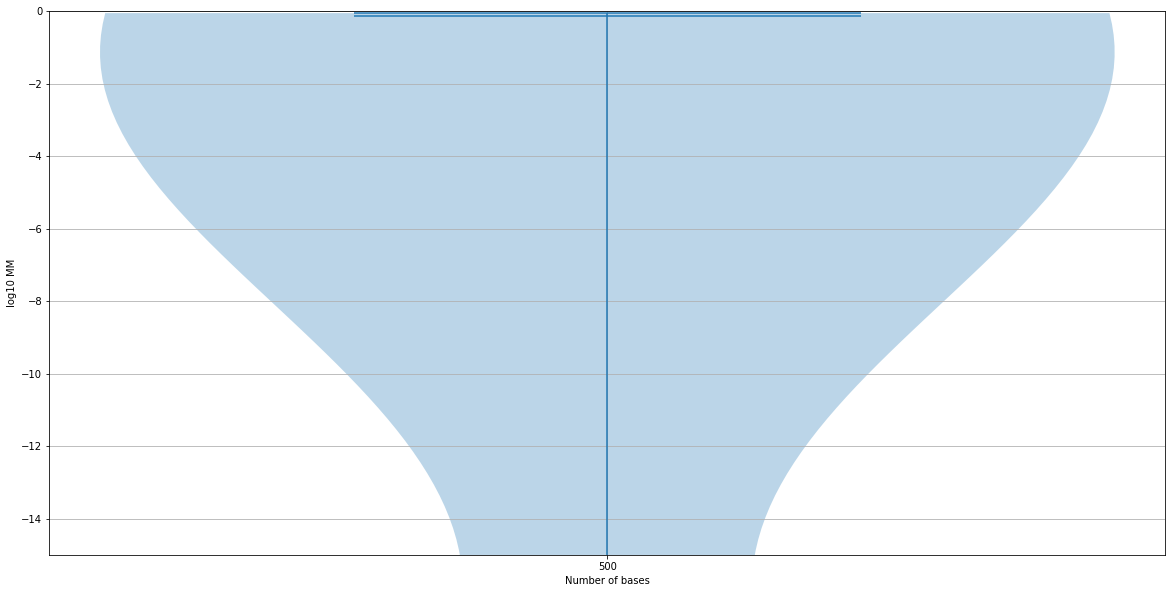

In [23]:
V = ipca.components_.T
Vh = ipca.components_
plt.figure(figsize=(20,10))

n=512
mismatches = []
mm_lowthre = 1e-30
ntests = np.arange(500, 512, 16)
for ntest in ntests:
    mismatch_n = []
    for hhh in ht:
        h_compressed = hhh @ V[:, :ntest] #np.dot(h_test , V)
        h_decomp = h_compressed @ Vh[:ntest] #np.dot(h_compressed , Vh)

        norm1 = np.sqrt(np.sum(np.abs(hhh) ** 2))
        norm2 = np.sqrt(np.sum(np.abs(h_decomp) ** 2))
        inner = np.sum(h_test.conj() * h_decomp).real
        mismatch = 1 - inner / (norm1 * norm2)
        if mismatch<mm_lowthre:
            mismatch_n.append(mm_lowthre)
        else:
            mismatch_n.append(mismatch)
    mismatches.append(mismatch_n)

mismatches = np.array(mismatches)
logMM = np.log10(mismatches)



_ = plt.violinplot(logMM.T, quantiles=np.tile([0.01,0.99], logMM.shape[0]).reshape(2, logMM.shape[0]))

plt.ylabel('log10 MM')
plt.xlabel('Number of bases')
plt.xticks(np.arange(0,len(ntests),4)+1, labels=ntests[::4])

plt.grid()
#plt.savefig(f'outputs/mm_vs_nbasis_{f_low}Hz{f_high}Hz{duration}s.png')
#plt.xscale('log')
plt.ylim(-15,0)

    
#plt.savefig('outputs/nb_sf2.png')
plt.show()

/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


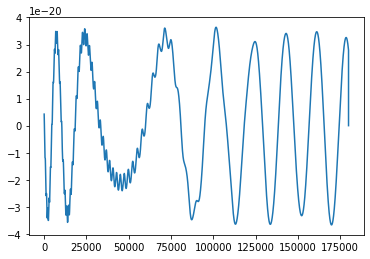

In [49]:
plt.plot(h_test[0])

# initial PCA

from 50 Hz


In [8]:
source_type = 'BNS'
detector_names = ['ET', 'CE', 'CEL']  #['H1']#['H1', 'L1', 'V1'] 
duration = 320
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'zero_noise' #'zero_noise' bilby_default
use_sealgw_detector = True

In [9]:
data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

data_generator_test = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
                                     f_high=f_high)

f = data_generator.frequency_array_masked

06:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
06:54 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using zero_noise PSDs to generate data.
Using zero_noise PSDs to generate data.


In [10]:
Nsample = 20000
Ntest = 100


injection_parameters_template = generate_BNS_injection_parameters(
        2*Nsample,
        a_max=0.8,
        d_min=10,
        d_max=2000,
        d_power=1,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)

injection_parameters_test = generate_BNS_injection_parameters(
        2*Ntest,
        a_max=0.8,
        d_min=10,
        d_max=2000,
        d_power=1,
        intrinsic_only = False,
        tc_min = -0.001,
        tc_max = 0.001)

injection_parameters_template['luminosity_distance'] = np.zeros(Nsample) + 1
injection_parameters_test['luminosity_distance'] = np.zeros(Ntest) + 1


In [11]:
def validate_svd(V, Vh, h_test, nbasis, mm_lowthre = 1e-30):
    
    mismatches = []
    for h in h_test:
        h_compressed = h @ V[:, :nbasis] #np.dot(h_test , V)
        h_reconstructed = h_compressed @ Vh[:nbasis] #np.dot(h_compressed , Vh)

        norm1 = np.sqrt(np.sum(np.abs(h) ** 2))
        norm2 = np.sqrt(np.sum(np.abs(h_reconstructed) ** 2))
        inner = np.sum(h.conj() * h_reconstructed).real
        mismatch = 1 - inner / (norm1 * norm2)
        if mismatch<mm_lowthre:
            mismatches.append(mm_lowthre)
        else:
            mismatches.append(mismatch)

    return mismatches

In [12]:
outdir = 'Vdet_output_501024512'

In [ ]:
n_components=512


data_generator.inject_signals(injection_parameters_template, 2*Nsample, Nneeded=Nsample)
data_generator_test.inject_signals(injection_parameters_test, 2*Ntest, Nneeded=Ntest)


for det in data_generator.ifos:
    detname = det.name
    h_train = np.array(data_generator.data['strains'][detname])
    h_test = np.array(data_generator_test.data['strains'][detname])

    U, s, Vh = randomized_svd(h_train, n_components)
    V = Vh.T.conj()
    
    with open(f"{outdir}/Vh_{detname}.pickle", 'wb') as f:
        pickle.dump(Vh, f)
    
    mm_list = []
    ntests = np.arange(256, 513, 16)
    for nbasis_test in ntests:
        mm_list.append(validate_svd(V, Vh, h_test, nbasis_test))
    
    
    logMM = np.log10(mm_list)
    plt.figure(figsize=(20,10))
    _ = plt.violinplot(logMM.T, quantiles=np.tile([0.01,0.99], logMM.shape[0]).reshape(2, logMM.shape[0]))
    
    plt.title(f'SVD error for {detname}')
    plt.ylabel('log10 MM')
    plt.xlabel('Number of bases')
    plt.xticks(np.arange(0,len(ntests),4)+1, labels=ntests[::4])

    plt.grid()
    #plt.savefig(f'outputs/mm_vs_nbasis_{f_low}Hz{f_high}Hz{duration}s.png')
    #plt.xscale('log')
    plt.ylim(-15,0)


    plt.savefig(f'{outdir}/nb_{detname}.png')
    plt.show()

06:55 bilby WARNING : The injected signal has a duration in-band of 838.1s, but the data for detector ET1 has a duration of 320s


Injecting 0-th signal, 0.0% done


06:55 bilby WARNING : The injected signal has a duration in-band of 838.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 838.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 838.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 838.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.6s, but the data for detector ET1 has a duration of 320s


Injecting 1-th signal, 0.0% done


06:55 bilby WARNING : The injected signal has a duration in-band of 733.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.3s, but the data for detector ET1 has a duration of 320s


Injecting 2-th signal, 0.01% done


06:55 bilby WARNING : The injected signal has a duration in-band of 569.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 501.5s, but the data for detector ET1 has a duration of 320s


Injecting 3-th signal, 0.01% done


06:55 bilby WARNING : The injected signal has a duration in-band of 501.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 501.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 501.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 501.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 397.1s, but the data for detector ET1 has a duration of 320s


Injecting 4-th signal, 0.01% done


06:55 bilby WARNING : The injected signal has a duration in-band of 397.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 397.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 397.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 397.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 412.7s, but the data for detector ET1 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 412.7s, but the data for detector ET2 has a duration of 320s


Injecting 5-th signal, 0.01% done


06:55 bilby WARNING : The injected signal has a duration in-band of 412.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 412.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 412.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 734.6s, but the data for detector ET1 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 734.6s, but the data for detector ET2 has a duration of 320s


Injecting 6-th signal, 0.01% done


06:55 bilby WARNING : The injected signal has a duration in-band of 734.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 734.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 734.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 635.0s, but the data for detector ET1 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 635.0s, but the data for detector ET2 has a duration of 320s


Injecting 7-th signal, 0.02% done


06:55 bilby WARNING : The injected signal has a duration in-band of 635.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 635.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 635.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 783.2s, but the data for detector ET1 has a duration of 320s


Injecting 8-th signal, 0.02% done


06:55 bilby WARNING : The injected signal has a duration in-band of 783.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 783.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 783.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 783.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 493.8s, but the data for detector ET1 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 493.8s, but the data for detector ET2 has a duration of 320s


Injecting 9-th signal, 0.02% done


06:55 bilby WARNING : The injected signal has a duration in-band of 493.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 493.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 493.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.4s, but the data for detector ET1 has a duration of 320s


Injecting 10-th signal, 0.03% done


06:55 bilby WARNING : The injected signal has a duration in-band of 514.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 424.9s, but the data for detector ET1 has a duration of 320s


Injecting 11-th signal, 0.03% done


06:55 bilby WARNING : The injected signal has a duration in-band of 424.9s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 424.9s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 424.9s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 424.9s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 373.9s, but the data for detector ET1 has a duration of 320s


Injecting 12-th signal, 0.03% done


06:55 bilby WARNING : The injected signal has a duration in-band of 373.9s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 373.9s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 373.9s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 373.9s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 902.6s, but the data for detector ET1 has a duration of 320s


Injecting 13-th signal, 0.03% done


06:55 bilby WARNING : The injected signal has a duration in-band of 902.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 902.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 902.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 902.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 713.6s, but the data for detector ET1 has a duration of 320s


Injecting 14-th signal, 0.04% done


06:55 bilby WARNING : The injected signal has a duration in-band of 713.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 713.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 713.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 713.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1124.3s, but the data for detector ET1 has a duration of 320s


Injecting 15-th signal, 0.04% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1124.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1124.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1124.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1124.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1138.8s, but the data for detector ET1 has a duration of 320s


Injecting 16-th signal, 0.04% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1138.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1138.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1138.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1138.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 745.0s, but the data for detector ET1 has a duration of 320s


Injecting 17-th signal, 0.04% done


06:55 bilby WARNING : The injected signal has a duration in-band of 745.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 745.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 745.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 745.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET1 has a duration of 320s


Injecting 18-th signal, 0.04% done


06:55 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 754.5s, but the data for detector ET1 has a duration of 320s


Injecting 19-th signal, 0.05% done


06:55 bilby WARNING : The injected signal has a duration in-band of 754.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 754.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 754.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 754.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 882.7s, but the data for detector ET1 has a duration of 320s


Injecting 20-th signal, 0.05% done


06:55 bilby WARNING : The injected signal has a duration in-band of 882.7s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 882.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 882.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 882.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET1 has a duration of 320s


Injecting 21-th signal, 0.05% done


06:55 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 851.3s, but the data for detector ET1 has a duration of 320s


Injecting 22-th signal, 0.06% done


06:55 bilby WARNING : The injected signal has a duration in-band of 851.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 851.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 851.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 851.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 652.1s, but the data for detector ET1 has a duration of 320s


Injecting 23-th signal, 0.06% done


06:55 bilby WARNING : The injected signal has a duration in-band of 652.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 652.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 652.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 652.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 788.8s, but the data for detector ET1 has a duration of 320s


Injecting 24-th signal, 0.06% done


06:55 bilby WARNING : The injected signal has a duration in-band of 788.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 788.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 788.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 788.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1245.3s, but the data for detector ET1 has a duration of 320s


Injecting 25-th signal, 0.06% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1245.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1245.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1245.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1245.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1231.7s, but the data for detector ET1 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1231.7s, but the data for detector ET2 has a duration of 320s


Injecting 26-th signal, 0.07% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1231.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1231.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1231.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1140.3s, but the data for detector ET1 has a duration of 320s


Injecting 27-th signal, 0.07% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1140.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1140.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1140.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1140.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET1 has a duration of 320s


Injecting 28-th signal, 0.07% done


06:55 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1312.7s, but the data for detector ET1 has a duration of 320s


Injecting 29-th signal, 0.07% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1312.7s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1312.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1312.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1312.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 729.5s, but the data for detector ET1 has a duration of 320s


Injecting 30-th signal, 0.07% done


06:55 bilby WARNING : The injected signal has a duration in-band of 729.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 729.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 729.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 729.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 587.2s, but the data for detector ET1 has a duration of 320s


Injecting 31-th signal, 0.08% done


06:55 bilby WARNING : The injected signal has a duration in-band of 587.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 587.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 587.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 587.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 371.0s, but the data for detector ET1 has a duration of 320s


Injecting 32-th signal, 0.08% done


06:55 bilby WARNING : The injected signal has a duration in-band of 371.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 371.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 371.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 371.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 751.1s, but the data for detector ET1 has a duration of 320s


Injecting 33-th signal, 0.08% done


06:55 bilby WARNING : The injected signal has a duration in-band of 751.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 751.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 751.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 751.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET1 has a duration of 320s


Injecting 34-th signal, 0.09% done


06:55 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 433.5s, but the data for detector ET1 has a duration of 320s


Injecting 35-th signal, 0.09% done


06:55 bilby WARNING : The injected signal has a duration in-band of 433.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 433.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 433.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 433.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1053.2s, but the data for detector ET1 has a duration of 320s


Injecting 36-th signal, 0.09% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1053.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1053.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1053.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1053.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 871.9s, but the data for detector ET1 has a duration of 320s


Injecting 37-th signal, 0.09% done


06:55 bilby WARNING : The injected signal has a duration in-band of 871.9s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 871.9s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 871.9s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 871.9s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 753.9s, but the data for detector ET1 has a duration of 320s


Injecting 38-th signal, 0.1% done


06:55 bilby WARNING : The injected signal has a duration in-band of 753.9s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 753.9s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 753.9s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 753.9s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 667.4s, but the data for detector ET1 has a duration of 320s


Injecting 39-th signal, 0.1% done


06:55 bilby WARNING : The injected signal has a duration in-band of 667.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 667.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 667.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 667.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 816.6s, but the data for detector ET1 has a duration of 320s


Injecting 40-th signal, 0.1% done


06:55 bilby WARNING : The injected signal has a duration in-band of 816.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 816.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 816.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 816.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET1 has a duration of 320s


Injecting 41-th signal, 0.1% done


06:55 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 762.6s, but the data for detector ET1 has a duration of 320s


Injecting 42-th signal, 0.1% done


06:55 bilby WARNING : The injected signal has a duration in-band of 762.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 762.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 762.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 762.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 698.8s, but the data for detector ET1 has a duration of 320s


Injecting 43-th signal, 0.11% done


06:55 bilby WARNING : The injected signal has a duration in-band of 698.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 698.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 698.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 698.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET1 has a duration of 320s


Injecting 44-th signal, 0.11% done


06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 363.5s, but the data for detector ET1 has a duration of 320s


Injecting 45-th signal, 0.11% done


06:55 bilby WARNING : The injected signal has a duration in-band of 363.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 363.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 363.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 363.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET1 has a duration of 320s


Injecting 46-th signal, 0.12% done


06:55 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET1 has a duration of 320s


Injecting 47-th signal, 0.12% done


06:55 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET1 has a duration of 320s


Injecting 48-th signal, 0.12% done


06:55 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 950.1s, but the data for detector ET1 has a duration of 320s


Injecting 49-th signal, 0.12% done


06:55 bilby WARNING : The injected signal has a duration in-band of 950.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 950.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 950.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 950.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.6s, but the data for detector ET1 has a duration of 320s


Injecting 50-th signal, 0.12% done


06:55 bilby WARNING : The injected signal has a duration in-band of 569.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 569.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET1 has a duration of 320s


Injecting 51-th signal, 0.13% done


06:55 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 808.6s, but the data for detector ET1 has a duration of 320s


Injecting 52-th signal, 0.13% done


06:55 bilby WARNING : The injected signal has a duration in-band of 808.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 808.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 808.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 808.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 407.3s, but the data for detector ET1 has a duration of 320s


Injecting 53-th signal, 0.13% done


06:55 bilby WARNING : The injected signal has a duration in-band of 407.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 407.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 407.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 407.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 575.7s, but the data for detector ET1 has a duration of 320s


Injecting 54-th signal, 0.14% done


06:55 bilby WARNING : The injected signal has a duration in-band of 575.7s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 575.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 575.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 575.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 444.3s, but the data for detector ET1 has a duration of 320s


Injecting 55-th signal, 0.14% done


06:55 bilby WARNING : The injected signal has a duration in-band of 444.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 444.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 444.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 444.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET1 has a duration of 320s


Injecting 56-th signal, 0.14% done


06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 482.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 446.0s, but the data for detector ET1 has a duration of 320s


Injecting 57-th signal, 0.14% done


06:55 bilby WARNING : The injected signal has a duration in-band of 446.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 446.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 446.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 446.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 480.2s, but the data for detector ET1 has a duration of 320s


Injecting 58-th signal, 0.14% done


06:55 bilby WARNING : The injected signal has a duration in-band of 480.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 480.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 480.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 480.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET1 has a duration of 320s


Injecting 59-th signal, 0.15% done


06:55 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 931.1s, but the data for detector ET1 has a duration of 320s


Injecting 60-th signal, 0.15% done


06:55 bilby WARNING : The injected signal has a duration in-band of 931.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 931.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 931.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 931.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 686.8s, but the data for detector ET1 has a duration of 320s


Injecting 61-th signal, 0.15% done


06:55 bilby WARNING : The injected signal has a duration in-band of 686.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 686.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 686.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 686.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET1 has a duration of 320s


Injecting 62-th signal, 0.15% done


06:55 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 615.8s, but the data for detector ET1 has a duration of 320s


Injecting 63-th signal, 0.16% done


06:55 bilby WARNING : The injected signal has a duration in-band of 615.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 615.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 615.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 615.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET1 has a duration of 320s


Injecting 64-th signal, 0.16% done


06:55 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET1 has a duration of 320s


Injecting 65-th signal, 0.16% done


06:55 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 525.7s, but the data for detector ET1 has a duration of 320s


Injecting 66-th signal, 0.17% done


06:55 bilby WARNING : The injected signal has a duration in-band of 525.7s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 525.7s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 525.7s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 525.7s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET1 has a duration of 320s


Injecting 67-th signal, 0.17% done


06:55 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 485.8s, but the data for detector ET1 has a duration of 320s


Injecting 68-th signal, 0.17% done


06:55 bilby WARNING : The injected signal has a duration in-band of 485.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 485.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 485.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 485.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET1 has a duration of 320s


Injecting 69-th signal, 0.17% done


06:55 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1099.0s, but the data for detector ET1 has a duration of 320s


Injecting 70-th signal, 0.17% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1099.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1099.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1099.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1099.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 866.3s, but the data for detector ET1 has a duration of 320s


Injecting 71-th signal, 0.18% done


06:55 bilby WARNING : The injected signal has a duration in-band of 866.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 866.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 866.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 866.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 360.8s, but the data for detector ET1 has a duration of 320s


Injecting 72-th signal, 0.18% done


06:55 bilby WARNING : The injected signal has a duration in-band of 360.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 360.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 360.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 360.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.8s, but the data for detector ET1 has a duration of 320s


Injecting 73-th signal, 0.18% done


06:55 bilby WARNING : The injected signal has a duration in-band of 548.8s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.8s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.8s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 548.8s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 551.2s, but the data for detector ET1 has a duration of 320s


Injecting 74-th signal, 0.18% done


06:55 bilby WARNING : The injected signal has a duration in-band of 551.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 551.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 551.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 551.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.3s, but the data for detector ET1 has a duration of 320s


Injecting 75-th signal, 0.19% done


06:55 bilby WARNING : The injected signal has a duration in-band of 514.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 514.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 872.9s, but the data for detector ET1 has a duration of 320s


Injecting 76-th signal, 0.19% done


06:55 bilby WARNING : The injected signal has a duration in-band of 872.9s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 872.9s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 872.9s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 872.9s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 334.5s, but the data for detector ET1 has a duration of 320s


Injecting 77-th signal, 0.19% done


06:55 bilby WARNING : The injected signal has a duration in-band of 334.5s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 334.5s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 334.5s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 334.5s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 449.2s, but the data for detector ET1 has a duration of 320s


Injecting 78-th signal, 0.2% done


06:55 bilby WARNING : The injected signal has a duration in-band of 449.2s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 449.2s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 449.2s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 449.2s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET1 has a duration of 320s


Injecting 79-th signal, 0.2% done


06:55 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.1s, but the data for detector ET1 has a duration of 320s


Injecting 80-th signal, 0.2% done


06:55 bilby WARNING : The injected signal has a duration in-band of 518.1s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.1s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.1s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 518.1s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 828.3s, but the data for detector ET1 has a duration of 320s


Injecting 81-th signal, 0.2% done


06:55 bilby WARNING : The injected signal has a duration in-band of 828.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 828.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 828.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 828.3s, but the data for detector CEL has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1076.3s, but the data for detector ET1 has a duration of 320s


Injecting 82-th signal, 0.2% done


06:55 bilby WARNING : The injected signal has a duration in-band of 1076.3s, but the data for detector ET2 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1076.3s, but the data for detector ET3 has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1076.3s, but the data for detector CE has a duration of 320s
06:55 bilby WARNING : The injected signal has a duration in-band of 1076.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET1 has a duration of 320s


Injecting 83-th signal, 0.21% done


06:56 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 481.7s, but the data for detector ET1 has a duration of 320s


Injecting 84-th signal, 0.21% done


06:56 bilby WARNING : The injected signal has a duration in-band of 481.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 481.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 481.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 481.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.8s, but the data for detector ET1 has a duration of 320s


Injecting 85-th signal, 0.21% done


06:56 bilby WARNING : The injected signal has a duration in-band of 376.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.4s, but the data for detector ET1 has a duration of 320s


Injecting 86-th signal, 0.21% done


06:56 bilby WARNING : The injected signal has a duration in-band of 771.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1133.4s, but the data for detector ET1 has a duration of 320s


Injecting 87-th signal, 0.22% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1133.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1133.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1133.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1133.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 711.7s, but the data for detector ET1 has a duration of 320s


Injecting 88-th signal, 0.22% done


06:56 bilby WARNING : The injected signal has a duration in-band of 711.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 711.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 711.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 711.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.8s, but the data for detector ET1 has a duration of 320s


Injecting 89-th signal, 0.22% done


06:56 bilby WARNING : The injected signal has a duration in-band of 369.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.5s, but the data for detector ET1 has a duration of 320s


Injecting 90-th signal, 0.23% done


06:56 bilby WARNING : The injected signal has a duration in-band of 371.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.1s, but the data for detector ET1 has a duration of 320s


Injecting 91-th signal, 0.23% done


06:56 bilby WARNING : The injected signal has a duration in-band of 616.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 368.0s, but the data for detector ET1 has a duration of 320s


Injecting 92-th signal, 0.23% done


06:56 bilby WARNING : The injected signal has a duration in-band of 368.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 368.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 368.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 368.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1159.6s, but the data for detector ET1 has a duration of 320s


Injecting 93-th signal, 0.23% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1159.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1159.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1159.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1159.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1423.9s, but the data for detector ET1 has a duration of 320s


Injecting 94-th signal, 0.23% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1423.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1423.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1423.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1423.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 550.9s, but the data for detector ET1 has a duration of 320s


Injecting 95-th signal, 0.24% done


06:56 bilby WARNING : The injected signal has a duration in-band of 550.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 550.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 550.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 550.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 802.2s, but the data for detector ET1 has a duration of 320s


Injecting 96-th signal, 0.24% done


06:56 bilby WARNING : The injected signal has a duration in-band of 802.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 802.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 802.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 802.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 524.0s, but the data for detector ET1 has a duration of 320s


Injecting 97-th signal, 0.24% done


06:56 bilby WARNING : The injected signal has a duration in-band of 524.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 524.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 524.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 524.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1083.0s, but the data for detector ET1 has a duration of 320s


Injecting 98-th signal, 0.24% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1083.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1083.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1083.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1083.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET1 has a duration of 320s


Injecting 99-th signal, 0.25% done


06:56 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.1s, but the data for detector ET1 has a duration of 320s


Injecting 100-th signal, 0.25% done


06:56 bilby WARNING : The injected signal has a duration in-band of 522.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.9s, but the data for detector ET1 has a duration of 320s


Injecting 101-th signal, 0.25% done


06:56 bilby WARNING : The injected signal has a duration in-band of 455.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 696.2s, but the data for detector ET1 has a duration of 320s


Injecting 102-th signal, 0.26% done


06:56 bilby WARNING : The injected signal has a duration in-band of 696.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 696.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 696.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 696.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET1 has a duration of 320s


Injecting 103-th signal, 0.26% done


06:56 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 906.4s, but the data for detector ET1 has a duration of 320s


Injecting 104-th signal, 0.26% done


06:56 bilby WARNING : The injected signal has a duration in-band of 906.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 906.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 906.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 906.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1067.2s, but the data for detector ET1 has a duration of 320s


Injecting 105-th signal, 0.26% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1067.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1067.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1067.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1067.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET1 has a duration of 320s


Injecting 106-th signal, 0.27% done


06:56 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 751.6s, but the data for detector ET1 has a duration of 320s


Injecting 107-th signal, 0.27% done


06:56 bilby WARNING : The injected signal has a duration in-band of 751.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 751.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 751.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 751.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 809.3s, but the data for detector ET1 has a duration of 320s


Injecting 108-th signal, 0.27% done


06:56 bilby WARNING : The injected signal has a duration in-band of 809.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 809.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 809.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 809.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 526.5s, but the data for detector ET1 has a duration of 320s


Injecting 109-th signal, 0.27% done


06:56 bilby WARNING : The injected signal has a duration in-band of 526.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 526.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 526.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 526.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.1s, but the data for detector ET1 has a duration of 320s


Injecting 110-th signal, 0.28% done


06:56 bilby WARNING : The injected signal has a duration in-band of 427.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 419.7s, but the data for detector ET1 has a duration of 320s


Injecting 111-th signal, 0.28% done


06:56 bilby WARNING : The injected signal has a duration in-band of 419.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 419.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 419.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 419.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET1 has a duration of 320s


Injecting 112-th signal, 0.28% done


06:56 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 511.2s, but the data for detector ET1 has a duration of 320s


Injecting 113-th signal, 0.28% done


06:56 bilby WARNING : The injected signal has a duration in-band of 511.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 511.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 511.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 511.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 435.7s, but the data for detector ET1 has a duration of 320s


Injecting 114-th signal, 0.28% done


06:56 bilby WARNING : The injected signal has a duration in-band of 435.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 435.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 435.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 435.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 341.4s, but the data for detector ET1 has a duration of 320s


Injecting 115-th signal, 0.29% done


06:56 bilby WARNING : The injected signal has a duration in-band of 341.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 341.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 341.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 341.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 391.6s, but the data for detector ET1 has a duration of 320s


Injecting 116-th signal, 0.29% done


06:56 bilby WARNING : The injected signal has a duration in-band of 391.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 391.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 391.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 391.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET1 has a duration of 320s


Injecting 117-th signal, 0.29% done


06:56 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 428.1s, but the data for detector ET1 has a duration of 320s


Injecting 118-th signal, 0.29% done


06:56 bilby WARNING : The injected signal has a duration in-band of 428.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 428.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 428.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 428.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 907.7s, but the data for detector ET1 has a duration of 320s


Injecting 119-th signal, 0.3% done


06:56 bilby WARNING : The injected signal has a duration in-band of 907.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 907.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 907.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 907.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1004.5s, but the data for detector ET1 has a duration of 320s


Injecting 120-th signal, 0.3% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1004.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1004.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1004.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1004.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 342.6s, but the data for detector ET1 has a duration of 320s


Injecting 121-th signal, 0.3% done


06:56 bilby WARNING : The injected signal has a duration in-band of 342.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 342.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 342.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 342.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 595.5s, but the data for detector ET1 has a duration of 320s


Injecting 122-th signal, 0.3% done


06:56 bilby WARNING : The injected signal has a duration in-band of 595.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 595.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 595.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 595.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.4s, but the data for detector ET1 has a duration of 320s


Injecting 123-th signal, 0.31% done


06:56 bilby WARNING : The injected signal has a duration in-band of 448.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 370.9s, but the data for detector ET1 has a duration of 320s


Injecting 124-th signal, 0.31% done


06:56 bilby WARNING : The injected signal has a duration in-band of 370.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 370.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 370.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 370.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 805.4s, but the data for detector ET1 has a duration of 320s


Injecting 125-th signal, 0.31% done


06:56 bilby WARNING : The injected signal has a duration in-band of 805.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 805.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 805.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 805.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 571.5s, but the data for detector ET1 has a duration of 320s


Injecting 126-th signal, 0.32% done


06:56 bilby WARNING : The injected signal has a duration in-band of 571.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 571.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 571.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 571.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 459.8s, but the data for detector ET1 has a duration of 320s


Injecting 127-th signal, 0.32% done


06:56 bilby WARNING : The injected signal has a duration in-band of 459.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 459.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 459.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 459.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.0s, but the data for detector ET1 has a duration of 320s


Injecting 128-th signal, 0.32% done


06:56 bilby WARNING : The injected signal has a duration in-band of 544.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 372.5s, but the data for detector ET1 has a duration of 320s


Injecting 129-th signal, 0.32% done


06:56 bilby WARNING : The injected signal has a duration in-band of 372.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 372.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 372.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 372.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET1 has a duration of 320s


Injecting 130-th signal, 0.33% done


06:56 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET1 has a duration of 320s


Injecting 131-th signal, 0.33% done


06:56 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET1 has a duration of 320s


Injecting 132-th signal, 0.33% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 915.1s, but the data for detector ET1 has a duration of 320s


Injecting 133-th signal, 0.33% done


06:56 bilby WARNING : The injected signal has a duration in-band of 915.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 915.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 915.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 915.1s, but the data for detector CEL has a duration of 320s


Injecting 134-th signal, 0.34% done


06:56 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET1 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 902.7s, but the data for detector ET1 has a duration of 320s


Injecting 135-th signal, 0.34% done


06:56 bilby WARNING : The injected signal has a duration in-band of 902.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 902.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 902.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 902.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.7s, but the data for detector ET1 has a duration of 320s


Injecting 136-th signal, 0.34% done


06:56 bilby WARNING : The injected signal has a duration in-band of 448.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 448.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 641.7s, but the data for detector ET1 has a duration of 320s


Injecting 137-th signal, 0.34% done


06:56 bilby WARNING : The injected signal has a duration in-band of 641.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 641.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 641.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 641.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.8s, but the data for detector ET1 has a duration of 320s


Injecting 138-th signal, 0.34% done


06:56 bilby WARNING : The injected signal has a duration in-band of 522.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 522.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET1 has a duration of 320s


Injecting 139-th signal, 0.35% done


06:56 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 866.4s, but the data for detector ET1 has a duration of 320s


Injecting 140-th signal, 0.35% done


06:56 bilby WARNING : The injected signal has a duration in-band of 866.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 866.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 866.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 866.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 426.1s, but the data for detector ET1 has a duration of 320s


Injecting 141-th signal, 0.35% done


06:56 bilby WARNING : The injected signal has a duration in-band of 426.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 426.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 426.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 426.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 717.0s, but the data for detector ET1 has a duration of 320s


Injecting 142-th signal, 0.35% done


06:56 bilby WARNING : The injected signal has a duration in-band of 717.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 717.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 717.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 717.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1241.3s, but the data for detector ET1 has a duration of 320s


Injecting 143-th signal, 0.36% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1241.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1241.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1241.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1241.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 581.9s, but the data for detector ET1 has a duration of 320s


Injecting 144-th signal, 0.36% done


06:56 bilby WARNING : The injected signal has a duration in-band of 581.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 581.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 581.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 581.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET1 has a duration of 320s


Injecting 145-th signal, 0.36% done


06:56 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 657.6s, but the data for detector ET1 has a duration of 320s


Injecting 146-th signal, 0.36% done


06:56 bilby WARNING : The injected signal has a duration in-band of 657.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 657.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 657.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 657.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 865.3s, but the data for detector ET1 has a duration of 320s


Injecting 147-th signal, 0.37% done


06:56 bilby WARNING : The injected signal has a duration in-band of 865.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 865.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 865.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 865.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 643.0s, but the data for detector ET1 has a duration of 320s


Injecting 148-th signal, 0.37% done


06:56 bilby WARNING : The injected signal has a duration in-band of 643.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 643.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 643.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 643.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET1 has a duration of 320s


Injecting 149-th signal, 0.37% done


06:56 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET1 has a duration of 320s


Injecting 150-th signal, 0.38% done


06:56 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET1 has a duration of 320s


Injecting 151-th signal, 0.38% done


06:56 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET1 has a duration of 320s


Injecting 152-th signal, 0.38% done


06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 445.5s, but the data for detector ET1 has a duration of 320s


Injecting 153-th signal, 0.38% done


06:56 bilby WARNING : The injected signal has a duration in-band of 445.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 445.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 445.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 445.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 537.8s, but the data for detector ET1 has a duration of 320s


Injecting 154-th signal, 0.39% done


06:56 bilby WARNING : The injected signal has a duration in-band of 537.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 537.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 537.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 537.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1274.4s, but the data for detector ET1 has a duration of 320s


Injecting 155-th signal, 0.39% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1274.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1274.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1274.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1274.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.2s, but the data for detector ET1 has a duration of 320s


Injecting 156-th signal, 0.39% done


06:56 bilby WARNING : The injected signal has a duration in-band of 376.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 376.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1084.9s, but the data for detector ET1 has a duration of 320s


Injecting 157-th signal, 0.39% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1084.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1084.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1084.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1084.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 582.4s, but the data for detector ET1 has a duration of 320s


Injecting 158-th signal, 0.4% done


06:56 bilby WARNING : The injected signal has a duration in-band of 582.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 582.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 582.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 582.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1328.5s, but the data for detector ET1 has a duration of 320s


Injecting 159-th signal, 0.4% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1328.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1328.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1328.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1328.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 864.8s, but the data for detector ET1 has a duration of 320s


Injecting 160-th signal, 0.4% done


06:56 bilby WARNING : The injected signal has a duration in-band of 864.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 864.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 864.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 864.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 632.8s, but the data for detector ET1 has a duration of 320s


Injecting 161-th signal, 0.4% done


06:56 bilby WARNING : The injected signal has a duration in-band of 632.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 632.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 632.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 632.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 670.1s, but the data for detector ET1 has a duration of 320s


Injecting 162-th signal, 0.41% done


06:56 bilby WARNING : The injected signal has a duration in-band of 670.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 670.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 670.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 670.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 541.9s, but the data for detector ET1 has a duration of 320s


Injecting 163-th signal, 0.41% done


06:56 bilby WARNING : The injected signal has a duration in-band of 541.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 541.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 541.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 541.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1197.5s, but the data for detector ET1 has a duration of 320s


Injecting 164-th signal, 0.41% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1197.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1197.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1197.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1197.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 812.3s, but the data for detector ET1 has a duration of 320s


Injecting 165-th signal, 0.41% done


06:56 bilby WARNING : The injected signal has a duration in-band of 812.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 812.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 812.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 812.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 973.9s, but the data for detector ET1 has a duration of 320s


Injecting 166-th signal, 0.41% done


06:56 bilby WARNING : The injected signal has a duration in-band of 973.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 973.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 973.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 973.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.8s, but the data for detector ET1 has a duration of 320s


Injecting 167-th signal, 0.42% done


06:56 bilby WARNING : The injected signal has a duration in-band of 427.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 427.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 646.4s, but the data for detector ET1 has a duration of 320s


Injecting 168-th signal, 0.42% done


06:56 bilby WARNING : The injected signal has a duration in-band of 646.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 646.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 646.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 646.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.7s, but the data for detector ET1 has a duration of 320s


Injecting 169-th signal, 0.42% done


06:56 bilby WARNING : The injected signal has a duration in-band of 654.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 777.1s, but the data for detector ET1 has a duration of 320s


Injecting 170-th signal, 0.42% done


06:56 bilby WARNING : The injected signal has a duration in-band of 777.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 777.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 777.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 777.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 531.8s, but the data for detector ET1 has a duration of 320s


Injecting 171-th signal, 0.43% done


06:56 bilby WARNING : The injected signal has a duration in-band of 531.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 531.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 531.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 531.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 532.3s, but the data for detector ET1 has a duration of 320s


Injecting 172-th signal, 0.43% done


06:56 bilby WARNING : The injected signal has a duration in-band of 532.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 532.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 532.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 532.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET1 has a duration of 320s


Injecting 173-th signal, 0.43% done


06:56 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 449.4s, but the data for detector ET1 has a duration of 320s


Injecting 174-th signal, 0.43% done


06:56 bilby WARNING : The injected signal has a duration in-band of 449.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 449.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 449.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 449.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET1 has a duration of 320s


Injecting 175-th signal, 0.44% done


06:56 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1030.5s, but the data for detector ET1 has a duration of 320s


Injecting 176-th signal, 0.44% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1030.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1030.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1030.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1030.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.7s, but the data for detector ET1 has a duration of 320s


Injecting 177-th signal, 0.44% done


06:56 bilby WARNING : The injected signal has a duration in-band of 406.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 406.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.6s, but the data for detector ET1 has a duration of 320s


Injecting 178-th signal, 0.45% done


06:56 bilby WARNING : The injected signal has a duration in-band of 654.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 654.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 709.8s, but the data for detector ET1 has a duration of 320s


Injecting 179-th signal, 0.45% done


06:56 bilby WARNING : The injected signal has a duration in-band of 709.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 709.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 709.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 709.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET1 has a duration of 320s


Injecting 180-th signal, 0.45% done


06:56 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 702.5s, but the data for detector ET1 has a duration of 320s


Injecting 181-th signal, 0.45% done


06:56 bilby WARNING : The injected signal has a duration in-band of 702.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 702.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 702.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 702.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 620.2s, but the data for detector ET1 has a duration of 320s


Injecting 182-th signal, 0.46% done


06:56 bilby WARNING : The injected signal has a duration in-band of 620.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 620.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 620.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 620.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.6s, but the data for detector ET1 has a duration of 320s


Injecting 183-th signal, 0.46% done


06:56 bilby WARNING : The injected signal has a duration in-band of 773.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 636.6s, but the data for detector ET1 has a duration of 320s


Injecting 184-th signal, 0.46% done


06:56 bilby WARNING : The injected signal has a duration in-band of 636.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 636.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 636.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 636.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1055.0s, but the data for detector ET1 has a duration of 320s


Injecting 185-th signal, 0.46% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1055.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1055.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1055.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1055.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 874.6s, but the data for detector ET1 has a duration of 320s


Injecting 186-th signal, 0.47% done


06:56 bilby WARNING : The injected signal has a duration in-band of 874.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 874.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 874.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 874.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.1s, but the data for detector ET1 has a duration of 320s


Injecting 187-th signal, 0.47% done


06:56 bilby WARNING : The injected signal has a duration in-band of 520.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.1s, but the data for detector CEL has a duration of 320s


Injecting 188-th signal, 0.47% done


06:56 bilby WARNING : The injected signal has a duration in-band of 951.0s, but the data for detector ET1 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 951.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 951.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 951.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 951.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1338.1s, but the data for detector ET1 has a duration of 320s


Injecting 189-th signal, 0.47% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1338.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1338.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1338.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1338.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 878.9s, but the data for detector ET1 has a duration of 320s


Injecting 190-th signal, 0.47% done


06:56 bilby WARNING : The injected signal has a duration in-band of 878.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 878.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 878.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 878.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET1 has a duration of 320s


Injecting 191-th signal, 0.48% done


06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 660.2s, but the data for detector ET1 has a duration of 320s


Injecting 192-th signal, 0.48% done


06:56 bilby WARNING : The injected signal has a duration in-band of 660.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 660.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 660.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 660.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 820.7s, but the data for detector ET1 has a duration of 320s


Injecting 193-th signal, 0.48% done


06:56 bilby WARNING : The injected signal has a duration in-band of 820.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 820.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 820.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 820.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 504.9s, but the data for detector ET1 has a duration of 320s


Injecting 194-th signal, 0.48% done


06:56 bilby WARNING : The injected signal has a duration in-band of 504.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 504.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 504.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 504.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 846.5s, but the data for detector ET1 has a duration of 320s


Injecting 195-th signal, 0.49% done


06:56 bilby WARNING : The injected signal has a duration in-band of 846.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 846.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 846.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 846.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 418.9s, but the data for detector ET1 has a duration of 320s


Injecting 196-th signal, 0.49% done


06:56 bilby WARNING : The injected signal has a duration in-band of 418.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 418.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 418.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 418.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 430.7s, but the data for detector ET1 has a duration of 320s


Injecting 197-th signal, 0.49% done


06:56 bilby WARNING : The injected signal has a duration in-band of 430.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 430.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 430.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 430.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 798.7s, but the data for detector ET1 has a duration of 320s


Injecting 198-th signal, 0.49% done


06:56 bilby WARNING : The injected signal has a duration in-band of 798.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 798.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 798.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 798.7s, but the data for detector CEL has a duration of 320s


Injecting 199-th signal, 0.5% done


06:56 bilby WARNING : The injected signal has a duration in-band of 771.1s, but the data for detector ET1 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 771.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET1 has a duration of 320s


Injecting 200-th signal, 0.5% done


06:56 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 795.4s, but the data for detector ET1 has a duration of 320s


Injecting 201-th signal, 0.5% done


06:56 bilby WARNING : The injected signal has a duration in-band of 795.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 795.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 795.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 795.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 438.9s, but the data for detector ET1 has a duration of 320s


Injecting 202-th signal, 0.51% done


06:56 bilby WARNING : The injected signal has a duration in-band of 438.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 438.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 438.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 438.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 477.1s, but the data for detector ET1 has a duration of 320s


Injecting 203-th signal, 0.51% done


06:56 bilby WARNING : The injected signal has a duration in-band of 477.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 477.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 477.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 477.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 573.2s, but the data for detector ET1 has a duration of 320s


Injecting 204-th signal, 0.51% done


06:56 bilby WARNING : The injected signal has a duration in-band of 573.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 573.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 573.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 573.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 619.7s, but the data for detector ET1 has a duration of 320s


Injecting 205-th signal, 0.51% done


06:56 bilby WARNING : The injected signal has a duration in-band of 619.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 619.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 619.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 619.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 515.5s, but the data for detector ET1 has a duration of 320s


Injecting 206-th signal, 0.52% done


06:56 bilby WARNING : The injected signal has a duration in-band of 515.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 515.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 515.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 515.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.7s, but the data for detector ET1 has a duration of 320s


Injecting 207-th signal, 0.52% done


06:56 bilby WARNING : The injected signal has a duration in-band of 773.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 773.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET1 has a duration of 320s


Injecting 208-th signal, 0.52% done


06:56 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1077.6s, but the data for detector ET1 has a duration of 320s


Injecting 209-th signal, 0.52% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1077.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1077.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1077.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1077.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET1 has a duration of 320s


Injecting 210-th signal, 0.53% done


06:56 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 639.0s, but the data for detector ET1 has a duration of 320s


Injecting 211-th signal, 0.53% done


06:56 bilby WARNING : The injected signal has a duration in-band of 639.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 639.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 639.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 639.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 394.9s, but the data for detector ET1 has a duration of 320s


Injecting 212-th signal, 0.53% done


06:56 bilby WARNING : The injected signal has a duration in-band of 394.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 394.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 394.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 394.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 592.6s, but the data for detector ET1 has a duration of 320s


Injecting 213-th signal, 0.53% done


06:56 bilby WARNING : The injected signal has a duration in-band of 592.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 592.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 592.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 592.6s, but the data for detector CEL has a duration of 320s


Injecting 214-th signal, 0.54% done


06:56 bilby WARNING : The injected signal has a duration in-band of 447.1s, but the data for detector ET1 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET1 has a duration of 320s


Injecting 215-th signal, 0.54% done


06:56 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.2s, but the data for detector ET1 has a duration of 320s


Injecting 216-th signal, 0.54% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1194.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 630.3s, but the data for detector ET1 has a duration of 320s


Injecting 217-th signal, 0.54% done


06:56 bilby WARNING : The injected signal has a duration in-band of 630.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 630.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 630.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 630.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 687.4s, but the data for detector ET1 has a duration of 320s


Injecting 218-th signal, 0.55% done


06:56 bilby WARNING : The injected signal has a duration in-band of 687.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 687.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 687.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 687.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 839.6s, but the data for detector ET1 has a duration of 320s


Injecting 219-th signal, 0.55% done


06:56 bilby WARNING : The injected signal has a duration in-band of 839.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 839.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 839.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 839.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 764.4s, but the data for detector ET1 has a duration of 320s


Injecting 220-th signal, 0.55% done


06:56 bilby WARNING : The injected signal has a duration in-band of 764.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 764.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 764.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 764.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 742.4s, but the data for detector ET1 has a duration of 320s


Injecting 221-th signal, 0.55% done


06:56 bilby WARNING : The injected signal has a duration in-band of 742.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 742.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 742.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 742.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET1 has a duration of 320s


Injecting 222-th signal, 0.56% done


06:56 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.9s, but the data for detector ET1 has a duration of 320s


Injecting 223-th signal, 0.56% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1194.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1194.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET1 has a duration of 320s


Injecting 224-th signal, 0.56% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1040.7s, but the data for detector ET1 has a duration of 320s


Injecting 225-th signal, 0.56% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1040.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1040.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1040.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1040.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 559.0s, but the data for detector ET1 has a duration of 320s


Injecting 226-th signal, 0.56% done


06:56 bilby WARNING : The injected signal has a duration in-band of 559.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 559.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 559.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 559.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 979.3s, but the data for detector ET1 has a duration of 320s


Injecting 227-th signal, 0.57% done


06:56 bilby WARNING : The injected signal has a duration in-band of 979.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 979.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 979.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 979.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.8s, but the data for detector ET1 has a duration of 320s


Injecting 228-th signal, 0.57% done


06:56 bilby WARNING : The injected signal has a duration in-band of 520.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 520.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 829.6s, but the data for detector ET1 has a duration of 320s


Injecting 229-th signal, 0.57% done


06:56 bilby WARNING : The injected signal has a duration in-band of 829.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 829.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 829.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 829.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 881.9s, but the data for detector ET1 has a duration of 320s


Injecting 230-th signal, 0.57% done


06:56 bilby WARNING : The injected signal has a duration in-band of 881.9s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 881.9s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 881.9s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 881.9s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 925.2s, but the data for detector ET1 has a duration of 320s


Injecting 231-th signal, 0.58% done


06:56 bilby WARNING : The injected signal has a duration in-band of 925.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 925.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 925.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 925.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.0s, but the data for detector ET1 has a duration of 320s


Injecting 232-th signal, 0.58% done


06:56 bilby WARNING : The injected signal has a duration in-band of 369.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET1 has a duration of 320s


Injecting 233-th signal, 0.58% done


06:56 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 740.6s, but the data for detector ET1 has a duration of 320s


Injecting 234-th signal, 0.58% done


06:56 bilby WARNING : The injected signal has a duration in-band of 740.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 740.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 740.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 740.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 588.4s, but the data for detector ET1 has a duration of 320s


Injecting 235-th signal, 0.59% done


06:56 bilby WARNING : The injected signal has a duration in-band of 588.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 588.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 588.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 588.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 610.8s, but the data for detector ET1 has a duration of 320s


Injecting 236-th signal, 0.59% done


06:56 bilby WARNING : The injected signal has a duration in-band of 610.8s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 610.8s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 610.8s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 610.8s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET1 has a duration of 320s


Injecting 237-th signal, 0.59% done


06:56 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 410.5s, but the data for detector ET1 has a duration of 320s


Injecting 238-th signal, 0.59% done


06:56 bilby WARNING : The injected signal has a duration in-band of 410.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 410.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 410.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 410.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.6s, but the data for detector ET1 has a duration of 320s


Injecting 239-th signal, 0.6% done


06:56 bilby WARNING : The injected signal has a duration in-band of 369.6s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.6s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.6s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 369.6s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 497.2s, but the data for detector ET1 has a duration of 320s


Injecting 240-th signal, 0.6% done


06:56 bilby WARNING : The injected signal has a duration in-band of 497.2s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 497.2s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 497.2s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 497.2s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1457.5s, but the data for detector ET1 has a duration of 320s


Injecting 241-th signal, 0.6% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1457.5s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1457.5s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1457.5s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1457.5s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 538.3s, but the data for detector ET1 has a duration of 320s


Injecting 242-th signal, 0.6% done


06:56 bilby WARNING : The injected signal has a duration in-band of 538.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 538.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 538.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 538.3s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1252.0s, but the data for detector ET1 has a duration of 320s


Injecting 243-th signal, 0.61% done


06:56 bilby WARNING : The injected signal has a duration in-band of 1252.0s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1252.0s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1252.0s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 1252.0s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 704.4s, but the data for detector ET1 has a duration of 320s


Injecting 244-th signal, 0.61% done


06:56 bilby WARNING : The injected signal has a duration in-band of 704.4s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 704.4s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 704.4s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 704.4s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 980.7s, but the data for detector ET1 has a duration of 320s


Injecting 245-th signal, 0.61% done


06:56 bilby WARNING : The injected signal has a duration in-band of 980.7s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 980.7s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 980.7s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 980.7s, but the data for detector CEL has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.3s, but the data for detector ET1 has a duration of 320s


Injecting 246-th signal, 0.61% done


06:56 bilby WARNING : The injected signal has a duration in-band of 616.3s, but the data for detector ET2 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.3s, but the data for detector ET3 has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.3s, but the data for detector CE has a duration of 320s
06:56 bilby WARNING : The injected signal has a duration in-band of 616.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 711.1s, but the data for detector ET1 has a duration of 320s


Injecting 247-th signal, 0.62% done


06:57 bilby WARNING : The injected signal has a duration in-band of 711.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 711.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 711.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 711.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 716.7s, but the data for detector ET1 has a duration of 320s


Injecting 248-th signal, 0.62% done


06:57 bilby WARNING : The injected signal has a duration in-band of 716.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 716.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 716.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 716.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 788.3s, but the data for detector ET1 has a duration of 320s


Injecting 249-th signal, 0.62% done


06:57 bilby WARNING : The injected signal has a duration in-band of 788.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 788.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 788.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 788.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.7s, but the data for detector ET1 has a duration of 320s


Injecting 250-th signal, 0.62% done


06:57 bilby WARNING : The injected signal has a duration in-band of 609.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 442.2s, but the data for detector ET1 has a duration of 320s


Injecting 251-th signal, 0.63% done


06:57 bilby WARNING : The injected signal has a duration in-band of 442.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 442.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 442.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 442.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 895.4s, but the data for detector ET1 has a duration of 320s


Injecting 252-th signal, 0.63% done


06:57 bilby WARNING : The injected signal has a duration in-band of 895.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 895.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 895.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 895.4s, but the data for detector CEL has a duration of 320s


Injecting 253-th signal, 0.63% done


06:57 bilby WARNING : The injected signal has a duration in-band of 360.2s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 360.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 360.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 360.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 360.2s, but the data for detector CEL has a duration of 320s


Injecting 254-th signal, 0.64% done


06:57 bilby WARNING : The injected signal has a duration in-band of 466.1s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 466.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 466.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 466.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 466.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 785.6s, but the data for detector ET1 has a duration of 320s


Injecting 255-th signal, 0.64% done


06:57 bilby WARNING : The injected signal has a duration in-band of 785.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 785.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 785.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 785.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 485.9s, but the data for detector ET1 has a duration of 320s


Injecting 256-th signal, 0.64% done


06:57 bilby WARNING : The injected signal has a duration in-band of 485.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 485.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 485.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 485.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 581.5s, but the data for detector ET1 has a duration of 320s


Injecting 257-th signal, 0.64% done


06:57 bilby WARNING : The injected signal has a duration in-band of 581.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 581.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 581.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 581.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 440.3s, but the data for detector ET1 has a duration of 320s


Injecting 258-th signal, 0.65% done


06:57 bilby WARNING : The injected signal has a duration in-band of 440.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 440.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 440.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 440.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 584.7s, but the data for detector ET1 has a duration of 320s


Injecting 259-th signal, 0.65% done


06:57 bilby WARNING : The injected signal has a duration in-band of 584.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 584.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 584.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 584.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1064.2s, but the data for detector ET1 has a duration of 320s


Injecting 260-th signal, 0.65% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1064.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1064.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1064.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1064.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 660.4s, but the data for detector ET1 has a duration of 320s


Injecting 261-th signal, 0.65% done


06:57 bilby WARNING : The injected signal has a duration in-band of 660.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 660.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 660.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 660.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 676.3s, but the data for detector ET1 has a duration of 320s


Injecting 262-th signal, 0.66% done


06:57 bilby WARNING : The injected signal has a duration in-band of 676.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 676.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 676.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 676.3s, but the data for detector CEL has a duration of 320s


Injecting 263-th signal, 0.66% done


06:57 bilby WARNING : The injected signal has a duration in-band of 864.6s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 864.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 864.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 864.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 864.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET1 has a duration of 320s


Injecting 264-th signal, 0.66% done


06:57 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 543.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1166.6s, but the data for detector ET1 has a duration of 320s


Injecting 265-th signal, 0.66% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1166.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1166.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1166.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1166.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 998.1s, but the data for detector ET1 has a duration of 320s


Injecting 266-th signal, 0.67% done


06:57 bilby WARNING : The injected signal has a duration in-band of 998.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 998.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 998.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 998.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 542.6s, but the data for detector ET1 has a duration of 320s


Injecting 267-th signal, 0.67% done


06:57 bilby WARNING : The injected signal has a duration in-band of 542.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 542.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 542.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 542.6s, but the data for detector CEL has a duration of 320s


Injecting 268-th signal, 0.67% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1283.2s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1283.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1283.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1283.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1283.2s, but the data for detector CEL has a duration of 320s


Injecting 269-th signal, 0.67% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 958.6s, but the data for detector ET1 has a duration of 320s


Injecting 270-th signal, 0.68% done


06:57 bilby WARNING : The injected signal has a duration in-band of 958.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 958.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 958.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 958.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 618.9s, but the data for detector ET1 has a duration of 320s


Injecting 271-th signal, 0.68% done


06:57 bilby WARNING : The injected signal has a duration in-band of 618.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 618.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 618.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 618.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1167.9s, but the data for detector ET1 has a duration of 320s


Injecting 272-th signal, 0.68% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1167.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1167.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1167.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1167.9s, but the data for detector CEL has a duration of 320s


Injecting 273-th signal, 0.68% done


06:57 bilby WARNING : The injected signal has a duration in-band of 872.2s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 872.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 872.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 872.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 872.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 913.7s, but the data for detector ET1 has a duration of 320s


Injecting 274-th signal, 0.69% done


06:57 bilby WARNING : The injected signal has a duration in-band of 913.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 913.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 913.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 913.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.3s, but the data for detector ET1 has a duration of 320s


Injecting 275-th signal, 0.69% done


06:57 bilby WARNING : The injected signal has a duration in-band of 641.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 853.2s, but the data for detector ET1 has a duration of 320s


Injecting 276-th signal, 0.69% done


06:57 bilby WARNING : The injected signal has a duration in-band of 853.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 853.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 853.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 853.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 882.6s, but the data for detector ET1 has a duration of 320s


Injecting 277-th signal, 0.69% done


06:57 bilby WARNING : The injected signal has a duration in-band of 882.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 882.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 882.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 882.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 639.8s, but the data for detector ET1 has a duration of 320s


Injecting 278-th signal, 0.69% done


06:57 bilby WARNING : The injected signal has a duration in-band of 639.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 639.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 639.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 639.8s, but the data for detector CEL has a duration of 320s


Injecting 279-th signal, 0.7% done


06:57 bilby WARNING : The injected signal has a duration in-band of 635.6s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 635.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 635.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 635.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 635.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 555.1s, but the data for detector ET1 has a duration of 320s


Injecting 280-th signal, 0.7% done


06:57 bilby WARNING : The injected signal has a duration in-band of 555.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 555.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 555.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 555.1s, but the data for detector CEL has a duration of 320s


Injecting 281-th signal, 0.7% done


06:57 bilby WARNING : The injected signal has a duration in-band of 324.3s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 324.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 324.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 324.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 324.3s, but the data for detector CEL has a duration of 320s


Injecting 282-th signal, 0.7% done


06:57 bilby WARNING : The injected signal has a duration in-band of 421.9s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 421.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 421.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 421.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 421.9s, but the data for detector CEL has a duration of 320s


Injecting 283-th signal, 0.71% done


06:57 bilby WARNING : The injected signal has a duration in-band of 802.6s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 802.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 802.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 802.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 802.6s, but the data for detector CEL has a duration of 320s


Injecting 284-th signal, 0.71% done


06:57 bilby WARNING : The injected signal has a duration in-band of 631.5s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 631.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 631.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 631.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 631.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 572.7s, but the data for detector ET1 has a duration of 320s


Injecting 285-th signal, 0.71% done


06:57 bilby WARNING : The injected signal has a duration in-band of 572.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 572.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 572.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 572.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.4s, but the data for detector ET1 has a duration of 320s


Injecting 286-th signal, 0.71% done


06:57 bilby WARNING : The injected signal has a duration in-band of 395.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.4s, but the data for detector CEL has a duration of 320s


Injecting 287-th signal, 0.72% done


06:57 bilby WARNING : The injected signal has a duration in-band of 810.2s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 810.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 810.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 810.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 810.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET1 has a duration of 320s


Injecting 288-th signal, 0.72% done


06:57 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET1 has a duration of 320s


Injecting 289-th signal, 0.72% done


06:57 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 583.9s, but the data for detector ET1 has a duration of 320s


Injecting 290-th signal, 0.72% done


06:57 bilby WARNING : The injected signal has a duration in-band of 583.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 583.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 583.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 583.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 821.2s, but the data for detector ET1 has a duration of 320s


Injecting 291-th signal, 0.73% done


06:57 bilby WARNING : The injected signal has a duration in-band of 821.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 821.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 821.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 821.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 385.7s, but the data for detector ET1 has a duration of 320s


Injecting 292-th signal, 0.73% done


06:57 bilby WARNING : The injected signal has a duration in-band of 385.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 385.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 385.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 385.7s, but the data for detector CEL has a duration of 320s


Injecting 293-th signal, 0.73% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1196.8s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1196.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1196.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1196.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1196.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 424.8s, but the data for detector ET1 has a duration of 320s


Injecting 294-th signal, 0.73% done


06:57 bilby WARNING : The injected signal has a duration in-band of 424.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 424.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 424.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 424.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 344.5s, but the data for detector ET1 has a duration of 320s


Injecting 295-th signal, 0.74% done


06:57 bilby WARNING : The injected signal has a duration in-band of 344.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 344.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 344.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 344.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 521.1s, but the data for detector ET1 has a duration of 320s


Injecting 296-th signal, 0.74% done


06:57 bilby WARNING : The injected signal has a duration in-band of 521.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 521.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 521.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 521.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 616.8s, but the data for detector ET1 has a duration of 320s


Injecting 297-th signal, 0.74% done


06:57 bilby WARNING : The injected signal has a duration in-band of 616.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 616.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 616.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 616.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 738.8s, but the data for detector ET1 has a duration of 320s


Injecting 298-th signal, 0.74% done


06:57 bilby WARNING : The injected signal has a duration in-band of 738.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 738.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 738.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 738.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 654.9s, but the data for detector ET1 has a duration of 320s


Injecting 299-th signal, 0.75% done


06:57 bilby WARNING : The injected signal has a duration in-band of 654.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 654.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 654.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 654.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 626.8s, but the data for detector ET1 has a duration of 320s


Injecting 300-th signal, 0.75% done


06:57 bilby WARNING : The injected signal has a duration in-band of 626.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 626.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 626.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 626.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 551.6s, but the data for detector ET1 has a duration of 320s


Injecting 301-th signal, 0.75% done


06:57 bilby WARNING : The injected signal has a duration in-band of 551.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 551.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 551.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 551.6s, but the data for detector CEL has a duration of 320s


Injecting 302-th signal, 0.76% done


06:57 bilby WARNING : The injected signal has a duration in-band of 546.0s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 546.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 546.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 546.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 546.0s, but the data for detector CEL has a duration of 320s


Injecting 303-th signal, 0.76% done


06:57 bilby WARNING : The injected signal has a duration in-band of 702.0s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 702.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 702.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 702.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 702.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 590.9s, but the data for detector ET1 has a duration of 320s


Injecting 304-th signal, 0.76% done


06:57 bilby WARNING : The injected signal has a duration in-band of 590.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 590.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 590.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 590.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 378.8s, but the data for detector ET1 has a duration of 320s


Injecting 305-th signal, 0.76% done


06:57 bilby WARNING : The injected signal has a duration in-band of 378.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 378.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 378.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 378.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET1 has a duration of 320s


Injecting 306-th signal, 0.77% done


06:57 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 677.5s, but the data for detector ET1 has a duration of 320s


Injecting 307-th signal, 0.77% done


06:57 bilby WARNING : The injected signal has a duration in-band of 677.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 677.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 677.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 677.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 860.9s, but the data for detector ET1 has a duration of 320s


Injecting 308-th signal, 0.77% done


06:57 bilby WARNING : The injected signal has a duration in-band of 860.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 860.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 860.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 860.9s, but the data for detector CEL has a duration of 320s


Injecting 309-th signal, 0.77% done


06:57 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 431.8s, but the data for detector ET1 has a duration of 320s


Injecting 310-th signal, 0.78% done


06:57 bilby WARNING : The injected signal has a duration in-band of 431.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 431.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 431.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 431.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 553.0s, but the data for detector ET1 has a duration of 320s


Injecting 311-th signal, 0.78% done


06:57 bilby WARNING : The injected signal has a duration in-band of 553.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 553.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 553.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 553.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 901.3s, but the data for detector ET1 has a duration of 320s


Injecting 312-th signal, 0.78% done


06:57 bilby WARNING : The injected signal has a duration in-band of 901.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 901.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 901.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 901.3s, but the data for detector CEL has a duration of 320s


Injecting 313-th signal, 0.78% done


06:57 bilby WARNING : The injected signal has a duration in-band of 645.7s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 645.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 645.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 645.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 645.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.0s, but the data for detector ET1 has a duration of 320s


Injecting 314-th signal, 0.79% done


06:57 bilby WARNING : The injected signal has a duration in-band of 733.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 733.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 709.6s, but the data for detector ET1 has a duration of 320s


Injecting 315-th signal, 0.79% done


06:57 bilby WARNING : The injected signal has a duration in-band of 709.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 709.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 709.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 709.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 637.5s, but the data for detector ET1 has a duration of 320s


Injecting 316-th signal, 0.79% done


06:57 bilby WARNING : The injected signal has a duration in-band of 637.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 637.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 637.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 637.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 768.4s, but the data for detector ET1 has a duration of 320s


Injecting 317-th signal, 0.79% done


06:57 bilby WARNING : The injected signal has a duration in-band of 768.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 768.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 768.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 768.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1288.6s, but the data for detector ET1 has a duration of 320s


Injecting 318-th signal, 0.8% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1288.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1288.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1288.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1288.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 433.3s, but the data for detector ET1 has a duration of 320s


Injecting 319-th signal, 0.8% done


06:57 bilby WARNING : The injected signal has a duration in-band of 433.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 433.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 433.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 433.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET1 has a duration of 320s


Injecting 320-th signal, 0.8% done


06:57 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 830.2s, but the data for detector ET1 has a duration of 320s


Injecting 321-th signal, 0.8% done


06:57 bilby WARNING : The injected signal has a duration in-band of 830.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 830.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 830.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 830.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 750.7s, but the data for detector ET1 has a duration of 320s


Injecting 322-th signal, 0.81% done


06:57 bilby WARNING : The injected signal has a duration in-band of 750.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 750.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 750.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 750.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.0s, but the data for detector ET1 has a duration of 320s


Injecting 323-th signal, 0.81% done


06:57 bilby WARNING : The injected signal has a duration in-band of 395.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 395.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET1 has a duration of 320s


Injecting 324-th signal, 0.81% done


06:57 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET1 has a duration of 320s


Injecting 325-th signal, 0.81% done


06:57 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 520.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 427.3s, but the data for detector ET1 has a duration of 320s


Injecting 326-th signal, 0.81% done


06:57 bilby WARNING : The injected signal has a duration in-band of 427.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 427.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 427.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 427.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 603.4s, but the data for detector ET1 has a duration of 320s


Injecting 327-th signal, 0.82% done


06:57 bilby WARNING : The injected signal has a duration in-band of 603.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 603.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 603.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 603.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 503.1s, but the data for detector ET1 has a duration of 320s


Injecting 328-th signal, 0.82% done


06:57 bilby WARNING : The injected signal has a duration in-band of 503.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 503.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 503.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 503.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 712.4s, but the data for detector ET1 has a duration of 320s


Injecting 329-th signal, 0.82% done


06:57 bilby WARNING : The injected signal has a duration in-band of 712.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 712.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 712.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 712.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 390.6s, but the data for detector ET1 has a duration of 320s


Injecting 330-th signal, 0.82% done


06:57 bilby WARNING : The injected signal has a duration in-band of 390.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 390.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 390.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 390.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 610.3s, but the data for detector ET1 has a duration of 320s


Injecting 331-th signal, 0.83% done


06:57 bilby WARNING : The injected signal has a duration in-band of 610.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 610.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 610.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 610.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.3s, but the data for detector ET1 has a duration of 320s


Injecting 332-th signal, 0.83% done


06:57 bilby WARNING : The injected signal has a duration in-band of 609.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 609.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1039.1s, but the data for detector ET1 has a duration of 320s


Injecting 333-th signal, 0.83% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1039.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1039.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1039.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1039.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET1 has a duration of 320s


Injecting 334-th signal, 0.83% done


06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 451.8s, but the data for detector ET1 has a duration of 320s


Injecting 335-th signal, 0.84% done


06:57 bilby WARNING : The injected signal has a duration in-band of 451.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 451.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 451.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 451.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 863.2s, but the data for detector ET1 has a duration of 320s


Injecting 336-th signal, 0.84% done


06:57 bilby WARNING : The injected signal has a duration in-band of 863.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 863.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 863.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 863.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.3s, but the data for detector ET1 has a duration of 320s


Injecting 337-th signal, 0.84% done


06:57 bilby WARNING : The injected signal has a duration in-band of 602.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 558.0s, but the data for detector ET1 has a duration of 320s


Injecting 338-th signal, 0.84% done


06:57 bilby WARNING : The injected signal has a duration in-band of 558.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 558.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 558.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 558.0s, but the data for detector CEL has a duration of 320s


Injecting 339-th signal, 0.85% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1003.6s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1003.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1003.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1003.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1003.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET1 has a duration of 320s


Injecting 340-th signal, 0.85% done


06:57 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector CEL has a duration of 320s


Injecting 341-th signal, 0.85% done


06:57 bilby WARNING : The injected signal has a duration in-band of 825.4s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 825.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 825.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 825.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 825.4s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 478.7s, but the data for detector ET1 has a duration of 320s


Injecting 342-th signal, 0.85% done


06:57 bilby WARNING : The injected signal has a duration in-band of 478.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 478.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 478.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 478.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 836.0s, but the data for detector ET1 has a duration of 320s


Injecting 343-th signal, 0.86% done


06:57 bilby WARNING : The injected signal has a duration in-band of 836.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 836.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 836.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 836.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 412.9s, but the data for detector ET1 has a duration of 320s


Injecting 344-th signal, 0.86% done


06:57 bilby WARNING : The injected signal has a duration in-band of 412.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 412.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 412.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 412.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET1 has a duration of 320s


Injecting 345-th signal, 0.86% done


06:57 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 888.0s, but the data for detector ET1 has a duration of 320s


Injecting 346-th signal, 0.86% done


06:57 bilby WARNING : The injected signal has a duration in-band of 888.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 888.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 888.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 888.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1065.7s, but the data for detector ET1 has a duration of 320s


Injecting 347-th signal, 0.87% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1065.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1065.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1065.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1065.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 937.7s, but the data for detector ET1 has a duration of 320s


Injecting 348-th signal, 0.87% done


06:57 bilby WARNING : The injected signal has a duration in-band of 937.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 937.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 937.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 937.7s, but the data for detector CEL has a duration of 320s


Injecting 349-th signal, 0.87% done


06:57 bilby WARNING : The injected signal has a duration in-band of 803.6s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 803.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 803.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 803.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 803.6s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1509.3s, but the data for detector ET1 has a duration of 320s


Injecting 350-th signal, 0.88% done


06:57 bilby WARNING : The injected signal has a duration in-band of 1509.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1509.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1509.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 1509.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 744.8s, but the data for detector ET1 has a duration of 320s


Injecting 351-th signal, 0.88% done


06:57 bilby WARNING : The injected signal has a duration in-band of 744.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 744.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 744.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 744.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 435.0s, but the data for detector ET1 has a duration of 320s


Injecting 352-th signal, 0.88% done


06:57 bilby WARNING : The injected signal has a duration in-band of 435.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 435.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 435.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 435.0s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 662.0s, but the data for detector ET1 has a duration of 320s


Injecting 353-th signal, 0.88% done


06:57 bilby WARNING : The injected signal has a duration in-band of 662.0s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 662.0s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 662.0s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 662.0s, but the data for detector CEL has a duration of 320s


Injecting 354-th signal, 0.89% done


06:57 bilby WARNING : The injected signal has a duration in-band of 419.3s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 419.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 419.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 419.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 419.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 476.5s, but the data for detector ET1 has a duration of 320s


Injecting 355-th signal, 0.89% done


06:57 bilby WARNING : The injected signal has a duration in-band of 476.5s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 476.5s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 476.5s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 476.5s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET1 has a duration of 320s


Injecting 356-th signal, 0.89% done


06:57 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 416.1s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET1 has a duration of 320s


Injecting 357-th signal, 0.89% done


06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 706.7s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET1 has a duration of 320s


Injecting 358-th signal, 0.9% done


06:57 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector CEL has a duration of 320s


Injecting 359-th signal, 0.9% done


06:57 bilby WARNING : The injected signal has a duration in-band of 349.9s, but the data for detector ET1 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 349.9s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 349.9s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 349.9s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 349.9s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 811.2s, but the data for detector ET1 has a duration of 320s


Injecting 360-th signal, 0.9% done


06:57 bilby WARNING : The injected signal has a duration in-band of 811.2s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 811.2s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 811.2s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 811.2s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET1 has a duration of 320s


Injecting 361-th signal, 0.9% done


06:57 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 991.8s, but the data for detector ET1 has a duration of 320s


Injecting 362-th signal, 0.91% done


06:57 bilby WARNING : The injected signal has a duration in-band of 991.8s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 991.8s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 991.8s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 991.8s, but the data for detector CEL has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 655.4s, but the data for detector ET1 has a duration of 320s


Injecting 363-th signal, 0.91% done


06:57 bilby WARNING : The injected signal has a duration in-band of 655.4s, but the data for detector ET2 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 655.4s, but the data for detector ET3 has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 655.4s, but the data for detector CE has a duration of 320s
06:57 bilby WARNING : The injected signal has a duration in-band of 655.4s, but the data for detector CEL has a duration of 320s


Injecting 364-th signal, 0.91% done


06:58 bilby WARNING : The injected signal has a duration in-band of 445.2s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 445.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 445.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 445.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 445.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.5s, but the data for detector ET1 has a duration of 320s


Injecting 365-th signal, 0.91% done


06:58 bilby WARNING : The injected signal has a duration in-band of 689.5s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.5s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.5s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.5s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 702.3s, but the data for detector ET1 has a duration of 320s


Injecting 366-th signal, 0.92% done


06:58 bilby WARNING : The injected signal has a duration in-band of 702.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 702.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 702.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 702.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 412.1s, but the data for detector ET1 has a duration of 320s


Injecting 367-th signal, 0.92% done


06:58 bilby WARNING : The injected signal has a duration in-band of 412.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 412.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 412.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 412.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 406.2s, but the data for detector ET1 has a duration of 320s


Injecting 368-th signal, 0.92% done


06:58 bilby WARNING : The injected signal has a duration in-band of 406.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 406.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 406.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 406.2s, but the data for detector CEL has a duration of 320s


Injecting 369-th signal, 0.92% done


06:58 bilby WARNING : The injected signal has a duration in-band of 613.9s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 613.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 613.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 613.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 613.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 778.6s, but the data for detector ET1 has a duration of 320s


Injecting 370-th signal, 0.93% done


06:58 bilby WARNING : The injected signal has a duration in-band of 778.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 778.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 778.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 778.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET1 has a duration of 320s


Injecting 371-th signal, 0.93% done


06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET1 has a duration of 320s


Injecting 372-th signal, 0.93% done


06:58 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.0s, but the data for detector CEL has a duration of 320s


Injecting 373-th signal, 0.93% done


06:58 bilby WARNING : The injected signal has a duration in-band of 729.0s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 729.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 729.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 729.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 729.0s, but the data for detector CEL has a duration of 320s


Injecting 374-th signal, 0.94% done


06:58 bilby WARNING : The injected signal has a duration in-band of 466.6s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 466.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 466.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 466.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 466.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET1 has a duration of 320s


Injecting 375-th signal, 0.94% done


06:58 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 508.1s, but the data for detector ET1 has a duration of 320s


Injecting 376-th signal, 0.94% done


06:58 bilby WARNING : The injected signal has a duration in-band of 508.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 508.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 508.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 508.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 433.0s, but the data for detector ET1 has a duration of 320s


Injecting 377-th signal, 0.94% done


06:58 bilby WARNING : The injected signal has a duration in-band of 433.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 433.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 433.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 433.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET1 has a duration of 320s


Injecting 378-th signal, 0.94% done


06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 872.4s, but the data for detector CEL has a duration of 320s


Injecting 379-th signal, 0.95% done


06:58 bilby WARNING : The injected signal has a duration in-band of 620.3s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 620.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 620.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 620.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 620.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 777.8s, but the data for detector ET1 has a duration of 320s


Injecting 380-th signal, 0.95% done


06:58 bilby WARNING : The injected signal has a duration in-band of 777.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 777.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 777.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 777.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.3s, but the data for detector ET1 has a duration of 320s


Injecting 381-th signal, 0.95% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1113.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 495.1s, but the data for detector ET1 has a duration of 320s


Injecting 382-th signal, 0.95% done


06:58 bilby WARNING : The injected signal has a duration in-band of 495.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 495.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 495.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 495.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 500.5s, but the data for detector ET1 has a duration of 320s


Injecting 383-th signal, 0.96% done


06:58 bilby WARNING : The injected signal has a duration in-band of 500.5s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 500.5s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 500.5s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 500.5s, but the data for detector CEL has a duration of 320s


Injecting 384-th signal, 0.96% done


06:58 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 397.4s, but the data for detector ET1 has a duration of 320s


Injecting 385-th signal, 0.96% done


06:58 bilby WARNING : The injected signal has a duration in-band of 397.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 397.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 397.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 397.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 407.6s, but the data for detector ET1 has a duration of 320s


Injecting 386-th signal, 0.96% done


06:58 bilby WARNING : The injected signal has a duration in-band of 407.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 407.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 407.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 407.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 955.0s, but the data for detector ET1 has a duration of 320s


Injecting 387-th signal, 0.97% done


06:58 bilby WARNING : The injected signal has a duration in-band of 955.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 955.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 955.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 955.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.9s, but the data for detector ET1 has a duration of 320s


Injecting 388-th signal, 0.97% done


06:58 bilby WARNING : The injected signal has a duration in-band of 409.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.9s, but the data for detector CEL has a duration of 320s


Injecting 389-th signal, 0.97% done


06:58 bilby WARNING : The injected signal has a duration in-band of 431.2s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 431.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 431.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 431.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 431.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1117.1s, but the data for detector ET1 has a duration of 320s


Injecting 390-th signal, 0.97% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1117.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1117.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1117.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1117.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.3s, but the data for detector ET1 has a duration of 320s


Injecting 391-th signal, 0.98% done


06:58 bilby WARNING : The injected signal has a duration in-band of 376.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1134.3s, but the data for detector ET1 has a duration of 320s


Injecting 392-th signal, 0.98% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1134.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1134.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1134.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1134.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 679.4s, but the data for detector ET1 has a duration of 320s


Injecting 393-th signal, 0.98% done


06:58 bilby WARNING : The injected signal has a duration in-band of 679.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 679.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 679.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 679.4s, but the data for detector CEL has a duration of 320s


Injecting 394-th signal, 0.98% done


06:58 bilby WARNING : The injected signal has a duration in-band of 560.9s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET1 has a duration of 320s


Injecting 395-th signal, 0.99% done


06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1019.7s, but the data for detector ET1 has a duration of 320s


Injecting 396-th signal, 0.99% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1019.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1019.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1019.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1019.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 422.4s, but the data for detector ET1 has a duration of 320s


Injecting 397-th signal, 0.99% done


06:58 bilby WARNING : The injected signal has a duration in-band of 422.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 422.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 422.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 422.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 383.6s, but the data for detector ET1 has a duration of 320s


Injecting 398-th signal, 0.99% done


06:58 bilby WARNING : The injected signal has a duration in-band of 383.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 383.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 383.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 383.6s, but the data for detector CEL has a duration of 320s


Injecting 399-th signal, 1.0% done


06:58 bilby WARNING : The injected signal has a duration in-band of 370.1s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 370.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 370.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 370.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 370.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 793.1s, but the data for detector ET1 has a duration of 320s


Injecting 400-th signal, 1.0% done


06:58 bilby WARNING : The injected signal has a duration in-band of 793.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 793.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 793.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 793.1s, but the data for detector CEL has a duration of 320s


Injecting 401-th signal, 1.0% done


06:58 bilby WARNING : The injected signal has a duration in-band of 600.6s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET1 has a duration of 320s


Injecting 402-th signal, 1.0% done


06:58 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.7s, but the data for detector ET1 has a duration of 320s


Injecting 403-th signal, 1.01% done


06:58 bilby WARNING : The injected signal has a duration in-band of 950.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.7s, but the data for detector CEL has a duration of 320s


Injecting 404-th signal, 1.01% done


06:58 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 943.9s, but the data for detector ET1 has a duration of 320s


Injecting 405-th signal, 1.01% done


06:58 bilby WARNING : The injected signal has a duration in-band of 943.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 943.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 943.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 943.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 696.8s, but the data for detector ET1 has a duration of 320s


Injecting 406-th signal, 1.01% done


06:58 bilby WARNING : The injected signal has a duration in-band of 696.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 696.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 696.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 696.8s, but the data for detector CEL has a duration of 320s


Injecting 407-th signal, 1.02% done


06:58 bilby WARNING : The injected signal has a duration in-band of 440.0s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 440.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 440.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 440.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 440.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 398.8s, but the data for detector ET1 has a duration of 320s


Injecting 408-th signal, 1.02% done


06:58 bilby WARNING : The injected signal has a duration in-band of 398.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 398.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 398.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 398.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 868.9s, but the data for detector ET1 has a duration of 320s


Injecting 409-th signal, 1.02% done


06:58 bilby WARNING : The injected signal has a duration in-band of 868.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 868.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 868.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 868.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 551.9s, but the data for detector ET1 has a duration of 320s


Injecting 410-th signal, 1.02% done


06:58 bilby WARNING : The injected signal has a duration in-band of 551.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 551.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 551.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 551.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET1 has a duration of 320s


Injecting 411-th signal, 1.03% done


06:58 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 605.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.4s, but the data for detector ET1 has a duration of 320s


Injecting 412-th signal, 1.03% done


06:58 bilby WARNING : The injected signal has a duration in-band of 569.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.6s, but the data for detector ET1 has a duration of 320s


Injecting 413-th signal, 1.03% done


06:58 bilby WARNING : The injected signal has a duration in-band of 950.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 950.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.9s, but the data for detector ET1 has a duration of 320s


Injecting 414-th signal, 1.03% done


06:58 bilby WARNING : The injected signal has a duration in-band of 764.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 331.1s, but the data for detector ET1 has a duration of 320s


Injecting 415-th signal, 1.04% done


06:58 bilby WARNING : The injected signal has a duration in-band of 331.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 331.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 331.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 331.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 668.2s, but the data for detector ET1 has a duration of 320s


Injecting 416-th signal, 1.04% done


06:58 bilby WARNING : The injected signal has a duration in-band of 668.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 668.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 668.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 668.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 750.2s, but the data for detector ET1 has a duration of 320s


Injecting 417-th signal, 1.04% done


06:58 bilby WARNING : The injected signal has a duration in-band of 750.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 750.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 750.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 750.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 931.0s, but the data for detector ET1 has a duration of 320s


Injecting 418-th signal, 1.04% done


06:58 bilby WARNING : The injected signal has a duration in-band of 931.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 931.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 931.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 931.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET1 has a duration of 320s


Injecting 419-th signal, 1.05% done


06:58 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 428.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 671.6s, but the data for detector ET1 has a duration of 320s


Injecting 420-th signal, 1.05% done


06:58 bilby WARNING : The injected signal has a duration in-band of 671.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 671.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 671.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 671.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 562.9s, but the data for detector ET1 has a duration of 320s


Injecting 421-th signal, 1.05% done


06:58 bilby WARNING : The injected signal has a duration in-band of 562.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 562.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 562.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 562.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 568.8s, but the data for detector ET1 has a duration of 320s


Injecting 422-th signal, 1.05% done


06:58 bilby WARNING : The injected signal has a duration in-band of 568.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 568.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 568.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 568.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 365.1s, but the data for detector ET1 has a duration of 320s


Injecting 423-th signal, 1.06% done


06:58 bilby WARNING : The injected signal has a duration in-band of 365.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 365.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 365.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 365.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 923.0s, but the data for detector ET1 has a duration of 320s


Injecting 424-th signal, 1.06% done


06:58 bilby WARNING : The injected signal has a duration in-band of 923.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 923.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 923.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 923.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET1 has a duration of 320s


Injecting 425-th signal, 1.06% done


06:58 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET1 has a duration of 320s


Injecting 426-th signal, 1.06% done


06:58 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 642.5s, but the data for detector ET1 has a duration of 320s


Injecting 427-th signal, 1.07% done


06:58 bilby WARNING : The injected signal has a duration in-band of 642.5s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 642.5s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 642.5s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 642.5s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 464.7s, but the data for detector ET1 has a duration of 320s


Injecting 428-th signal, 1.07% done


06:58 bilby WARNING : The injected signal has a duration in-band of 464.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 464.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 464.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 464.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 790.9s, but the data for detector ET1 has a duration of 320s


Injecting 429-th signal, 1.07% done


06:58 bilby WARNING : The injected signal has a duration in-band of 790.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 790.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 790.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 790.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 589.4s, but the data for detector ET1 has a duration of 320s


Injecting 430-th signal, 1.07% done


06:58 bilby WARNING : The injected signal has a duration in-band of 589.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 589.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 589.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 589.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET1 has a duration of 320s


Injecting 431-th signal, 1.08% done


06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 731.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1115.3s, but the data for detector ET1 has a duration of 320s


Injecting 432-th signal, 1.08% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1115.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1115.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1115.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1115.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 354.8s, but the data for detector ET1 has a duration of 320s


Injecting 433-th signal, 1.08% done


06:58 bilby WARNING : The injected signal has a duration in-band of 354.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 354.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 354.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 354.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 570.3s, but the data for detector ET1 has a duration of 320s


Injecting 434-th signal, 1.08% done


06:58 bilby WARNING : The injected signal has a duration in-band of 570.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 570.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 570.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 570.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.8s, but the data for detector ET1 has a duration of 320s


Injecting 435-th signal, 1.09% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1263.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 917.1s, but the data for detector ET1 has a duration of 320s


Injecting 436-th signal, 1.09% done


06:58 bilby WARNING : The injected signal has a duration in-band of 917.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 917.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 917.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 917.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 717.5s, but the data for detector ET1 has a duration of 320s


Injecting 437-th signal, 1.09% done


06:58 bilby WARNING : The injected signal has a duration in-band of 717.5s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 717.5s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 717.5s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 717.5s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1040.4s, but the data for detector ET1 has a duration of 320s


Injecting 438-th signal, 1.09% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1040.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1040.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1040.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1040.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.0s, but the data for detector ET1 has a duration of 320s


Injecting 439-th signal, 1.1% done


06:58 bilby WARNING : The injected signal has a duration in-band of 560.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 560.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 889.3s, but the data for detector ET1 has a duration of 320s


Injecting 440-th signal, 1.1% done


06:58 bilby WARNING : The injected signal has a duration in-band of 889.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 889.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 889.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 889.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.1s, but the data for detector ET1 has a duration of 320s


Injecting 441-th signal, 1.1% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1113.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1113.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 454.4s, but the data for detector ET1 has a duration of 320s


Injecting 442-th signal, 1.1% done


06:58 bilby WARNING : The injected signal has a duration in-band of 454.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 454.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 454.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 454.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 475.2s, but the data for detector ET1 has a duration of 320s


Injecting 443-th signal, 1.11% done


06:58 bilby WARNING : The injected signal has a duration in-band of 475.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 475.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 475.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 475.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 471.0s, but the data for detector ET1 has a duration of 320s


Injecting 444-th signal, 1.11% done


06:58 bilby WARNING : The injected signal has a duration in-band of 471.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 471.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 471.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 471.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.3s, but the data for detector ET1 has a duration of 320s


Injecting 445-th signal, 1.11% done


06:58 bilby WARNING : The injected signal has a duration in-band of 600.3s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.3s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.3s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 600.3s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 719.1s, but the data for detector ET1 has a duration of 320s


Injecting 446-th signal, 1.11% done


06:58 bilby WARNING : The injected signal has a duration in-band of 719.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 719.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 719.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 719.1s, but the data for detector CEL has a duration of 320s


Injecting 447-th signal, 1.12% done


06:58 bilby WARNING : The injected signal has a duration in-band of 409.8s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 409.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 484.6s, but the data for detector ET1 has a duration of 320s


Injecting 448-th signal, 1.12% done


06:58 bilby WARNING : The injected signal has a duration in-band of 484.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 484.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 484.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 484.6s, but the data for detector CEL has a duration of 320s


Injecting 449-th signal, 1.12% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1263.6s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1263.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 667.0s, but the data for detector ET1 has a duration of 320s


Injecting 450-th signal, 1.12% done


06:58 bilby WARNING : The injected signal has a duration in-band of 667.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 667.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 667.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 667.0s, but the data for detector CEL has a duration of 320s


Injecting 451-th signal, 1.13% done


06:58 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 396.8s, but the data for detector ET1 has a duration of 320s


Injecting 452-th signal, 1.13% done


06:58 bilby WARNING : The injected signal has a duration in-band of 396.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 396.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 396.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 396.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 348.9s, but the data for detector ET1 has a duration of 320s


Injecting 453-th signal, 1.13% done


06:58 bilby WARNING : The injected signal has a duration in-band of 348.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 348.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 348.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 348.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET1 has a duration of 320s


Injecting 454-th signal, 1.14% done


06:58 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector CEL has a duration of 320s


Injecting 455-th signal, 1.14% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1464.7s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1464.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1464.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1464.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1464.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 625.8s, but the data for detector ET1 has a duration of 320s


Injecting 456-th signal, 1.14% done


06:58 bilby WARNING : The injected signal has a duration in-band of 625.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 625.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 625.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 625.8s, but the data for detector CEL has a duration of 320s


Injecting 457-th signal, 1.14% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1035.7s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1035.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1035.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1035.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1035.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 828.2s, but the data for detector ET1 has a duration of 320s


Injecting 458-th signal, 1.15% done


06:58 bilby WARNING : The injected signal has a duration in-band of 828.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 828.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 828.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 828.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.1s, but the data for detector ET1 has a duration of 320s


Injecting 459-th signal, 1.15% done


06:58 bilby WARNING : The injected signal has a duration in-band of 689.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 689.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 592.0s, but the data for detector ET1 has a duration of 320s


Injecting 460-th signal, 1.15% done


06:58 bilby WARNING : The injected signal has a duration in-band of 592.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 592.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 592.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 592.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1270.7s, but the data for detector ET1 has a duration of 320s


Injecting 461-th signal, 1.15% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1270.7s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1270.7s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1270.7s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1270.7s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 622.9s, but the data for detector ET1 has a duration of 320s


Injecting 462-th signal, 1.16% done


06:58 bilby WARNING : The injected signal has a duration in-band of 622.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 622.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 622.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 622.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1158.1s, but the data for detector ET1 has a duration of 320s


Injecting 463-th signal, 1.16% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1158.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1158.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1158.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1158.1s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 418.2s, but the data for detector ET1 has a duration of 320s


Injecting 464-th signal, 1.16% done


06:58 bilby WARNING : The injected signal has a duration in-band of 418.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 418.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 418.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 418.2s, but the data for detector CEL has a duration of 320s


Injecting 465-th signal, 1.16% done


06:58 bilby WARNING : The injected signal has a duration in-band of 641.2s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 641.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 641.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 641.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 641.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET1 has a duration of 320s


Injecting 466-th signal, 1.17% done


06:58 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 893.5s, but the data for detector ET1 has a duration of 320s


Injecting 467-th signal, 1.17% done


06:58 bilby WARNING : The injected signal has a duration in-band of 893.5s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 893.5s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 893.5s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 893.5s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 567.0s, but the data for detector ET1 has a duration of 320s


Injecting 468-th signal, 1.17% done


06:58 bilby WARNING : The injected signal has a duration in-band of 567.0s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 567.0s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 567.0s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 567.0s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.1s, but the data for detector ET1 has a duration of 320s


Injecting 469-th signal, 1.17% done


06:58 bilby WARNING : The injected signal has a duration in-band of 376.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 376.1s, but the data for detector CEL has a duration of 320s


Injecting 470-th signal, 1.18% done


06:58 bilby WARNING : The injected signal has a duration in-band of 728.4s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 728.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 728.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 728.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 728.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET1 has a duration of 320s


Injecting 471-th signal, 1.18% done


06:58 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET1 has a duration of 320s


Injecting 472-th signal, 1.18% done


06:58 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 441.8s, but the data for detector ET1 has a duration of 320s


Injecting 473-th signal, 1.18% done


06:58 bilby WARNING : The injected signal has a duration in-band of 441.8s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 441.8s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 441.8s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 441.8s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 574.2s, but the data for detector ET1 has a duration of 320s


Injecting 474-th signal, 1.19% done


06:58 bilby WARNING : The injected signal has a duration in-band of 574.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 574.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 574.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 574.2s, but the data for detector CEL has a duration of 320s


Injecting 475-th signal, 1.19% done


06:58 bilby WARNING : The injected signal has a duration in-band of 701.9s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 701.9s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 701.9s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 701.9s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 701.9s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 509.2s, but the data for detector ET1 has a duration of 320s


Injecting 476-th signal, 1.19% done


06:58 bilby WARNING : The injected signal has a duration in-band of 509.2s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 509.2s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 509.2s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 509.2s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET1 has a duration of 320s


Injecting 477-th signal, 1.19% done


06:58 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 488.4s, but the data for detector CEL has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 942.1s, but the data for detector ET1 has a duration of 320s


Injecting 478-th signal, 1.2% done


06:58 bilby WARNING : The injected signal has a duration in-band of 942.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 942.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 942.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 942.1s, but the data for detector CEL has a duration of 320s


Injecting 479-th signal, 1.2% done


06:58 bilby WARNING : The injected signal has a duration in-band of 684.6s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.6s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.6s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.6s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 684.6s, but the data for detector CEL has a duration of 320s


Injecting 480-th signal, 1.2% done


06:58 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector CEL has a duration of 320s


Injecting 481-th signal, 1.2% done


06:58 bilby WARNING : The injected signal has a duration in-band of 453.1s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 453.1s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 453.1s, but the data for detector ET3 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 453.1s, but the data for detector CE has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 453.1s, but the data for detector CEL has a duration of 320s


Injecting 482-th signal, 1.21% done


06:58 bilby WARNING : The injected signal has a duration in-band of 1097.4s, but the data for detector ET1 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1097.4s, but the data for detector ET2 has a duration of 320s
06:58 bilby WARNING : The injected signal has a duration in-band of 1097.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1097.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1097.4s, but the data for detector CEL has a duration of 320s


Injecting 483-th signal, 1.21% done


06:59 bilby WARNING : The injected signal has a duration in-band of 470.8s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 470.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 470.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 470.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 470.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET1 has a duration of 320s


Injecting 484-th signal, 1.21% done


06:59 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector CEL has a duration of 320s


Injecting 485-th signal, 1.21% done


06:59 bilby WARNING : The injected signal has a duration in-band of 676.1s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.1s, but the data for detector CEL has a duration of 320s


Injecting 486-th signal, 1.22% done


06:59 bilby WARNING : The injected signal has a duration in-band of 339.1s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 339.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 339.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 339.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 339.1s, but the data for detector CEL has a duration of 320s


Injecting 487-th signal, 1.22% done


06:59 bilby WARNING : The injected signal has a duration in-band of 597.3s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 597.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 597.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 597.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 597.3s, but the data for detector CEL has a duration of 320s


Injecting 488-th signal, 1.22% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1010.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1010.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1010.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1010.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1010.0s, but the data for detector CEL has a duration of 320s


Injecting 489-th signal, 1.22% done


06:59 bilby WARNING : The injected signal has a duration in-band of 537.4s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 537.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 537.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 537.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 537.4s, but the data for detector CEL has a duration of 320s


Injecting 490-th signal, 1.23% done


06:59 bilby WARNING : The injected signal has a duration in-band of 763.8s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.8s, but the data for detector CEL has a duration of 320s


Injecting 491-th signal, 1.23% done


06:59 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 500.8s, but the data for detector ET1 has a duration of 320s


Injecting 492-th signal, 1.23% done


06:59 bilby WARNING : The injected signal has a duration in-band of 500.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 500.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 500.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 500.8s, but the data for detector CEL has a duration of 320s


Injecting 493-th signal, 1.23% done


06:59 bilby WARNING : The injected signal has a duration in-band of 584.3s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 584.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 584.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 584.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 584.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 411.2s, but the data for detector ET1 has a duration of 320s


Injecting 494-th signal, 1.24% done


06:59 bilby WARNING : The injected signal has a duration in-band of 411.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 411.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 411.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 411.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 761.8s, but the data for detector ET1 has a duration of 320s


Injecting 495-th signal, 1.24% done


06:59 bilby WARNING : The injected signal has a duration in-band of 761.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 761.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 761.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 761.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1231.8s, but the data for detector ET1 has a duration of 320s


Injecting 496-th signal, 1.24% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1231.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1231.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1231.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1231.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET1 has a duration of 320s


Injecting 497-th signal, 1.24% done


06:59 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 486.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1350.6s, but the data for detector ET1 has a duration of 320s


Injecting 498-th signal, 1.25% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1350.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1350.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1350.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1350.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 547.3s, but the data for detector ET1 has a duration of 320s


Injecting 499-th signal, 1.25% done


06:59 bilby WARNING : The injected signal has a duration in-band of 547.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 547.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 547.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 547.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 576.4s, but the data for detector ET1 has a duration of 320s


Injecting 500-th signal, 1.25% done


06:59 bilby WARNING : The injected signal has a duration in-band of 576.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 576.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 576.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 576.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET1 has a duration of 320s


Injecting 501-th signal, 1.25% done


06:59 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 481.8s, but the data for detector ET1 has a duration of 320s


Injecting 502-th signal, 1.25% done


06:59 bilby WARNING : The injected signal has a duration in-band of 481.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 481.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 481.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 481.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET1 has a duration of 320s


Injecting 503-th signal, 1.26% done


06:59 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 814.5s, but the data for detector ET1 has a duration of 320s


Injecting 504-th signal, 1.26% done


06:59 bilby WARNING : The injected signal has a duration in-band of 814.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 814.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 814.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 814.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 574.5s, but the data for detector ET1 has a duration of 320s


Injecting 505-th signal, 1.26% done


06:59 bilby WARNING : The injected signal has a duration in-band of 574.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 574.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 574.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 574.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 888.2s, but the data for detector ET1 has a duration of 320s


Injecting 506-th signal, 1.26% done


06:59 bilby WARNING : The injected signal has a duration in-band of 888.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 888.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 888.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 888.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 554.9s, but the data for detector ET1 has a duration of 320s


Injecting 507-th signal, 1.27% done


06:59 bilby WARNING : The injected signal has a duration in-band of 554.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 554.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 554.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 554.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 659.6s, but the data for detector ET1 has a duration of 320s


Injecting 508-th signal, 1.27% done


06:59 bilby WARNING : The injected signal has a duration in-band of 659.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 659.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 659.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 659.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.6s, but the data for detector ET1 has a duration of 320s


Injecting 509-th signal, 1.27% done


06:59 bilby WARNING : The injected signal has a duration in-band of 700.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 692.7s, but the data for detector ET1 has a duration of 320s


Injecting 510-th signal, 1.27% done


06:59 bilby WARNING : The injected signal has a duration in-band of 692.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 692.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 692.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 692.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 758.9s, but the data for detector ET1 has a duration of 320s


Injecting 511-th signal, 1.28% done


06:59 bilby WARNING : The injected signal has a duration in-band of 758.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 758.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 758.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 758.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 916.6s, but the data for detector ET1 has a duration of 320s


Injecting 512-th signal, 1.28% done


06:59 bilby WARNING : The injected signal has a duration in-band of 916.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 916.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 916.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 916.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET1 has a duration of 320s


Injecting 513-th signal, 1.28% done


06:59 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 878.7s, but the data for detector ET1 has a duration of 320s


Injecting 514-th signal, 1.28% done


06:59 bilby WARNING : The injected signal has a duration in-band of 878.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 878.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 878.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 878.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 558.2s, but the data for detector ET1 has a duration of 320s


Injecting 515-th signal, 1.29% done


06:59 bilby WARNING : The injected signal has a duration in-band of 558.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 558.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 558.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 558.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 527.3s, but the data for detector ET1 has a duration of 320s


Injecting 516-th signal, 1.29% done


06:59 bilby WARNING : The injected signal has a duration in-band of 527.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 527.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 527.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 527.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1179.4s, but the data for detector ET1 has a duration of 320s


Injecting 517-th signal, 1.29% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1179.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1179.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1179.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1179.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 649.1s, but the data for detector ET1 has a duration of 320s


Injecting 518-th signal, 1.29% done


06:59 bilby WARNING : The injected signal has a duration in-band of 649.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 649.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 649.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 649.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 686.7s, but the data for detector ET1 has a duration of 320s


Injecting 519-th signal, 1.3% done


06:59 bilby WARNING : The injected signal has a duration in-band of 686.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 686.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 686.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 686.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 813.9s, but the data for detector ET1 has a duration of 320s


Injecting 520-th signal, 1.3% done


06:59 bilby WARNING : The injected signal has a duration in-band of 813.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 813.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 813.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 813.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET1 has a duration of 320s


Injecting 521-th signal, 1.3% done


06:59 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 518.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET1 has a duration of 320s


Injecting 522-th signal, 1.3% done


06:59 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 920.3s, but the data for detector ET1 has a duration of 320s


Injecting 523-th signal, 1.31% done


06:59 bilby WARNING : The injected signal has a duration in-band of 920.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 920.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 920.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 920.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 644.2s, but the data for detector ET1 has a duration of 320s


Injecting 524-th signal, 1.31% done


06:59 bilby WARNING : The injected signal has a duration in-band of 644.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 644.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 644.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 644.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 531.1s, but the data for detector ET1 has a duration of 320s


Injecting 525-th signal, 1.31% done


06:59 bilby WARNING : The injected signal has a duration in-band of 531.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 531.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 531.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 531.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET1 has a duration of 320s


Injecting 526-th signal, 1.31% done


06:59 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 858.8s, but the data for detector ET1 has a duration of 320s


Injecting 527-th signal, 1.32% done


06:59 bilby WARNING : The injected signal has a duration in-band of 858.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 858.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 858.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 858.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 768.1s, but the data for detector ET1 has a duration of 320s


Injecting 528-th signal, 1.32% done


06:59 bilby WARNING : The injected signal has a duration in-band of 768.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 768.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 768.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 768.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 428.0s, but the data for detector ET1 has a duration of 320s


Injecting 529-th signal, 1.32% done


06:59 bilby WARNING : The injected signal has a duration in-band of 428.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 428.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 428.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 428.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 476.7s, but the data for detector ET1 has a duration of 320s


Injecting 530-th signal, 1.32% done


06:59 bilby WARNING : The injected signal has a duration in-band of 476.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 476.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 476.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 476.7s, but the data for detector CEL has a duration of 320s


Injecting 531-th signal, 1.33% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1042.6s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1042.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1042.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1042.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1042.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.2s, but the data for detector ET1 has a duration of 320s


Injecting 532-th signal, 1.33% done


06:59 bilby WARNING : The injected signal has a duration in-band of 763.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 763.2s, but the data for detector CEL has a duration of 320s


Injecting 533-th signal, 1.33% done


06:59 bilby WARNING : The injected signal has a duration in-band of 775.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 775.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 775.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 775.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 775.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 523.4s, but the data for detector ET1 has a duration of 320s


Injecting 534-th signal, 1.33% done


06:59 bilby WARNING : The injected signal has a duration in-band of 523.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 523.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 523.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 523.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 600.1s, but the data for detector ET1 has a duration of 320s


Injecting 535-th signal, 1.34% done


06:59 bilby WARNING : The injected signal has a duration in-band of 600.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 600.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 600.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 600.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET1 has a duration of 320s


Injecting 536-th signal, 1.34% done


06:59 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 609.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 678.7s, but the data for detector ET1 has a duration of 320s


Injecting 537-th signal, 1.34% done


06:59 bilby WARNING : The injected signal has a duration in-band of 678.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 678.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 678.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 678.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.2s, but the data for detector ET1 has a duration of 320s


Injecting 538-th signal, 1.34% done


06:59 bilby WARNING : The injected signal has a duration in-band of 695.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 695.2s, but the data for detector CEL has a duration of 320s


Injecting 539-th signal, 1.35% done


06:59 bilby WARNING : The injected signal has a duration in-band of 360.3s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 360.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 360.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 360.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 360.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 528.9s, but the data for detector ET1 has a duration of 320s


Injecting 540-th signal, 1.35% done


06:59 bilby WARNING : The injected signal has a duration in-band of 528.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 528.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 528.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 528.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 709.5s, but the data for detector ET1 has a duration of 320s


Injecting 541-th signal, 1.35% done


06:59 bilby WARNING : The injected signal has a duration in-band of 709.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 709.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 709.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 709.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.7s, but the data for detector ET1 has a duration of 320s


Injecting 542-th signal, 1.35% done


06:59 bilby WARNING : The injected signal has a duration in-band of 460.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 460.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.6s, but the data for detector ET1 has a duration of 320s


Injecting 543-th signal, 1.36% done


06:59 bilby WARNING : The injected signal has a duration in-band of 335.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.4s, but the data for detector ET1 has a duration of 320s


Injecting 544-th signal, 1.36% done


06:59 bilby WARNING : The injected signal has a duration in-band of 443.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 873.6s, but the data for detector ET1 has a duration of 320s


Injecting 545-th signal, 1.36% done


06:59 bilby WARNING : The injected signal has a duration in-band of 873.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 873.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 873.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 873.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.7s, but the data for detector ET1 has a duration of 320s


Injecting 546-th signal, 1.36% done


06:59 bilby WARNING : The injected signal has a duration in-band of 569.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 517.1s, but the data for detector ET1 has a duration of 320s


Injecting 547-th signal, 1.37% done


06:59 bilby WARNING : The injected signal has a duration in-band of 517.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 517.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 517.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 517.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 739.5s, but the data for detector ET1 has a duration of 320s


Injecting 548-th signal, 1.37% done


06:59 bilby WARNING : The injected signal has a duration in-band of 739.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 739.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 739.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 739.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.4s, but the data for detector ET1 has a duration of 320s


Injecting 549-th signal, 1.37% done


06:59 bilby WARNING : The injected signal has a duration in-band of 335.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 335.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.5s, but the data for detector ET1 has a duration of 320s


Injecting 550-th signal, 1.38% done


06:59 bilby WARNING : The injected signal has a duration in-band of 757.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.5s, but the data for detector CEL has a duration of 320s


Injecting 551-th signal, 1.38% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1346.5s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1346.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1346.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1346.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1346.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET1 has a duration of 320s


Injecting 552-th signal, 1.38% done


06:59 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 639.6s, but the data for detector ET1 has a duration of 320s


Injecting 553-th signal, 1.38% done


06:59 bilby WARNING : The injected signal has a duration in-band of 639.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 639.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 639.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 639.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 932.1s, but the data for detector ET1 has a duration of 320s


Injecting 554-th signal, 1.39% done


06:59 bilby WARNING : The injected signal has a duration in-band of 932.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 932.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 932.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 932.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 405.0s, but the data for detector ET1 has a duration of 320s


Injecting 555-th signal, 1.39% done


06:59 bilby WARNING : The injected signal has a duration in-band of 405.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 405.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 405.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 405.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 372.4s, but the data for detector ET1 has a duration of 320s


Injecting 556-th signal, 1.39% done


06:59 bilby WARNING : The injected signal has a duration in-band of 372.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 372.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 372.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 372.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 914.0s, but the data for detector ET1 has a duration of 320s


Injecting 557-th signal, 1.39% done


06:59 bilby WARNING : The injected signal has a duration in-band of 914.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 914.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 914.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 914.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 903.1s, but the data for detector ET1 has a duration of 320s


Injecting 558-th signal, 1.4% done


06:59 bilby WARNING : The injected signal has a duration in-band of 903.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 903.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 903.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 903.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.7s, but the data for detector ET1 has a duration of 320s


Injecting 559-th signal, 1.4% done


06:59 bilby WARNING : The injected signal has a duration in-band of 632.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 445.7s, but the data for detector ET1 has a duration of 320s


Injecting 560-th signal, 1.4% done


06:59 bilby WARNING : The injected signal has a duration in-band of 445.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 445.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 445.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 445.7s, but the data for detector CEL has a duration of 320s


Injecting 561-th signal, 1.4% done


06:59 bilby WARNING : The injected signal has a duration in-band of 544.6s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 544.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 544.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 544.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 544.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.7s, but the data for detector ET1 has a duration of 320s


Injecting 562-th signal, 1.41% done


06:59 bilby WARNING : The injected signal has a duration in-band of 443.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 443.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.9s, but the data for detector ET1 has a duration of 320s


Injecting 563-th signal, 1.41% done


06:59 bilby WARNING : The injected signal has a duration in-band of 676.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 676.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET1 has a duration of 320s


Injecting 564-th signal, 1.41% done


06:59 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 474.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.6s, but the data for detector ET1 has a duration of 320s


Injecting 565-th signal, 1.41% done


06:59 bilby WARNING : The injected signal has a duration in-band of 632.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 632.6s, but the data for detector CEL has a duration of 320s


Injecting 566-th signal, 1.42% done


06:59 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 507.1s, but the data for detector CEL has a duration of 320s


Injecting 567-th signal, 1.42% done


06:59 bilby WARNING : The injected signal has a duration in-band of 354.5s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 354.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 354.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 354.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 354.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 513.8s, but the data for detector ET1 has a duration of 320s


Injecting 568-th signal, 1.42% done


06:59 bilby WARNING : The injected signal has a duration in-band of 513.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 513.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 513.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 513.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 662.2s, but the data for detector ET1 has a duration of 320s


Injecting 569-th signal, 1.42% done


06:59 bilby WARNING : The injected signal has a duration in-band of 662.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 662.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 662.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 662.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 441.5s, but the data for detector ET1 has a duration of 320s


Injecting 570-th signal, 1.43% done


06:59 bilby WARNING : The injected signal has a duration in-band of 441.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 441.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 441.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 441.5s, but the data for detector CEL has a duration of 320s


Injecting 571-th signal, 1.43% done


06:59 bilby WARNING : The injected signal has a duration in-band of 580.7s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 580.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 580.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 580.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 580.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 492.8s, but the data for detector ET1 has a duration of 320s


Injecting 572-th signal, 1.43% done


06:59 bilby WARNING : The injected signal has a duration in-band of 492.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 492.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 492.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 492.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 626.1s, but the data for detector ET1 has a duration of 320s


Injecting 573-th signal, 1.43% done


06:59 bilby WARNING : The injected signal has a duration in-band of 626.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 626.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 626.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 626.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1164.9s, but the data for detector ET1 has a duration of 320s


Injecting 574-th signal, 1.44% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1164.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1164.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1164.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1164.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 516.0s, but the data for detector ET1 has a duration of 320s


Injecting 575-th signal, 1.44% done


06:59 bilby WARNING : The injected signal has a duration in-band of 516.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 516.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 516.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 516.0s, but the data for detector CEL has a duration of 320s


Injecting 576-th signal, 1.44% done


06:59 bilby WARNING : The injected signal has a duration in-band of 757.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 757.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 493.6s, but the data for detector ET1 has a duration of 320s


Injecting 577-th signal, 1.44% done


06:59 bilby WARNING : The injected signal has a duration in-band of 493.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 493.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 493.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 493.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 961.8s, but the data for detector ET1 has a duration of 320s


Injecting 578-th signal, 1.45% done


06:59 bilby WARNING : The injected signal has a duration in-band of 961.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 961.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 961.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 961.8s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 984.2s, but the data for detector ET1 has a duration of 320s


Injecting 579-th signal, 1.45% done


06:59 bilby WARNING : The injected signal has a duration in-band of 984.2s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 984.2s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 984.2s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 984.2s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.8s, but the data for detector ET1 has a duration of 320s


Injecting 580-th signal, 1.45% done


06:59 bilby WARNING : The injected signal has a duration in-band of 700.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 700.8s, but the data for detector CEL has a duration of 320s


Injecting 581-th signal, 1.45% done


06:59 bilby WARNING : The injected signal has a duration in-band of 458.1s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.1s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 637.3s, but the data for detector ET1 has a duration of 320s


Injecting 582-th signal, 1.46% done


06:59 bilby WARNING : The injected signal has a duration in-band of 637.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 637.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 637.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 637.3s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 407.9s, but the data for detector ET1 has a duration of 320s


Injecting 583-th signal, 1.46% done


06:59 bilby WARNING : The injected signal has a duration in-band of 407.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 407.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 407.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 407.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 498.0s, but the data for detector ET1 has a duration of 320s


Injecting 584-th signal, 1.46% done


06:59 bilby WARNING : The injected signal has a duration in-band of 498.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 498.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 498.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 498.0s, but the data for detector CEL has a duration of 320s


Injecting 585-th signal, 1.46% done


06:59 bilby WARNING : The injected signal has a duration in-band of 753.3s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 753.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 753.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 753.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 753.3s, but the data for detector CEL has a duration of 320s


Injecting 586-th signal, 1.47% done


06:59 bilby WARNING : The injected signal has a duration in-band of 785.1s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 785.1s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 785.1s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 785.1s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 785.1s, but the data for detector CEL has a duration of 320s


Injecting 587-th signal, 1.47% done


06:59 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.7s, but the data for detector ET1 has a duration of 320s


Injecting 588-th signal, 1.47% done


06:59 bilby WARNING : The injected signal has a duration in-band of 743.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.7s, but the data for detector CEL has a duration of 320s


Injecting 589-th signal, 1.47% done


06:59 bilby WARNING : The injected signal has a duration in-band of 743.9s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 743.9s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.4s, but the data for detector ET1 has a duration of 320s


Injecting 590-th signal, 1.48% done


06:59 bilby WARNING : The injected signal has a duration in-band of 458.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 458.4s, but the data for detector CEL has a duration of 320s


Injecting 591-th signal, 1.48% done


06:59 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 941.6s, but the data for detector ET1 has a duration of 320s


Injecting 592-th signal, 1.48% done


06:59 bilby WARNING : The injected signal has a duration in-band of 941.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 941.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 941.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 941.6s, but the data for detector CEL has a duration of 320s


Injecting 593-th signal, 1.48% done


06:59 bilby WARNING : The injected signal has a duration in-band of 683.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 683.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 683.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 683.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 683.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 738.3s, but the data for detector ET1 has a duration of 320s


Injecting 594-th signal, 1.49% done


06:59 bilby WARNING : The injected signal has a duration in-band of 738.3s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 738.3s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 738.3s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 738.3s, but the data for detector CEL has a duration of 320s


Injecting 595-th signal, 1.49% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1011.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1011.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1011.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1011.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1011.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 997.5s, but the data for detector ET1 has a duration of 320s


Injecting 596-th signal, 1.49% done


06:59 bilby WARNING : The injected signal has a duration in-band of 997.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 997.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 997.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 997.5s, but the data for detector CEL has a duration of 320s


Injecting 597-th signal, 1.49% done


06:59 bilby WARNING : The injected signal has a duration in-band of 595.6s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 595.6s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 595.6s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 595.6s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 595.6s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 979.4s, but the data for detector ET1 has a duration of 320s


Injecting 598-th signal, 1.5% done


06:59 bilby WARNING : The injected signal has a duration in-band of 979.4s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 979.4s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 979.4s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 979.4s, but the data for detector CEL has a duration of 320s


Injecting 599-th signal, 1.5% done


06:59 bilby WARNING : The injected signal has a duration in-band of 569.5s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 569.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 663.9s, but the data for detector ET1 has a duration of 320s


Injecting 600-th signal, 1.5% done


06:59 bilby WARNING : The injected signal has a duration in-band of 663.9s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 663.9s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 663.9s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 663.9s, but the data for detector CEL has a duration of 320s


Injecting 601-th signal, 1.5% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1116.0s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1116.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1116.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1116.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1116.0s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 710.8s, but the data for detector ET1 has a duration of 320s


Injecting 602-th signal, 1.5% done


06:59 bilby WARNING : The injected signal has a duration in-band of 710.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 710.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 710.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 710.8s, but the data for detector CEL has a duration of 320s


Injecting 603-th signal, 1.51% done


06:59 bilby WARNING : The injected signal has a duration in-band of 645.5s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 645.5s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 645.5s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 645.5s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 645.5s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 583.0s, but the data for detector ET1 has a duration of 320s


Injecting 604-th signal, 1.51% done


06:59 bilby WARNING : The injected signal has a duration in-band of 583.0s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 583.0s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 583.0s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 583.0s, but the data for detector CEL has a duration of 320s


Injecting 605-th signal, 1.51% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1590.7s, but the data for detector ET1 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1590.7s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1590.7s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1590.7s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1590.7s, but the data for detector CEL has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET1 has a duration of 320s


Injecting 606-th signal, 1.51% done


06:59 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET2 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET3 has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CE has a duration of 320s
06:59 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET1 has a duration of 320s


Injecting 607-th signal, 1.52% done


07:00 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 755.6s, but the data for detector ET1 has a duration of 320s


Injecting 608-th signal, 1.52% done


07:00 bilby WARNING : The injected signal has a duration in-band of 755.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 755.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 755.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 755.6s, but the data for detector CEL has a duration of 320s


Injecting 609-th signal, 1.52% done


07:00 bilby WARNING : The injected signal has a duration in-band of 582.0s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 582.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 582.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 582.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 582.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1187.0s, but the data for detector ET1 has a duration of 320s


Injecting 610-th signal, 1.52% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1187.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1187.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1187.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1187.0s, but the data for detector CEL has a duration of 320s


Injecting 611-th signal, 1.53% done


07:00 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 653.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 349.5s, but the data for detector ET1 has a duration of 320s


Injecting 612-th signal, 1.53% done


07:00 bilby WARNING : The injected signal has a duration in-band of 349.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 349.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 349.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 349.5s, but the data for detector CEL has a duration of 320s


Injecting 613-th signal, 1.53% done


07:00 bilby WARNING : The injected signal has a duration in-band of 459.2s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 440.4s, but the data for detector ET1 has a duration of 320s


Injecting 614-th signal, 1.53% done


07:00 bilby WARNING : The injected signal has a duration in-band of 440.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 440.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 440.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 440.4s, but the data for detector CEL has a duration of 320s


Injecting 615-th signal, 1.54% done


07:00 bilby WARNING : The injected signal has a duration in-band of 361.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 361.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 361.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 361.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 361.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 488.9s, but the data for detector ET1 has a duration of 320s


Injecting 616-th signal, 1.54% done


07:00 bilby WARNING : The injected signal has a duration in-band of 488.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 488.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 488.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 488.9s, but the data for detector CEL has a duration of 320s


Injecting 617-th signal, 1.54% done


07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 616.9s, but the data for detector ET1 has a duration of 320s


Injecting 618-th signal, 1.54% done


07:00 bilby WARNING : The injected signal has a duration in-band of 616.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 616.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 616.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 616.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 934.1s, but the data for detector ET1 has a duration of 320s


Injecting 619-th signal, 1.55% done


07:00 bilby WARNING : The injected signal has a duration in-band of 934.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 934.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 934.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 934.1s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1006.8s, but the data for detector ET1 has a duration of 320s


Injecting 620-th signal, 1.55% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1006.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1006.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1006.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1006.8s, but the data for detector CEL has a duration of 320s


Injecting 621-th signal, 1.55% done


07:00 bilby WARNING : The injected signal has a duration in-band of 919.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.9s, but the data for detector CEL has a duration of 320s


Injecting 622-th signal, 1.55% done


07:00 bilby WARNING : The injected signal has a duration in-band of 931.3s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 931.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 931.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 931.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 931.3s, but the data for detector CEL has a duration of 320s


Injecting 623-th signal, 1.56% done


07:00 bilby WARNING : The injected signal has a duration in-band of 676.8s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 676.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 676.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 676.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 676.8s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 534.0s, but the data for detector ET1 has a duration of 320s


Injecting 624-th signal, 1.56% done


07:00 bilby WARNING : The injected signal has a duration in-band of 534.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 534.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 534.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 534.0s, but the data for detector CEL has a duration of 320s


Injecting 625-th signal, 1.56% done


07:00 bilby WARNING : The injected signal has a duration in-band of 894.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 894.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 894.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 894.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 894.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET1 has a duration of 320s


Injecting 626-th signal, 1.56% done


07:00 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 719.8s, but the data for detector CEL has a duration of 320s


Injecting 627-th signal, 1.57% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1070.8s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1070.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1070.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1070.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1070.8s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 837.7s, but the data for detector ET1 has a duration of 320s


Injecting 628-th signal, 1.57% done


07:00 bilby WARNING : The injected signal has a duration in-band of 837.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 837.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 837.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 837.7s, but the data for detector CEL has a duration of 320s


Injecting 629-th signal, 1.57% done


07:00 bilby WARNING : The injected signal has a duration in-band of 762.3s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 762.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 762.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 762.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 762.3s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 423.1s, but the data for detector ET1 has a duration of 320s


Injecting 630-th signal, 1.57% done


07:00 bilby WARNING : The injected signal has a duration in-band of 423.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 423.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 423.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 423.1s, but the data for detector CEL has a duration of 320s


Injecting 631-th signal, 1.58% done


07:00 bilby WARNING : The injected signal has a duration in-band of 695.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 354.3s, but the data for detector ET1 has a duration of 320s


Injecting 632-th signal, 1.58% done


07:00 bilby WARNING : The injected signal has a duration in-band of 354.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 354.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 354.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 354.3s, but the data for detector CEL has a duration of 320s


Injecting 633-th signal, 1.58% done


07:00 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 541.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET1 has a duration of 320s


Injecting 634-th signal, 1.58% done


07:00 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 744.4s, but the data for detector CEL has a duration of 320s


Injecting 635-th signal, 1.59% done


07:00 bilby WARNING : The injected signal has a duration in-band of 461.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 461.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 461.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 461.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 461.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 976.9s, but the data for detector ET1 has a duration of 320s


Injecting 636-th signal, 1.59% done


07:00 bilby WARNING : The injected signal has a duration in-band of 976.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 976.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 976.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 976.9s, but the data for detector CEL has a duration of 320s


Injecting 637-th signal, 1.59% done


07:00 bilby WARNING : The injected signal has a duration in-band of 386.8s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 386.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 386.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 386.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 386.8s, but the data for detector CEL has a duration of 320s


Injecting 638-th signal, 1.59% done


07:00 bilby WARNING : The injected signal has a duration in-band of 567.5s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 567.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 567.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 567.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 567.5s, but the data for detector CEL has a duration of 320s


Injecting 639-th signal, 1.6% done


07:00 bilby WARNING : The injected signal has a duration in-band of 739.3s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 739.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 739.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 739.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 739.3s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.3s, but the data for detector ET1 has a duration of 320s


Injecting 640-th signal, 1.6% done


07:00 bilby WARNING : The injected signal has a duration in-band of 621.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.3s, but the data for detector CEL has a duration of 320s


Injecting 641-th signal, 1.6% done


07:00 bilby WARNING : The injected signal has a duration in-band of 962.6s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 962.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 962.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 962.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 962.6s, but the data for detector CEL has a duration of 320s


Injecting 642-th signal, 1.6% done


07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 371.2s, but the data for detector CEL has a duration of 320s


Injecting 643-th signal, 1.61% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1243.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1243.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1243.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1243.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1243.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.7s, but the data for detector ET1 has a duration of 320s


Injecting 644-th signal, 1.61% done


07:00 bilby WARNING : The injected signal has a duration in-band of 745.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.4s, but the data for detector ET1 has a duration of 320s


Injecting 645-th signal, 1.61% done


07:00 bilby WARNING : The injected signal has a duration in-band of 558.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1022.3s, but the data for detector ET1 has a duration of 320s


Injecting 646-th signal, 1.61% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1022.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1022.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1022.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1022.3s, but the data for detector CEL has a duration of 320s


Injecting 647-th signal, 1.62% done


07:00 bilby WARNING : The injected signal has a duration in-band of 621.2s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 621.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 797.8s, but the data for detector ET1 has a duration of 320s


Injecting 648-th signal, 1.62% done


07:00 bilby WARNING : The injected signal has a duration in-band of 797.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 797.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 797.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 797.8s, but the data for detector CEL has a duration of 320s


Injecting 649-th signal, 1.62% done


07:00 bilby WARNING : The injected signal has a duration in-band of 830.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET1 has a duration of 320s


Injecting 650-th signal, 1.62% done


07:00 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 521.3s, but the data for detector ET1 has a duration of 320s


Injecting 651-th signal, 1.63% done


07:00 bilby WARNING : The injected signal has a duration in-band of 521.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 521.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 521.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 521.3s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 748.8s, but the data for detector ET1 has a duration of 320s


Injecting 652-th signal, 1.63% done


07:00 bilby WARNING : The injected signal has a duration in-band of 748.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 748.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 748.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 748.8s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 731.0s, but the data for detector ET1 has a duration of 320s


Injecting 653-th signal, 1.63% done


07:00 bilby WARNING : The injected signal has a duration in-band of 731.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 731.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 731.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 731.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 896.1s, but the data for detector ET1 has a duration of 320s


Injecting 654-th signal, 1.64% done


07:00 bilby WARNING : The injected signal has a duration in-band of 896.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 896.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 896.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 896.1s, but the data for detector CEL has a duration of 320s


Injecting 655-th signal, 1.64% done


07:00 bilby WARNING : The injected signal has a duration in-band of 462.0s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 769.2s, but the data for detector ET1 has a duration of 320s


Injecting 656-th signal, 1.64% done


07:00 bilby WARNING : The injected signal has a duration in-band of 769.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 769.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 769.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 769.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.7s, but the data for detector ET1 has a duration of 320s


Injecting 657-th signal, 1.64% done


07:00 bilby WARNING : The injected signal has a duration in-band of 558.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET1 has a duration of 320s


Injecting 658-th signal, 1.65% done


07:00 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector CEL has a duration of 320s


Injecting 659-th signal, 1.65% done


07:00 bilby WARNING : The injected signal has a duration in-band of 830.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 830.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 471.2s, but the data for detector ET1 has a duration of 320s


Injecting 660-th signal, 1.65% done


07:00 bilby WARNING : The injected signal has a duration in-band of 471.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 471.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 471.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 471.2s, but the data for detector CEL has a duration of 320s


Injecting 661-th signal, 1.65% done


07:00 bilby WARNING : The injected signal has a duration in-band of 367.3s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 367.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 367.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 367.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 367.3s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 674.7s, but the data for detector ET1 has a duration of 320s


Injecting 662-th signal, 1.66% done


07:00 bilby WARNING : The injected signal has a duration in-band of 674.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 674.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 674.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 674.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 562.0s, but the data for detector ET1 has a duration of 320s


Injecting 663-th signal, 1.66% done


07:00 bilby WARNING : The injected signal has a duration in-band of 562.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 562.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 562.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 562.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET1 has a duration of 320s


Injecting 664-th signal, 1.66% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1013.0s, but the data for detector CEL has a duration of 320s


Injecting 665-th signal, 1.66% done


07:00 bilby WARNING : The injected signal has a duration in-band of 614.0s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 614.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 614.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 614.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 614.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 472.2s, but the data for detector ET1 has a duration of 320s


Injecting 666-th signal, 1.67% done


07:00 bilby WARNING : The injected signal has a duration in-band of 472.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 472.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 472.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 472.2s, but the data for detector CEL has a duration of 320s


Injecting 667-th signal, 1.67% done


07:00 bilby WARNING : The injected signal has a duration in-band of 876.4s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 876.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 876.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 876.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 876.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 656.2s, but the data for detector ET1 has a duration of 320s


Injecting 668-th signal, 1.67% done


07:00 bilby WARNING : The injected signal has a duration in-band of 656.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 656.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 656.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 656.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 448.5s, but the data for detector ET1 has a duration of 320s


Injecting 669-th signal, 1.67% done


07:00 bilby WARNING : The injected signal has a duration in-band of 448.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 448.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 448.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 448.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 419.0s, but the data for detector ET1 has a duration of 320s


Injecting 670-th signal, 1.68% done


07:00 bilby WARNING : The injected signal has a duration in-band of 419.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 419.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 419.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 419.0s, but the data for detector CEL has a duration of 320s


Injecting 671-th signal, 1.68% done


07:00 bilby WARNING : The injected signal has a duration in-band of 468.4s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 468.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 468.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 468.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 468.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 536.0s, but the data for detector ET1 has a duration of 320s


Injecting 672-th signal, 1.68% done


07:00 bilby WARNING : The injected signal has a duration in-band of 536.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 536.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 536.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 536.0s, but the data for detector CEL has a duration of 320s


Injecting 673-th signal, 1.68% done


07:00 bilby WARNING : The injected signal has a duration in-band of 645.3s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 645.3s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 645.3s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 645.3s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 645.3s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 606.4s, but the data for detector ET1 has a duration of 320s


Injecting 674-th signal, 1.69% done


07:00 bilby WARNING : The injected signal has a duration in-band of 606.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 606.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 606.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 606.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 509.5s, but the data for detector ET1 has a duration of 320s


Injecting 675-th signal, 1.69% done


07:00 bilby WARNING : The injected signal has a duration in-band of 509.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 509.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 509.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 509.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 706.6s, but the data for detector ET1 has a duration of 320s


Injecting 676-th signal, 1.69% done


07:00 bilby WARNING : The injected signal has a duration in-band of 706.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 706.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 706.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 706.6s, but the data for detector CEL has a duration of 320s


Injecting 677-th signal, 1.69% done


07:00 bilby WARNING : The injected signal has a duration in-band of 851.9s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 851.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 851.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 851.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 851.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.1s, but the data for detector ET1 has a duration of 320s


Injecting 678-th signal, 1.7% done


07:00 bilby WARNING : The injected signal has a duration in-band of 459.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 459.1s, but the data for detector CEL has a duration of 320s


Injecting 679-th signal, 1.7% done


07:00 bilby WARNING : The injected signal has a duration in-band of 581.6s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 581.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 581.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 581.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 581.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 758.7s, but the data for detector ET1 has a duration of 320s


Injecting 680-th signal, 1.7% done


07:00 bilby WARNING : The injected signal has a duration in-band of 758.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 758.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 758.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 758.7s, but the data for detector CEL has a duration of 320s


Injecting 681-th signal, 1.7% done


07:00 bilby WARNING : The injected signal has a duration in-band of 355.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 355.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 355.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 355.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 355.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 528.6s, but the data for detector ET1 has a duration of 320s


Injecting 682-th signal, 1.71% done


07:00 bilby WARNING : The injected signal has a duration in-band of 528.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 528.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 528.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 528.6s, but the data for detector CEL has a duration of 320s


Injecting 683-th signal, 1.71% done


07:00 bilby WARNING : The injected signal has a duration in-band of 460.1s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 460.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 460.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 460.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 460.1s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 997.6s, but the data for detector ET1 has a duration of 320s


Injecting 684-th signal, 1.71% done


07:00 bilby WARNING : The injected signal has a duration in-band of 997.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 997.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 997.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 997.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 803.4s, but the data for detector ET1 has a duration of 320s


Injecting 685-th signal, 1.71% done


07:00 bilby WARNING : The injected signal has a duration in-band of 803.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 803.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 803.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 803.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1378.8s, but the data for detector ET1 has a duration of 320s


Injecting 686-th signal, 1.72% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1378.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1378.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1378.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1378.8s, but the data for detector CEL has a duration of 320s


Injecting 687-th signal, 1.72% done


07:00 bilby WARNING : The injected signal has a duration in-band of 482.8s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 482.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 482.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 482.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 482.8s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.6s, but the data for detector ET1 has a duration of 320s


Injecting 688-th signal, 1.72% done


07:00 bilby WARNING : The injected signal has a duration in-band of 558.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 558.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 768.6s, but the data for detector ET1 has a duration of 320s


Injecting 689-th signal, 1.72% done


07:00 bilby WARNING : The injected signal has a duration in-band of 768.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 768.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 768.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 768.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET1 has a duration of 320s


Injecting 690-th signal, 1.73% done


07:00 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 569.9s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET1 has a duration of 320s


Injecting 691-th signal, 1.73% done


07:00 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.9s, but the data for detector ET1 has a duration of 320s


Injecting 692-th signal, 1.73% done


07:00 bilby WARNING : The injected signal has a duration in-band of 462.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 462.9s, but the data for detector CEL has a duration of 320s


Injecting 693-th signal, 1.73% done


07:00 bilby WARNING : The injected signal has a duration in-band of 499.5s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 499.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 499.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 499.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 499.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 426.2s, but the data for detector ET1 has a duration of 320s


Injecting 694-th signal, 1.74% done


07:00 bilby WARNING : The injected signal has a duration in-band of 426.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 426.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 426.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 426.2s, but the data for detector CEL has a duration of 320s


Injecting 695-th signal, 1.74% done


07:00 bilby WARNING : The injected signal has a duration in-band of 707.5s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 707.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 707.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 707.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 707.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 718.0s, but the data for detector ET1 has a duration of 320s


Injecting 696-th signal, 1.74% done


07:00 bilby WARNING : The injected signal has a duration in-band of 718.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 718.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 718.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 718.0s, but the data for detector CEL has a duration of 320s


Injecting 697-th signal, 1.74% done


07:00 bilby WARNING : The injected signal has a duration in-band of 351.4s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 351.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 351.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 351.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 351.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 432.4s, but the data for detector ET1 has a duration of 320s


Injecting 698-th signal, 1.75% done


07:00 bilby WARNING : The injected signal has a duration in-band of 432.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 432.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 432.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 432.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET1 has a duration of 320s


Injecting 699-th signal, 1.75% done


07:00 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET1 has a duration of 320s


Injecting 700-th signal, 1.75% done


07:00 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 406.8s, but the data for detector CEL has a duration of 320s


Injecting 701-th signal, 1.75% done


07:00 bilby WARNING : The injected signal has a duration in-band of 514.5s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1127.2s, but the data for detector ET1 has a duration of 320s


Injecting 702-th signal, 1.75% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1127.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1127.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1127.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1127.2s, but the data for detector CEL has a duration of 320s


Injecting 703-th signal, 1.76% done


07:00 bilby WARNING : The injected signal has a duration in-band of 700.4s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 700.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 700.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 700.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 700.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 344.9s, but the data for detector ET1 has a duration of 320s


Injecting 704-th signal, 1.76% done


07:00 bilby WARNING : The injected signal has a duration in-band of 344.9s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 344.9s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 344.9s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 344.9s, but the data for detector CEL has a duration of 320s


Injecting 705-th signal, 1.76% done


07:00 bilby WARNING : The injected signal has a duration in-band of 605.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 605.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 605.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 605.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 605.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.7s, but the data for detector ET1 has a duration of 320s


Injecting 706-th signal, 1.76% done


07:00 bilby WARNING : The injected signal has a duration in-band of 514.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 514.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1005.5s, but the data for detector ET1 has a duration of 320s


Injecting 707-th signal, 1.77% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1005.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1005.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1005.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1005.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 682.7s, but the data for detector ET1 has a duration of 320s


Injecting 708-th signal, 1.77% done


07:00 bilby WARNING : The injected signal has a duration in-band of 682.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 682.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 682.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 682.7s, but the data for detector CEL has a duration of 320s


Injecting 709-th signal, 1.77% done


07:00 bilby WARNING : The injected signal has a duration in-band of 456.4s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 456.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 456.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 456.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 456.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 335.7s, but the data for detector ET1 has a duration of 320s


Injecting 710-th signal, 1.77% done


07:00 bilby WARNING : The injected signal has a duration in-band of 335.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 335.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 335.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 335.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 868.5s, but the data for detector ET1 has a duration of 320s


Injecting 711-th signal, 1.78% done


07:00 bilby WARNING : The injected signal has a duration in-band of 868.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 868.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 868.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 868.5s, but the data for detector CEL has a duration of 320s


Injecting 712-th signal, 1.78% done


07:00 bilby WARNING : The injected signal has a duration in-band of 403.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 403.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 403.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 403.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 403.7s, but the data for detector CEL has a duration of 320s


Injecting 713-th signal, 1.78% done


07:00 bilby WARNING : The injected signal has a duration in-band of 352.0s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 352.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 352.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 352.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 352.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.8s, but the data for detector ET1 has a duration of 320s


Injecting 714-th signal, 1.78% done


07:00 bilby WARNING : The injected signal has a duration in-band of 392.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 392.8s, but the data for detector CEL has a duration of 320s


Injecting 715-th signal, 1.79% done


07:00 bilby WARNING : The injected signal has a duration in-band of 919.7s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 919.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 627.7s, but the data for detector ET1 has a duration of 320s


Injecting 716-th signal, 1.79% done


07:00 bilby WARNING : The injected signal has a duration in-band of 627.7s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 627.7s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 627.7s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 627.7s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 340.0s, but the data for detector ET1 has a duration of 320s


Injecting 717-th signal, 1.79% done


07:00 bilby WARNING : The injected signal has a duration in-band of 340.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 340.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 340.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 340.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 446.6s, but the data for detector ET1 has a duration of 320s


Injecting 718-th signal, 1.79% done


07:00 bilby WARNING : The injected signal has a duration in-band of 446.6s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 446.6s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 446.6s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 446.6s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.5s, but the data for detector ET1 has a duration of 320s


Injecting 719-th signal, 1.8% done


07:00 bilby WARNING : The injected signal has a duration in-band of 695.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 695.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 544.2s, but the data for detector ET1 has a duration of 320s


Injecting 720-th signal, 1.8% done


07:00 bilby WARNING : The injected signal has a duration in-band of 544.2s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 544.2s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 544.2s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 544.2s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 507.0s, but the data for detector ET1 has a duration of 320s


Injecting 721-th signal, 1.8% done


07:00 bilby WARNING : The injected signal has a duration in-band of 507.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 507.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 507.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 507.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET1 has a duration of 320s


Injecting 722-th signal, 1.8% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector CEL has a duration of 320s


Injecting 723-th signal, 1.81% done


07:00 bilby WARNING : The injected signal has a duration in-band of 751.0s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 751.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 751.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 751.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 751.0s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1103.0s, but the data for detector ET1 has a duration of 320s


Injecting 724-th signal, 1.81% done


07:00 bilby WARNING : The injected signal has a duration in-band of 1103.0s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1103.0s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1103.0s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 1103.0s, but the data for detector CEL has a duration of 320s


Injecting 725-th signal, 1.81% done


07:00 bilby WARNING : The injected signal has a duration in-band of 756.1s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 756.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 756.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 756.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 756.1s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 877.5s, but the data for detector ET1 has a duration of 320s


Injecting 726-th signal, 1.81% done


07:00 bilby WARNING : The injected signal has a duration in-band of 877.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 877.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 877.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 877.5s, but the data for detector CEL has a duration of 320s


Injecting 727-th signal, 1.82% done


07:00 bilby WARNING : The injected signal has a duration in-band of 414.5s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 414.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 414.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 414.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 414.5s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 489.1s, but the data for detector ET1 has a duration of 320s


Injecting 728-th signal, 1.82% done


07:00 bilby WARNING : The injected signal has a duration in-band of 489.1s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 489.1s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 489.1s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 489.1s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 642.4s, but the data for detector ET1 has a duration of 320s


Injecting 729-th signal, 1.82% done


07:00 bilby WARNING : The injected signal has a duration in-band of 642.4s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 642.4s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 642.4s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 642.4s, but the data for detector CEL has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 933.5s, but the data for detector ET1 has a duration of 320s


Injecting 730-th signal, 1.82% done


07:00 bilby WARNING : The injected signal has a duration in-band of 933.5s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 933.5s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 933.5s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 933.5s, but the data for detector CEL has a duration of 320s


Injecting 731-th signal, 1.83% done


07:00 bilby WARNING : The injected signal has a duration in-band of 444.8s, but the data for detector ET1 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 444.8s, but the data for detector ET2 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 444.8s, but the data for detector ET3 has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 444.8s, but the data for detector CE has a duration of 320s
07:00 bilby WARNING : The injected signal has a duration in-band of 444.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 548.6s, but the data for detector ET1 has a duration of 320s


Injecting 732-th signal, 1.83% done


07:01 bilby WARNING : The injected signal has a duration in-band of 548.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 548.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 548.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 548.6s, but the data for detector CEL has a duration of 320s


Injecting 733-th signal, 1.83% done


07:01 bilby WARNING : The injected signal has a duration in-band of 511.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 511.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 511.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 511.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 511.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 342.3s, but the data for detector ET1 has a duration of 320s


Injecting 734-th signal, 1.83% done


07:01 bilby WARNING : The injected signal has a duration in-band of 342.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 342.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 342.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 342.3s, but the data for detector CEL has a duration of 320s


Injecting 735-th signal, 1.84% done


07:01 bilby WARNING : The injected signal has a duration in-band of 499.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 499.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 499.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 499.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 499.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET1 has a duration of 320s


Injecting 736-th signal, 1.84% done


07:01 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector CEL has a duration of 320s


Injecting 737-th signal, 1.84% done


07:01 bilby WARNING : The injected signal has a duration in-band of 474.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 474.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 474.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 474.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 474.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.9s, but the data for detector ET1 has a duration of 320s


Injecting 738-th signal, 1.84% done


07:01 bilby WARNING : The injected signal has a duration in-band of 670.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 497.6s, but the data for detector ET1 has a duration of 320s


Injecting 739-th signal, 1.85% done


07:01 bilby WARNING : The injected signal has a duration in-band of 497.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 497.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 497.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 497.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 640.4s, but the data for detector ET1 has a duration of 320s


Injecting 740-th signal, 1.85% done


07:01 bilby WARNING : The injected signal has a duration in-band of 640.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 640.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 640.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 640.4s, but the data for detector CEL has a duration of 320s


Injecting 741-th signal, 1.85% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1026.6s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1026.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1026.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1026.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1026.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET1 has a duration of 320s


Injecting 742-th signal, 1.85% done


07:01 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.8s, but the data for detector CEL has a duration of 320s


Injecting 743-th signal, 1.86% done


07:01 bilby WARNING : The injected signal has a duration in-band of 817.5s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 817.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 817.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 817.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 817.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 420.2s, but the data for detector ET1 has a duration of 320s


Injecting 744-th signal, 1.86% done


07:01 bilby WARNING : The injected signal has a duration in-band of 420.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 420.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 420.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 420.2s, but the data for detector CEL has a duration of 320s


Injecting 745-th signal, 1.86% done


07:01 bilby WARNING : The injected signal has a duration in-band of 632.5s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 632.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 632.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 632.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 632.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.2s, but the data for detector ET1 has a duration of 320s


Injecting 746-th signal, 1.86% done


07:01 bilby WARNING : The injected signal has a duration in-band of 682.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.2s, but the data for detector CEL has a duration of 320s


Injecting 747-th signal, 1.87% done


07:01 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 356.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 476.6s, but the data for detector ET1 has a duration of 320s


Injecting 748-th signal, 1.87% done


07:01 bilby WARNING : The injected signal has a duration in-band of 476.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 476.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 476.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 476.6s, but the data for detector CEL has a duration of 320s


Injecting 749-th signal, 1.87% done


07:01 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 684.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1188.9s, but the data for detector ET1 has a duration of 320s


Injecting 750-th signal, 1.88% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1188.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1188.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1188.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1188.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET1 has a duration of 320s


Injecting 751-th signal, 1.88% done


07:01 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 449.1s, but the data for detector ET1 has a duration of 320s


Injecting 752-th signal, 1.88% done


07:01 bilby WARNING : The injected signal has a duration in-band of 449.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 449.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 449.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 449.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 468.6s, but the data for detector ET1 has a duration of 320s


Injecting 753-th signal, 1.88% done


07:01 bilby WARNING : The injected signal has a duration in-band of 468.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 468.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 468.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 468.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1191.0s, but the data for detector ET1 has a duration of 320s


Injecting 754-th signal, 1.89% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1191.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1191.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1191.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1191.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 631.3s, but the data for detector ET1 has a duration of 320s


Injecting 755-th signal, 1.89% done


07:01 bilby WARNING : The injected signal has a duration in-band of 631.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 631.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 631.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 631.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 385.6s, but the data for detector ET1 has a duration of 320s


Injecting 756-th signal, 1.89% done


07:01 bilby WARNING : The injected signal has a duration in-band of 385.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 385.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 385.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 385.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.8s, but the data for detector ET1 has a duration of 320s


Injecting 757-th signal, 1.89% done


07:01 bilby WARNING : The injected signal has a duration in-band of 374.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 742.5s, but the data for detector ET1 has a duration of 320s


Injecting 758-th signal, 1.9% done


07:01 bilby WARNING : The injected signal has a duration in-band of 742.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 742.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 742.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 742.5s, but the data for detector CEL has a duration of 320s


Injecting 759-th signal, 1.9% done


07:01 bilby WARNING : The injected signal has a duration in-band of 736.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 736.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 736.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 736.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 736.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 524.5s, but the data for detector ET1 has a duration of 320s


Injecting 760-th signal, 1.9% done


07:01 bilby WARNING : The injected signal has a duration in-band of 524.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 524.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 524.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 524.5s, but the data for detector CEL has a duration of 320s


Injecting 761-th signal, 1.9% done


07:01 bilby WARNING : The injected signal has a duration in-band of 762.7s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 762.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 762.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 762.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 762.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 855.0s, but the data for detector ET1 has a duration of 320s


Injecting 762-th signal, 1.91% done


07:01 bilby WARNING : The injected signal has a duration in-band of 855.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 855.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 855.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 855.0s, but the data for detector CEL has a duration of 320s


Injecting 763-th signal, 1.91% done


07:01 bilby WARNING : The injected signal has a duration in-band of 665.4s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 665.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 665.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 665.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 665.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 810.8s, but the data for detector ET1 has a duration of 320s


Injecting 764-th signal, 1.91% done


07:01 bilby WARNING : The injected signal has a duration in-band of 810.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 810.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 810.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 810.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 354.1s, but the data for detector ET1 has a duration of 320s


Injecting 765-th signal, 1.91% done


07:01 bilby WARNING : The injected signal has a duration in-band of 354.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 354.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 354.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 354.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1415.9s, but the data for detector ET1 has a duration of 320s


Injecting 766-th signal, 1.92% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1415.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1415.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1415.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1415.9s, but the data for detector CEL has a duration of 320s


Injecting 767-th signal, 1.92% done


07:01 bilby WARNING : The injected signal has a duration in-band of 452.7s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 452.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 452.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 452.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 452.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 397.6s, but the data for detector ET1 has a duration of 320s


Injecting 768-th signal, 1.92% done


07:01 bilby WARNING : The injected signal has a duration in-band of 397.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 397.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 397.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 397.6s, but the data for detector CEL has a duration of 320s


Injecting 769-th signal, 1.92% done


07:01 bilby WARNING : The injected signal has a duration in-band of 561.0s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 561.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 561.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 561.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 561.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 947.1s, but the data for detector ET1 has a duration of 320s


Injecting 770-th signal, 1.93% done


07:01 bilby WARNING : The injected signal has a duration in-band of 947.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 947.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 947.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 947.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 456.2s, but the data for detector ET1 has a duration of 320s


Injecting 771-th signal, 1.93% done


07:01 bilby WARNING : The injected signal has a duration in-band of 456.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 456.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 456.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 456.2s, but the data for detector CEL has a duration of 320s


Injecting 772-th signal, 1.93% done


07:01 bilby WARNING : The injected signal has a duration in-band of 533.2s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 533.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 533.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 533.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 533.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 881.8s, but the data for detector ET1 has a duration of 320s


Injecting 773-th signal, 1.93% done


07:01 bilby WARNING : The injected signal has a duration in-band of 881.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 881.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 881.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 881.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1227.2s, but the data for detector ET1 has a duration of 320s


Injecting 774-th signal, 1.94% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1227.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1227.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1227.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1227.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1189.4s, but the data for detector ET1 has a duration of 320s


Injecting 775-th signal, 1.94% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1189.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1189.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1189.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1189.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 384.5s, but the data for detector ET1 has a duration of 320s


Injecting 776-th signal, 1.94% done


07:01 bilby WARNING : The injected signal has a duration in-band of 384.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 384.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 384.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 384.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 884.7s, but the data for detector ET1 has a duration of 320s


Injecting 777-th signal, 1.94% done


07:01 bilby WARNING : The injected signal has a duration in-band of 884.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 884.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 884.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 884.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.3s, but the data for detector ET1 has a duration of 320s


Injecting 778-th signal, 1.95% done


07:01 bilby WARNING : The injected signal has a duration in-band of 933.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET1 has a duration of 320s


Injecting 779-th signal, 1.95% done


07:01 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 459.9s, but the data for detector ET1 has a duration of 320s


Injecting 780-th signal, 1.95% done


07:01 bilby WARNING : The injected signal has a duration in-band of 459.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 459.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 459.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 459.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 669.2s, but the data for detector ET1 has a duration of 320s


Injecting 781-th signal, 1.95% done


07:01 bilby WARNING : The injected signal has a duration in-band of 669.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 669.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 669.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 669.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 347.2s, but the data for detector ET1 has a duration of 320s


Injecting 782-th signal, 1.96% done


07:01 bilby WARNING : The injected signal has a duration in-band of 347.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 347.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 347.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 347.2s, but the data for detector CEL has a duration of 320s


Injecting 783-th signal, 1.96% done


07:01 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 574.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 413.8s, but the data for detector ET1 has a duration of 320s


Injecting 784-th signal, 1.96% done


07:01 bilby WARNING : The injected signal has a duration in-band of 413.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 413.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 413.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 413.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1024.9s, but the data for detector ET1 has a duration of 320s


Injecting 785-th signal, 1.96% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1024.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1024.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1024.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1024.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET1 has a duration of 320s


Injecting 786-th signal, 1.97% done


07:01 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector CEL has a duration of 320s


Injecting 787-th signal, 1.97% done


07:01 bilby WARNING : The injected signal has a duration in-band of 584.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 584.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 584.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 584.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 584.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.8s, but the data for detector ET1 has a duration of 320s


Injecting 788-th signal, 1.97% done


07:01 bilby WARNING : The injected signal has a duration in-band of 775.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET1 has a duration of 320s


Injecting 789-th signal, 1.97% done


07:01 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 768.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 335.9s, but the data for detector ET1 has a duration of 320s


Injecting 790-th signal, 1.98% done


07:01 bilby WARNING : The injected signal has a duration in-band of 335.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 335.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 335.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 335.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 628.5s, but the data for detector ET1 has a duration of 320s


Injecting 791-th signal, 1.98% done


07:01 bilby WARNING : The injected signal has a duration in-band of 628.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 628.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 628.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 628.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET1 has a duration of 320s


Injecting 792-th signal, 1.98% done


07:01 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET1 has a duration of 320s


Injecting 793-th signal, 1.98% done


07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 522.9s, but the data for detector ET1 has a duration of 320s


Injecting 794-th signal, 1.99% done


07:01 bilby WARNING : The injected signal has a duration in-band of 522.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 522.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 522.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 522.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 987.5s, but the data for detector ET1 has a duration of 320s


Injecting 795-th signal, 1.99% done


07:01 bilby WARNING : The injected signal has a duration in-band of 987.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 987.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 987.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 987.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 856.0s, but the data for detector ET1 has a duration of 320s


Injecting 796-th signal, 1.99% done


07:01 bilby WARNING : The injected signal has a duration in-band of 856.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 856.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 856.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 856.0s, but the data for detector CEL has a duration of 320s


Injecting 797-th signal, 1.99% done


07:01 bilby WARNING : The injected signal has a duration in-band of 849.2s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 849.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 849.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 849.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 849.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 830.0s, but the data for detector ET1 has a duration of 320s


Injecting 798-th signal, 2.0% done


07:01 bilby WARNING : The injected signal has a duration in-band of 830.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 830.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 830.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 830.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.3s, but the data for detector ET1 has a duration of 320s


Injecting 799-th signal, 2.0% done


07:01 bilby WARNING : The injected signal has a duration in-band of 695.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 695.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.3s, but the data for detector ET1 has a duration of 320s


Injecting 800-th signal, 2.0% done


07:01 bilby WARNING : The injected signal has a duration in-band of 775.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 775.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 973.2s, but the data for detector ET1 has a duration of 320s


Injecting 801-th signal, 2.0% done


07:01 bilby WARNING : The injected signal has a duration in-band of 973.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 973.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 973.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 973.2s, but the data for detector CEL has a duration of 320s


Injecting 802-th signal, 2.0% done


07:01 bilby WARNING : The injected signal has a duration in-band of 503.8s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 503.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 503.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 503.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 503.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 766.1s, but the data for detector ET1 has a duration of 320s


Injecting 803-th signal, 2.01% done


07:01 bilby WARNING : The injected signal has a duration in-band of 766.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 766.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 766.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 766.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET1 has a duration of 320s


Injecting 804-th signal, 2.01% done


07:01 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.6s, but the data for detector ET1 has a duration of 320s


Injecting 805-th signal, 2.01% done


07:01 bilby WARNING : The injected signal has a duration in-band of 933.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 933.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 589.7s, but the data for detector ET1 has a duration of 320s


Injecting 806-th signal, 2.02% done


07:01 bilby WARNING : The injected signal has a duration in-band of 589.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 589.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 589.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 589.7s, but the data for detector CEL has a duration of 320s


Injecting 807-th signal, 2.02% done


07:01 bilby WARNING : The injected signal has a duration in-band of 505.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 505.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 505.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 505.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 505.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 406.5s, but the data for detector ET1 has a duration of 320s


Injecting 808-th signal, 2.02% done


07:01 bilby WARNING : The injected signal has a duration in-band of 406.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 406.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 406.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 406.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 739.0s, but the data for detector ET1 has a duration of 320s


Injecting 809-th signal, 2.02% done


07:01 bilby WARNING : The injected signal has a duration in-band of 739.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 739.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 739.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 739.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 911.1s, but the data for detector ET1 has a duration of 320s


Injecting 810-th signal, 2.02% done


07:01 bilby WARNING : The injected signal has a duration in-band of 911.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 911.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 911.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 911.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 625.0s, but the data for detector ET1 has a duration of 320s


Injecting 811-th signal, 2.03% done


07:01 bilby WARNING : The injected signal has a duration in-band of 625.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 625.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 625.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 625.0s, but the data for detector CEL has a duration of 320s


Injecting 812-th signal, 2.03% done


07:01 bilby WARNING : The injected signal has a duration in-band of 677.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 677.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 677.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 677.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 677.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 945.3s, but the data for detector ET1 has a duration of 320s


Injecting 813-th signal, 2.03% done


07:01 bilby WARNING : The injected signal has a duration in-band of 945.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 945.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 945.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 945.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 938.4s, but the data for detector ET1 has a duration of 320s


Injecting 814-th signal, 2.04% done


07:01 bilby WARNING : The injected signal has a duration in-band of 938.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 938.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 938.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 938.4s, but the data for detector CEL has a duration of 320s


Injecting 815-th signal, 2.04% done


07:01 bilby WARNING : The injected signal has a duration in-band of 918.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 918.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 918.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 918.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 918.1s, but the data for detector CEL has a duration of 320s


Injecting 816-th signal, 2.04% done


07:01 bilby WARNING : The injected signal has a duration in-band of 840.5s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 840.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 840.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 840.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 840.5s, but the data for detector CEL has a duration of 320s


Injecting 817-th signal, 2.04% done


07:01 bilby WARNING : The injected signal has a duration in-band of 926.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 926.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 926.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 926.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 926.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.4s, but the data for detector ET1 has a duration of 320s


Injecting 818-th signal, 2.04% done


07:01 bilby WARNING : The injected signal has a duration in-band of 746.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 746.4s, but the data for detector CEL has a duration of 320s


Injecting 819-th signal, 2.05% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1110.4s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1110.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1110.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1110.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1110.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1095.2s, but the data for detector ET1 has a duration of 320s


Injecting 820-th signal, 2.05% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1095.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1095.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1095.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1095.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 507.2s, but the data for detector ET1 has a duration of 320s


Injecting 821-th signal, 2.05% done


07:01 bilby WARNING : The injected signal has a duration in-band of 507.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 507.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 507.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 507.2s, but the data for detector CEL has a duration of 320s


Injecting 822-th signal, 2.06% done


07:01 bilby WARNING : The injected signal has a duration in-band of 441.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 441.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 441.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 441.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 441.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 853.4s, but the data for detector ET1 has a duration of 320s


Injecting 823-th signal, 2.06% done


07:01 bilby WARNING : The injected signal has a duration in-band of 853.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 853.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 853.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 853.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.4s, but the data for detector ET1 has a duration of 320s


Injecting 824-th signal, 2.06% done


07:01 bilby WARNING : The injected signal has a duration in-band of 670.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 670.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 897.2s, but the data for detector ET1 has a duration of 320s


Injecting 825-th signal, 2.06% done


07:01 bilby WARNING : The injected signal has a duration in-band of 897.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 897.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 897.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 897.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 617.2s, but the data for detector ET1 has a duration of 320s


Injecting 826-th signal, 2.06% done


07:01 bilby WARNING : The injected signal has a duration in-band of 617.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 617.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 617.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 617.2s, but the data for detector CEL has a duration of 320s


Injecting 827-th signal, 2.07% done


07:01 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 721.1s, but the data for detector ET1 has a duration of 320s


Injecting 828-th signal, 2.07% done


07:01 bilby WARNING : The injected signal has a duration in-band of 721.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 721.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 721.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 721.1s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 392.7s, but the data for detector ET1 has a duration of 320s


Injecting 829-th signal, 2.07% done


07:01 bilby WARNING : The injected signal has a duration in-band of 392.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 392.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 392.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 392.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 870.5s, but the data for detector ET1 has a duration of 320s


Injecting 830-th signal, 2.08% done


07:01 bilby WARNING : The injected signal has a duration in-band of 870.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 870.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 870.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 870.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.9s, but the data for detector ET1 has a duration of 320s


Injecting 831-th signal, 2.08% done


07:01 bilby WARNING : The injected signal has a duration in-band of 682.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 682.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 696.0s, but the data for detector ET1 has a duration of 320s


Injecting 832-th signal, 2.08% done


07:01 bilby WARNING : The injected signal has a duration in-band of 696.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 696.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 696.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 696.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 862.5s, but the data for detector ET1 has a duration of 320s


Injecting 833-th signal, 2.08% done


07:01 bilby WARNING : The injected signal has a duration in-band of 862.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 862.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 862.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 862.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 626.2s, but the data for detector ET1 has a duration of 320s


Injecting 834-th signal, 2.08% done


07:01 bilby WARNING : The injected signal has a duration in-band of 626.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 626.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 626.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 626.2s, but the data for detector CEL has a duration of 320s


Injecting 835-th signal, 2.09% done


07:01 bilby WARNING : The injected signal has a duration in-band of 789.2s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 789.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 789.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 789.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 789.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1362.9s, but the data for detector ET1 has a duration of 320s


Injecting 836-th signal, 2.09% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1362.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1362.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1362.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1362.9s, but the data for detector CEL has a duration of 320s


Injecting 837-th signal, 2.09% done


07:01 bilby WARNING : The injected signal has a duration in-band of 662.8s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 662.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 662.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 662.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 662.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 606.6s, but the data for detector ET1 has a duration of 320s


Injecting 838-th signal, 2.1% done


07:01 bilby WARNING : The injected signal has a duration in-band of 606.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 606.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 606.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 606.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 757.8s, but the data for detector ET1 has a duration of 320s


Injecting 839-th signal, 2.1% done


07:01 bilby WARNING : The injected signal has a duration in-band of 757.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 757.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 757.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 757.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 539.4s, but the data for detector ET1 has a duration of 320s


Injecting 840-th signal, 2.1% done


07:01 bilby WARNING : The injected signal has a duration in-band of 539.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 539.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 539.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 539.4s, but the data for detector CEL has a duration of 320s


Injecting 841-th signal, 2.1% done


07:01 bilby WARNING : The injected signal has a duration in-band of 500.7s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 500.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 500.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 500.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 500.7s, but the data for detector CEL has a duration of 320s


Injecting 842-th signal, 2.1% done


07:01 bilby WARNING : The injected signal has a duration in-band of 953.1s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 953.1s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 953.1s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 953.1s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 953.1s, but the data for detector CEL has a duration of 320s


Injecting 843-th signal, 2.11% done


07:01 bilby WARNING : The injected signal has a duration in-band of 727.2s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 727.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 727.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 727.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 727.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 846.7s, but the data for detector ET1 has a duration of 320s


Injecting 844-th signal, 2.11% done


07:01 bilby WARNING : The injected signal has a duration in-band of 846.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 846.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 846.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 846.7s, but the data for detector CEL has a duration of 320s


Injecting 845-th signal, 2.11% done


07:01 bilby WARNING : The injected signal has a duration in-band of 656.3s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 656.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 656.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 656.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 656.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 525.0s, but the data for detector ET1 has a duration of 320s


Injecting 846-th signal, 2.12% done


07:01 bilby WARNING : The injected signal has a duration in-band of 525.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 525.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 525.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 525.0s, but the data for detector CEL has a duration of 320s


Injecting 847-th signal, 2.12% done


07:01 bilby WARNING : The injected signal has a duration in-band of 464.9s, but the data for detector ET1 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 464.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 464.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 464.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 464.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET1 has a duration of 320s


Injecting 848-th signal, 2.12% done


07:01 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 724.2s, but the data for detector ET1 has a duration of 320s


Injecting 849-th signal, 2.12% done


07:01 bilby WARNING : The injected signal has a duration in-band of 724.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 724.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 724.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 724.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 743.5s, but the data for detector ET1 has a duration of 320s


Injecting 850-th signal, 2.12% done


07:01 bilby WARNING : The injected signal has a duration in-band of 743.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 743.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 743.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 743.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 487.5s, but the data for detector ET1 has a duration of 320s


Injecting 851-th signal, 2.13% done


07:01 bilby WARNING : The injected signal has a duration in-band of 487.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 487.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 487.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 487.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 634.4s, but the data for detector ET1 has a duration of 320s


Injecting 852-th signal, 2.13% done


07:01 bilby WARNING : The injected signal has a duration in-band of 634.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 634.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 634.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 634.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.3s, but the data for detector ET1 has a duration of 320s


Injecting 853-th signal, 2.13% done


07:01 bilby WARNING : The injected signal has a duration in-band of 374.3s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.3s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.3s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 374.3s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 549.0s, but the data for detector ET1 has a duration of 320s


Injecting 854-th signal, 2.13% done


07:01 bilby WARNING : The injected signal has a duration in-band of 549.0s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 549.0s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 549.0s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 549.0s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 787.8s, but the data for detector ET1 has a duration of 320s


Injecting 855-th signal, 2.14% done


07:01 bilby WARNING : The injected signal has a duration in-band of 787.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 787.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 787.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 787.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 619.2s, but the data for detector ET1 has a duration of 320s


Injecting 856-th signal, 2.14% done


07:01 bilby WARNING : The injected signal has a duration in-band of 619.2s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 619.2s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 619.2s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 619.2s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 450.4s, but the data for detector ET1 has a duration of 320s


Injecting 857-th signal, 2.14% done


07:01 bilby WARNING : The injected signal has a duration in-band of 450.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 450.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 450.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 450.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 398.4s, but the data for detector ET1 has a duration of 320s


Injecting 858-th signal, 2.15% done


07:01 bilby WARNING : The injected signal has a duration in-band of 398.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 398.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 398.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 398.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1032.7s, but the data for detector ET1 has a duration of 320s


Injecting 859-th signal, 2.15% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1032.7s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1032.7s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1032.7s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1032.7s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET1 has a duration of 320s


Injecting 860-th signal, 2.15% done


07:01 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 674.4s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1296.9s, but the data for detector ET1 has a duration of 320s


Injecting 861-th signal, 2.15% done


07:01 bilby WARNING : The injected signal has a duration in-band of 1296.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1296.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1296.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 1296.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 621.8s, but the data for detector ET1 has a duration of 320s


Injecting 862-th signal, 2.15% done


07:01 bilby WARNING : The injected signal has a duration in-band of 621.8s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 621.8s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 621.8s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 621.8s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 504.6s, but the data for detector ET1 has a duration of 320s


Injecting 863-th signal, 2.16% done


07:01 bilby WARNING : The injected signal has a duration in-band of 504.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 504.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 504.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 504.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 600.9s, but the data for detector ET1 has a duration of 320s


Injecting 864-th signal, 2.16% done


07:01 bilby WARNING : The injected signal has a duration in-band of 600.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 600.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 600.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 600.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 801.6s, but the data for detector ET1 has a duration of 320s


Injecting 865-th signal, 2.16% done


07:01 bilby WARNING : The injected signal has a duration in-band of 801.6s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 801.6s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 801.6s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 801.6s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 535.9s, but the data for detector ET1 has a duration of 320s


Injecting 866-th signal, 2.17% done


07:01 bilby WARNING : The injected signal has a duration in-band of 535.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 535.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 535.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 535.9s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 388.5s, but the data for detector ET1 has a duration of 320s


Injecting 867-th signal, 2.17% done


07:01 bilby WARNING : The injected signal has a duration in-band of 388.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 388.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 388.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 388.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET1 has a duration of 320s


Injecting 868-th signal, 2.17% done


07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 576.5s, but the data for detector CEL has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 416.9s, but the data for detector ET1 has a duration of 320s


Injecting 869-th signal, 2.17% done


07:01 bilby WARNING : The injected signal has a duration in-band of 416.9s, but the data for detector ET2 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 416.9s, but the data for detector ET3 has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 416.9s, but the data for detector CE has a duration of 320s
07:01 bilby WARNING : The injected signal has a duration in-band of 416.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 480.5s, but the data for detector ET1 has a duration of 320s


Injecting 870-th signal, 2.17% done


07:02 bilby WARNING : The injected signal has a duration in-band of 480.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 480.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 480.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 480.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET1 has a duration of 320s


Injecting 871-th signal, 2.18% done


07:02 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 546.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 874.9s, but the data for detector ET1 has a duration of 320s


Injecting 872-th signal, 2.18% done


07:02 bilby WARNING : The injected signal has a duration in-band of 874.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 874.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 874.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 874.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 627.2s, but the data for detector ET1 has a duration of 320s


Injecting 873-th signal, 2.18% done


07:02 bilby WARNING : The injected signal has a duration in-band of 627.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 627.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 627.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 627.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.7s, but the data for detector ET1 has a duration of 320s


Injecting 874-th signal, 2.19% done


07:02 bilby WARNING : The injected signal has a duration in-band of 432.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.9s, but the data for detector ET1 has a duration of 320s


Injecting 875-th signal, 2.19% done


07:02 bilby WARNING : The injected signal has a duration in-band of 525.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 412.4s, but the data for detector ET1 has a duration of 320s


Injecting 876-th signal, 2.19% done


07:02 bilby WARNING : The injected signal has a duration in-band of 412.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 412.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 412.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 412.4s, but the data for detector CEL has a duration of 320s


Injecting 877-th signal, 2.19% done


07:02 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 608.0s, but the data for detector CEL has a duration of 320s


Injecting 878-th signal, 2.19% done


07:02 bilby WARNING : The injected signal has a duration in-band of 728.0s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 728.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 728.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 728.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 728.0s, but the data for detector CEL has a duration of 320s


Injecting 879-th signal, 2.2% done


07:02 bilby WARNING : The injected signal has a duration in-band of 809.5s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.5s, but the data for detector CEL has a duration of 320s


Injecting 880-th signal, 2.2% done


07:02 bilby WARNING : The injected signal has a duration in-band of 735.5s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 735.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 735.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 735.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 735.5s, but the data for detector CEL has a duration of 320s


Injecting 881-th signal, 2.2% done


07:02 bilby WARNING : The injected signal has a duration in-band of 877.2s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 877.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 877.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 877.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 877.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 372.6s, but the data for detector ET1 has a duration of 320s


Injecting 882-th signal, 2.21% done


07:02 bilby WARNING : The injected signal has a duration in-band of 372.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 372.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 372.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 372.6s, but the data for detector CEL has a duration of 320s


Injecting 883-th signal, 2.21% done


07:02 bilby WARNING : The injected signal has a duration in-band of 995.4s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 995.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 995.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 995.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 995.4s, but the data for detector CEL has a duration of 320s


Injecting 884-th signal, 2.21% done


07:02 bilby WARNING : The injected signal has a duration in-band of 450.1s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.1s, but the data for detector CEL has a duration of 320s


Injecting 885-th signal, 2.21% done


07:02 bilby WARNING : The injected signal has a duration in-band of 968.9s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 968.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 968.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 968.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 968.9s, but the data for detector CEL has a duration of 320s


Injecting 886-th signal, 2.21% done


07:02 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.9s, but the data for detector CEL has a duration of 320s


Injecting 887-th signal, 2.22% done


07:02 bilby WARNING : The injected signal has a duration in-band of 760.2s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 760.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 760.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 760.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 760.2s, but the data for detector CEL has a duration of 320s


Injecting 888-th signal, 2.22% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1042.3s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1042.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1042.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1042.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1042.3s, but the data for detector CEL has a duration of 320s


Injecting 889-th signal, 2.22% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1050.4s, but the data for detector CEL has a duration of 320s


Injecting 890-th signal, 2.23% done


07:02 bilby WARNING : The injected signal has a duration in-band of 694.1s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 694.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 694.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 694.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 694.1s, but the data for detector CEL has a duration of 320s


Injecting 891-th signal, 2.23% done


07:02 bilby WARNING : The injected signal has a duration in-band of 417.8s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 417.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 417.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 417.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 417.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 616.2s, but the data for detector ET1 has a duration of 320s


Injecting 892-th signal, 2.23% done


07:02 bilby WARNING : The injected signal has a duration in-band of 616.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 616.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 616.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 616.2s, but the data for detector CEL has a duration of 320s


Injecting 893-th signal, 2.23% done


07:02 bilby WARNING : The injected signal has a duration in-band of 409.7s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 823.9s, but the data for detector ET1 has a duration of 320s


Injecting 894-th signal, 2.23% done


07:02 bilby WARNING : The injected signal has a duration in-band of 823.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 823.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 823.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 823.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET1 has a duration of 320s


Injecting 895-th signal, 2.24% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1252.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.6s, but the data for detector ET1 has a duration of 320s


Injecting 896-th signal, 2.24% done


07:02 bilby WARNING : The injected signal has a duration in-band of 594.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 560.7s, but the data for detector ET1 has a duration of 320s


Injecting 897-th signal, 2.24% done


07:02 bilby WARNING : The injected signal has a duration in-band of 560.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 560.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 560.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 560.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET1 has a duration of 320s


Injecting 898-th signal, 2.25% done


07:02 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 392.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 960.3s, but the data for detector ET1 has a duration of 320s


Injecting 899-th signal, 2.25% done


07:02 bilby WARNING : The injected signal has a duration in-band of 960.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 960.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 960.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 960.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.0s, but the data for detector ET1 has a duration of 320s


Injecting 900-th signal, 2.25% done


07:02 bilby WARNING : The injected signal has a duration in-band of 596.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 391.3s, but the data for detector ET1 has a duration of 320s


Injecting 901-th signal, 2.25% done


07:02 bilby WARNING : The injected signal has a duration in-band of 391.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 391.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 391.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 391.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET1 has a duration of 320s


Injecting 902-th signal, 2.25% done


07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector CEL has a duration of 320s


Injecting 903-th signal, 2.26% done


07:02 bilby WARNING : The injected signal has a duration in-band of 655.1s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 655.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 655.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 655.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 655.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 536.9s, but the data for detector ET1 has a duration of 320s


Injecting 904-th signal, 2.26% done


07:02 bilby WARNING : The injected signal has a duration in-band of 536.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 536.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 536.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 536.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.0s, but the data for detector ET1 has a duration of 320s


Injecting 905-th signal, 2.26% done


07:02 bilby WARNING : The injected signal has a duration in-band of 641.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 800.4s, but the data for detector ET1 has a duration of 320s


Injecting 906-th signal, 2.27% done


07:02 bilby WARNING : The injected signal has a duration in-band of 800.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 800.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 800.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 800.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 643.1s, but the data for detector ET1 has a duration of 320s


Injecting 907-th signal, 2.27% done


07:02 bilby WARNING : The injected signal has a duration in-band of 643.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 643.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 643.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 643.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 665.8s, but the data for detector ET1 has a duration of 320s


Injecting 908-th signal, 2.27% done


07:02 bilby WARNING : The injected signal has a duration in-band of 665.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 665.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 665.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 665.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 661.4s, but the data for detector ET1 has a duration of 320s


Injecting 909-th signal, 2.27% done


07:02 bilby WARNING : The injected signal has a duration in-band of 661.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 661.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 661.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 661.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 610.6s, but the data for detector ET1 has a duration of 320s


Injecting 910-th signal, 2.27% done


07:02 bilby WARNING : The injected signal has a duration in-band of 610.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 610.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 610.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 610.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.5s, but the data for detector ET1 has a duration of 320s


Injecting 911-th signal, 2.28% done


07:02 bilby WARNING : The injected signal has a duration in-band of 692.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 535.3s, but the data for detector ET1 has a duration of 320s


Injecting 912-th signal, 2.28% done


07:02 bilby WARNING : The injected signal has a duration in-band of 535.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 535.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 535.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 535.3s, but the data for detector CEL has a duration of 320s


Injecting 913-th signal, 2.28% done


07:02 bilby WARNING : The injected signal has a duration in-band of 460.0s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 460.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 460.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 460.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 460.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 421.8s, but the data for detector ET1 has a duration of 320s


Injecting 914-th signal, 2.29% done


07:02 bilby WARNING : The injected signal has a duration in-band of 421.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 421.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 421.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 421.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1209.1s, but the data for detector ET1 has a duration of 320s


Injecting 915-th signal, 2.29% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1209.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1209.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1209.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1209.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1468.8s, but the data for detector ET1 has a duration of 320s


Injecting 916-th signal, 2.29% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1468.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1468.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1468.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1468.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1006.1s, but the data for detector ET1 has a duration of 320s


Injecting 917-th signal, 2.29% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1006.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1006.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1006.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1006.1s, but the data for detector CEL has a duration of 320s


Injecting 918-th signal, 2.29% done


07:02 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 544.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 493.7s, but the data for detector ET1 has a duration of 320s


Injecting 919-th signal, 2.3% done


07:02 bilby WARNING : The injected signal has a duration in-band of 493.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 493.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 493.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 493.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET1 has a duration of 320s


Injecting 920-th signal, 2.3% done


07:02 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 715.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.0s, but the data for detector ET1 has a duration of 320s


Injecting 921-th signal, 2.3% done


07:02 bilby WARNING : The injected signal has a duration in-band of 612.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET1 has a duration of 320s


Injecting 922-th signal, 2.31% done


07:02 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector CEL has a duration of 320s


Injecting 923-th signal, 2.31% done


07:02 bilby WARNING : The injected signal has a duration in-band of 925.0s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 925.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 925.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 925.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 925.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 843.2s, but the data for detector ET1 has a duration of 320s


Injecting 924-th signal, 2.31% done


07:02 bilby WARNING : The injected signal has a duration in-band of 843.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 843.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 843.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 843.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET1 has a duration of 320s


Injecting 925-th signal, 2.31% done


07:02 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.6s, but the data for detector ET1 has a duration of 320s


Injecting 926-th signal, 2.31% done


07:02 bilby WARNING : The injected signal has a duration in-band of 641.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 641.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.8s, but the data for detector ET1 has a duration of 320s


Injecting 927-th signal, 2.32% done


07:02 bilby WARNING : The injected signal has a duration in-band of 432.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 432.8s, but the data for detector CEL has a duration of 320s


Injecting 928-th signal, 2.32% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1022.6s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.2s, but the data for detector ET1 has a duration of 320s


Injecting 929-th signal, 2.32% done


07:02 bilby WARNING : The injected signal has a duration in-band of 488.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET1 has a duration of 320s


Injecting 930-th signal, 2.33% done


07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 496.7s, but the data for detector ET1 has a duration of 320s


Injecting 931-th signal, 2.33% done


07:02 bilby WARNING : The injected signal has a duration in-band of 496.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 496.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 496.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 496.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET1 has a duration of 320s


Injecting 932-th signal, 2.33% done


07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 580.0s, but the data for detector CEL has a duration of 320s


Injecting 933-th signal, 2.33% done


07:02 bilby WARNING : The injected signal has a duration in-band of 451.9s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 451.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 451.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 451.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 451.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 330.8s, but the data for detector ET1 has a duration of 320s


Injecting 934-th signal, 2.33% done


07:02 bilby WARNING : The injected signal has a duration in-band of 330.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 330.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 330.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 330.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET1 has a duration of 320s


Injecting 935-th signal, 2.34% done


07:02 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 564.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET1 has a duration of 320s


Injecting 936-th signal, 2.34% done


07:02 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 422.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 781.0s, but the data for detector ET1 has a duration of 320s


Injecting 937-th signal, 2.34% done


07:02 bilby WARNING : The injected signal has a duration in-band of 781.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 781.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 781.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 781.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 554.7s, but the data for detector ET1 has a duration of 320s


Injecting 938-th signal, 2.35% done


07:02 bilby WARNING : The injected signal has a duration in-band of 554.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 554.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 554.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 554.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.8s, but the data for detector ET1 has a duration of 320s


Injecting 939-th signal, 2.35% done


07:02 bilby WARNING : The injected signal has a duration in-band of 692.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 692.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 567.3s, but the data for detector ET1 has a duration of 320s


Injecting 940-th signal, 2.35% done


07:02 bilby WARNING : The injected signal has a duration in-band of 567.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 567.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 567.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 567.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET1 has a duration of 320s


Injecting 941-th signal, 2.35% done


07:02 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 507.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.8s, but the data for detector ET1 has a duration of 320s


Injecting 942-th signal, 2.35% done


07:02 bilby WARNING : The injected signal has a duration in-band of 490.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 815.0s, but the data for detector ET1 has a duration of 320s


Injecting 943-th signal, 2.36% done


07:02 bilby WARNING : The injected signal has a duration in-band of 815.0s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 815.0s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 815.0s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 815.0s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 403.1s, but the data for detector ET1 has a duration of 320s


Injecting 944-th signal, 2.36% done


07:02 bilby WARNING : The injected signal has a duration in-band of 403.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 403.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 403.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 403.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 559.9s, but the data for detector ET1 has a duration of 320s


Injecting 945-th signal, 2.36% done


07:02 bilby WARNING : The injected signal has a duration in-band of 559.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 559.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 559.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 559.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 752.7s, but the data for detector ET1 has a duration of 320s


Injecting 946-th signal, 2.37% done


07:02 bilby WARNING : The injected signal has a duration in-band of 752.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 752.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 752.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 752.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET1 has a duration of 320s


Injecting 947-th signal, 2.37% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 441.2s, but the data for detector ET1 has a duration of 320s


Injecting 948-th signal, 2.37% done


07:02 bilby WARNING : The injected signal has a duration in-band of 441.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 441.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 441.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 441.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.5s, but the data for detector ET1 has a duration of 320s


Injecting 949-th signal, 2.37% done


07:02 bilby WARNING : The injected signal has a duration in-band of 525.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 525.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1318.6s, but the data for detector ET1 has a duration of 320s


Injecting 950-th signal, 2.38% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1318.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1318.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1318.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1318.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 633.6s, but the data for detector ET1 has a duration of 320s


Injecting 951-th signal, 2.38% done


07:02 bilby WARNING : The injected signal has a duration in-band of 633.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 633.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 633.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 633.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET1 has a duration of 320s


Injecting 952-th signal, 2.38% done


07:02 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 588.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 552.5s, but the data for detector ET1 has a duration of 320s


Injecting 953-th signal, 2.38% done


07:02 bilby WARNING : The injected signal has a duration in-band of 552.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 552.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 552.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 552.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 806.6s, but the data for detector ET1 has a duration of 320s


Injecting 954-th signal, 2.38% done


07:02 bilby WARNING : The injected signal has a duration in-band of 806.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 806.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 806.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 806.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 704.8s, but the data for detector ET1 has a duration of 320s


Injecting 955-th signal, 2.39% done


07:02 bilby WARNING : The injected signal has a duration in-band of 704.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 704.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 704.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 704.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.8s, but the data for detector ET1 has a duration of 320s


Injecting 956-th signal, 2.39% done


07:02 bilby WARNING : The injected signal has a duration in-band of 594.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 594.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 456.8s, but the data for detector ET1 has a duration of 320s


Injecting 957-th signal, 2.39% done


07:02 bilby WARNING : The injected signal has a duration in-band of 456.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 456.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 456.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 456.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 686.6s, but the data for detector ET1 has a duration of 320s


Injecting 958-th signal, 2.4% done


07:02 bilby WARNING : The injected signal has a duration in-band of 686.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 686.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 686.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 686.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 924.3s, but the data for detector ET1 has a duration of 320s


Injecting 959-th signal, 2.4% done


07:02 bilby WARNING : The injected signal has a duration in-band of 924.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 924.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 924.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 924.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 878.3s, but the data for detector ET1 has a duration of 320s


Injecting 960-th signal, 2.4% done


07:02 bilby WARNING : The injected signal has a duration in-band of 878.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 878.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 878.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 878.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 579.6s, but the data for detector ET1 has a duration of 320s


Injecting 961-th signal, 2.4% done


07:02 bilby WARNING : The injected signal has a duration in-band of 579.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 579.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 579.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 579.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 515.9s, but the data for detector ET1 has a duration of 320s


Injecting 962-th signal, 2.4% done


07:02 bilby WARNING : The injected signal has a duration in-band of 515.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 515.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 515.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 515.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 386.4s, but the data for detector ET1 has a duration of 320s


Injecting 963-th signal, 2.41% done


07:02 bilby WARNING : The injected signal has a duration in-band of 386.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 386.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 386.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 386.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1299.5s, but the data for detector ET1 has a duration of 320s


Injecting 964-th signal, 2.41% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1299.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1299.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1299.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1299.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET1 has a duration of 320s


Injecting 965-th signal, 2.41% done


07:02 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.7s, but the data for detector ET1 has a duration of 320s


Injecting 966-th signal, 2.42% done


07:02 bilby WARNING : The injected signal has a duration in-band of 649.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 534.1s, but the data for detector ET1 has a duration of 320s


Injecting 967-th signal, 2.42% done


07:02 bilby WARNING : The injected signal has a duration in-band of 534.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 534.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 534.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 534.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET1 has a duration of 320s


Injecting 968-th signal, 2.42% done


07:02 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 518.4s, but the data for detector CEL has a duration of 320s


Injecting 969-th signal, 2.42% done


07:02 bilby WARNING : The injected signal has a duration in-band of 503.3s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 503.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 503.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 503.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 503.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 459.4s, but the data for detector ET1 has a duration of 320s


Injecting 970-th signal, 2.42% done


07:02 bilby WARNING : The injected signal has a duration in-band of 459.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 459.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 459.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 459.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 703.2s, but the data for detector ET1 has a duration of 320s


Injecting 971-th signal, 2.43% done


07:02 bilby WARNING : The injected signal has a duration in-band of 703.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 703.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 703.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 703.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 680.5s, but the data for detector ET1 has a duration of 320s


Injecting 972-th signal, 2.43% done


07:02 bilby WARNING : The injected signal has a duration in-band of 680.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 680.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 680.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 680.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 501.6s, but the data for detector ET1 has a duration of 320s


Injecting 973-th signal, 2.43% done


07:02 bilby WARNING : The injected signal has a duration in-band of 501.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 501.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 501.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 501.6s, but the data for detector CEL has a duration of 320s


Injecting 974-th signal, 2.44% done


07:02 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 649.2s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.1s, but the data for detector ET1 has a duration of 320s


Injecting 975-th signal, 2.44% done


07:02 bilby WARNING : The injected signal has a duration in-band of 490.1s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.1s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.1s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 490.1s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.5s, but the data for detector ET1 has a duration of 320s


Injecting 976-th signal, 2.44% done


07:02 bilby WARNING : The injected signal has a duration in-band of 651.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 647.4s, but the data for detector ET1 has a duration of 320s


Injecting 977-th signal, 2.44% done


07:02 bilby WARNING : The injected signal has a duration in-band of 647.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 647.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 647.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 647.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 483.8s, but the data for detector ET1 has a duration of 320s


Injecting 978-th signal, 2.44% done


07:02 bilby WARNING : The injected signal has a duration in-band of 483.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 483.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 483.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 483.8s, but the data for detector CEL has a duration of 320s


Injecting 979-th signal, 2.45% done


07:02 bilby WARNING : The injected signal has a duration in-band of 577.4s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 577.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 577.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 577.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 577.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 531.5s, but the data for detector ET1 has a duration of 320s


Injecting 980-th signal, 2.45% done


07:02 bilby WARNING : The injected signal has a duration in-band of 531.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 531.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 531.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 531.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET1 has a duration of 320s


Injecting 981-th signal, 2.45% done


07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 445.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET1 has a duration of 320s


Injecting 982-th signal, 2.46% done


07:02 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 527.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.7s, but the data for detector ET1 has a duration of 320s


Injecting 983-th signal, 2.46% done


07:02 bilby WARNING : The injected signal has a duration in-band of 596.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 596.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 572.4s, but the data for detector ET1 has a duration of 320s


Injecting 984-th signal, 2.46% done


07:02 bilby WARNING : The injected signal has a duration in-band of 572.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 572.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 572.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 572.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 626.5s, but the data for detector ET1 has a duration of 320s


Injecting 985-th signal, 2.46% done


07:02 bilby WARNING : The injected signal has a duration in-band of 626.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 626.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 626.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 626.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET1 has a duration of 320s


Injecting 986-th signal, 2.46% done


07:02 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 842.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 620.6s, but the data for detector ET1 has a duration of 320s


Injecting 987-th signal, 2.47% done


07:02 bilby WARNING : The injected signal has a duration in-band of 620.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 620.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 620.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 620.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 702.7s, but the data for detector ET1 has a duration of 320s


Injecting 988-th signal, 2.47% done


07:02 bilby WARNING : The injected signal has a duration in-band of 702.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 702.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 702.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 702.7s, but the data for detector CEL has a duration of 320s


Injecting 989-th signal, 2.47% done


07:02 bilby WARNING : The injected signal has a duration in-band of 593.4s, but the data for detector ET1 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 593.4s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 593.4s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 593.4s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 593.4s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 958.9s, but the data for detector ET1 has a duration of 320s


Injecting 990-th signal, 2.48% done


07:02 bilby WARNING : The injected signal has a duration in-band of 958.9s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 958.9s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 958.9s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 958.9s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 578.3s, but the data for detector ET1 has a duration of 320s


Injecting 991-th signal, 2.48% done


07:02 bilby WARNING : The injected signal has a duration in-band of 578.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 578.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 578.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 578.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 766.6s, but the data for detector ET1 has a duration of 320s


Injecting 992-th signal, 2.48% done


07:02 bilby WARNING : The injected signal has a duration in-band of 766.6s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 766.6s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 766.6s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 766.6s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1340.5s, but the data for detector ET1 has a duration of 320s


Injecting 993-th signal, 2.48% done


07:02 bilby WARNING : The injected signal has a duration in-band of 1340.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1340.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1340.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 1340.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.8s, but the data for detector ET1 has a duration of 320s


Injecting 994-th signal, 2.48% done


07:02 bilby WARNING : The injected signal has a duration in-band of 488.8s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.8s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.8s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 488.8s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.7s, but the data for detector ET1 has a duration of 320s


Injecting 995-th signal, 2.49% done


07:02 bilby WARNING : The injected signal has a duration in-band of 612.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 612.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 714.3s, but the data for detector ET1 has a duration of 320s


Injecting 996-th signal, 2.49% done


07:02 bilby WARNING : The injected signal has a duration in-band of 714.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 714.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 714.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 714.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET1 has a duration of 320s


Injecting 997-th signal, 2.49% done


07:02 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 651.3s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.5s, but the data for detector ET1 has a duration of 320s


Injecting 998-th signal, 2.5% done


07:02 bilby WARNING : The injected signal has a duration in-band of 450.5s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.5s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.5s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 450.5s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 497.7s, but the data for detector ET1 has a duration of 320s


Injecting 999-th signal, 2.5% done


07:02 bilby WARNING : The injected signal has a duration in-band of 497.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 497.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 497.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 497.7s, but the data for detector CEL has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.7s, but the data for detector ET1 has a duration of 320s


Injecting 1000-th signal, 2.5% done


07:02 bilby WARNING : The injected signal has a duration in-band of 809.7s, but the data for detector ET2 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.7s, but the data for detector ET3 has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.7s, but the data for detector CE has a duration of 320s
07:02 bilby WARNING : The injected signal has a duration in-band of 809.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 357.6s, but the data for detector ET1 has a duration of 320s


Injecting 1001-th signal, 2.5% done


07:03 bilby WARNING : The injected signal has a duration in-band of 357.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 357.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 357.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 357.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET1 has a duration of 320s


Injecting 1002-th signal, 2.5% done


07:03 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 910.3s, but the data for detector ET1 has a duration of 320s


Injecting 1003-th signal, 2.51% done


07:03 bilby WARNING : The injected signal has a duration in-band of 910.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 910.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 910.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 910.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET1 has a duration of 320s


Injecting 1004-th signal, 2.51% done


07:03 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 626.3s, but the data for detector CEL has a duration of 320s


Injecting 1005-th signal, 2.51% done


07:03 bilby WARNING : The injected signal has a duration in-band of 386.6s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 386.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 386.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 386.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 386.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1278.7s, but the data for detector ET1 has a duration of 320s


Injecting 1006-th signal, 2.52% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1278.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1278.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1278.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1278.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 889.9s, but the data for detector ET1 has a duration of 320s


Injecting 1007-th signal, 2.52% done


07:03 bilby WARNING : The injected signal has a duration in-band of 889.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 889.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 889.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 889.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 516.5s, but the data for detector ET1 has a duration of 320s


Injecting 1008-th signal, 2.52% done


07:03 bilby WARNING : The injected signal has a duration in-band of 516.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 516.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 516.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 516.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 826.4s, but the data for detector ET1 has a duration of 320s


Injecting 1009-th signal, 2.52% done


07:03 bilby WARNING : The injected signal has a duration in-band of 826.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 826.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 826.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 826.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1034.4s, but the data for detector ET1 has a duration of 320s


Injecting 1010-th signal, 2.52% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1034.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1034.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1034.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1034.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET1 has a duration of 320s


Injecting 1011-th signal, 2.53% done


07:03 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 455.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 681.2s, but the data for detector ET1 has a duration of 320s


Injecting 1012-th signal, 2.53% done


07:03 bilby WARNING : The injected signal has a duration in-band of 681.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 681.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 681.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 681.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET1 has a duration of 320s


Injecting 1013-th signal, 2.53% done


07:03 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 855.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 639.1s, but the data for detector ET1 has a duration of 320s


Injecting 1014-th signal, 2.54% done


07:03 bilby WARNING : The injected signal has a duration in-band of 639.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 639.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 639.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 639.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 760.3s, but the data for detector ET1 has a duration of 320s


Injecting 1015-th signal, 2.54% done


07:03 bilby WARNING : The injected signal has a duration in-band of 760.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 760.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 760.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 760.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1096.2s, but the data for detector ET1 has a duration of 320s


Injecting 1016-th signal, 2.54% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1096.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1096.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1096.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1096.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 401.9s, but the data for detector ET1 has a duration of 320s


Injecting 1017-th signal, 2.54% done


07:03 bilby WARNING : The injected signal has a duration in-band of 401.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 401.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 401.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 401.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 474.7s, but the data for detector ET1 has a duration of 320s


Injecting 1018-th signal, 2.54% done


07:03 bilby WARNING : The injected signal has a duration in-band of 474.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 474.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 474.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 474.7s, but the data for detector CEL has a duration of 320s


Injecting 1019-th signal, 2.55% done


07:03 bilby WARNING : The injected signal has a duration in-band of 596.5s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 596.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 596.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 596.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 596.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 657.9s, but the data for detector ET1 has a duration of 320s


Injecting 1020-th signal, 2.55% done


07:03 bilby WARNING : The injected signal has a duration in-band of 657.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 657.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 657.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 657.9s, but the data for detector CEL has a duration of 320s


Injecting 1021-th signal, 2.55% done


07:03 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET1 has a duration of 320s


Injecting 1022-th signal, 2.56% done


07:03 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 456.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.2s, but the data for detector ET1 has a duration of 320s


Injecting 1023-th signal, 2.56% done


07:03 bilby WARNING : The injected signal has a duration in-band of 528.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 605.4s, but the data for detector ET1 has a duration of 320s


Injecting 1024-th signal, 2.56% done


07:03 bilby WARNING : The injected signal has a duration in-band of 605.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 605.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 605.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 605.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 752.1s, but the data for detector ET1 has a duration of 320s


Injecting 1025-th signal, 2.56% done


07:03 bilby WARNING : The injected signal has a duration in-band of 752.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 752.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 752.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 752.1s, but the data for detector CEL has a duration of 320s


Injecting 1026-th signal, 2.56% done


07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.1s, but the data for detector ET1 has a duration of 320s


Injecting 1027-th signal, 2.57% done


07:03 bilby WARNING : The injected signal has a duration in-band of 602.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 423.8s, but the data for detector ET1 has a duration of 320s


Injecting 1028-th signal, 2.57% done


07:03 bilby WARNING : The injected signal has a duration in-band of 423.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 423.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 423.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 423.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 680.2s, but the data for detector ET1 has a duration of 320s


Injecting 1029-th signal, 2.57% done


07:03 bilby WARNING : The injected signal has a duration in-band of 680.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 680.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 680.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 680.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 928.2s, but the data for detector ET1 has a duration of 320s


Injecting 1030-th signal, 2.58% done


07:03 bilby WARNING : The injected signal has a duration in-band of 928.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 928.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 928.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 928.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.7s, but the data for detector ET1 has a duration of 320s


Injecting 1031-th signal, 2.58% done


07:03 bilby WARNING : The injected signal has a duration in-band of 676.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 642.2s, but the data for detector ET1 has a duration of 320s


Injecting 1032-th signal, 2.58% done


07:03 bilby WARNING : The injected signal has a duration in-band of 642.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 642.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 642.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 642.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 465.2s, but the data for detector ET1 has a duration of 320s


Injecting 1033-th signal, 2.58% done


07:03 bilby WARNING : The injected signal has a duration in-band of 465.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 465.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 465.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 465.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 510.0s, but the data for detector ET1 has a duration of 320s


Injecting 1034-th signal, 2.58% done


07:03 bilby WARNING : The injected signal has a duration in-band of 510.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 510.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 510.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 510.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET1 has a duration of 320s


Injecting 1035-th signal, 2.59% done


07:03 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 688.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 718.6s, but the data for detector ET1 has a duration of 320s


Injecting 1036-th signal, 2.59% done


07:03 bilby WARNING : The injected signal has a duration in-band of 718.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 718.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 718.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 718.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 522.0s, but the data for detector ET1 has a duration of 320s


Injecting 1037-th signal, 2.59% done


07:03 bilby WARNING : The injected signal has a duration in-band of 522.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 522.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 522.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 522.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 832.9s, but the data for detector ET1 has a duration of 320s


Injecting 1038-th signal, 2.6% done


07:03 bilby WARNING : The injected signal has a duration in-band of 832.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 832.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 832.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 832.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 780.9s, but the data for detector ET1 has a duration of 320s


Injecting 1039-th signal, 2.6% done


07:03 bilby WARNING : The injected signal has a duration in-band of 780.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 780.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 780.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 780.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 515.1s, but the data for detector ET1 has a duration of 320s


Injecting 1040-th signal, 2.6% done


07:03 bilby WARNING : The injected signal has a duration in-band of 515.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 515.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 515.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 515.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 797.9s, but the data for detector ET1 has a duration of 320s


Injecting 1041-th signal, 2.6% done


07:03 bilby WARNING : The injected signal has a duration in-band of 797.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 797.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 797.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 797.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.2s, but the data for detector ET1 has a duration of 320s


Injecting 1042-th signal, 2.6% done


07:03 bilby WARNING : The injected signal has a duration in-band of 711.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.2s, but the data for detector ET1 has a duration of 320s


Injecting 1043-th signal, 2.61% done


07:03 bilby WARNING : The injected signal has a duration in-band of 676.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 676.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 667.3s, but the data for detector ET1 has a duration of 320s


Injecting 1044-th signal, 2.61% done


07:03 bilby WARNING : The injected signal has a duration in-band of 667.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 667.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 667.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 667.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1036.5s, but the data for detector ET1 has a duration of 320s


Injecting 1045-th signal, 2.61% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1036.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1036.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1036.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1036.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 940.2s, but the data for detector ET1 has a duration of 320s


Injecting 1046-th signal, 2.62% done


07:03 bilby WARNING : The injected signal has a duration in-band of 940.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 940.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 940.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 940.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET1 has a duration of 320s


Injecting 1047-th signal, 2.62% done


07:03 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 909.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 577.0s, but the data for detector ET1 has a duration of 320s


Injecting 1048-th signal, 2.62% done


07:03 bilby WARNING : The injected signal has a duration in-band of 577.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 577.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 577.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 577.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 751.2s, but the data for detector ET1 has a duration of 320s


Injecting 1049-th signal, 2.62% done


07:03 bilby WARNING : The injected signal has a duration in-band of 751.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 751.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 751.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 751.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 822.8s, but the data for detector ET1 has a duration of 320s


Injecting 1050-th signal, 2.62% done


07:03 bilby WARNING : The injected signal has a duration in-band of 822.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 822.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 822.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 822.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 745.6s, but the data for detector ET1 has a duration of 320s


Injecting 1051-th signal, 2.63% done


07:03 bilby WARNING : The injected signal has a duration in-band of 745.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 745.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 745.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 745.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 486.0s, but the data for detector ET1 has a duration of 320s


Injecting 1052-th signal, 2.63% done


07:03 bilby WARNING : The injected signal has a duration in-band of 486.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 486.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 486.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 486.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 623.2s, but the data for detector ET1 has a duration of 320s


Injecting 1053-th signal, 2.63% done


07:03 bilby WARNING : The injected signal has a duration in-band of 623.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 623.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 623.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 623.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET1 has a duration of 320s


Injecting 1054-th signal, 2.63% done


07:03 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 400.5s, but the data for detector CEL has a duration of 320s


Injecting 1055-th signal, 2.64% done


07:03 bilby WARNING : The injected signal has a duration in-band of 952.1s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 952.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 952.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 952.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 952.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 851.1s, but the data for detector ET1 has a duration of 320s


Injecting 1056-th signal, 2.64% done


07:03 bilby WARNING : The injected signal has a duration in-band of 851.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 851.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 851.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 851.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 483.9s, but the data for detector ET1 has a duration of 320s


Injecting 1057-th signal, 2.64% done


07:03 bilby WARNING : The injected signal has a duration in-band of 483.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 483.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 483.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 483.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 719.3s, but the data for detector ET1 has a duration of 320s


Injecting 1058-th signal, 2.65% done


07:03 bilby WARNING : The injected signal has a duration in-band of 719.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 719.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 719.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 719.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.8s, but the data for detector ET1 has a duration of 320s


Injecting 1059-th signal, 2.65% done


07:03 bilby WARNING : The injected signal has a duration in-band of 425.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 720.0s, but the data for detector ET1 has a duration of 320s


Injecting 1060-th signal, 2.65% done


07:03 bilby WARNING : The injected signal has a duration in-band of 720.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 720.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 720.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 720.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 823.2s, but the data for detector ET1 has a duration of 320s


Injecting 1061-th signal, 2.65% done


07:03 bilby WARNING : The injected signal has a duration in-band of 823.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 823.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 823.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 823.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 600.4s, but the data for detector ET1 has a duration of 320s


Injecting 1062-th signal, 2.65% done


07:03 bilby WARNING : The injected signal has a duration in-band of 600.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 600.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 600.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 600.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 708.4s, but the data for detector ET1 has a duration of 320s


Injecting 1063-th signal, 2.66% done


07:03 bilby WARNING : The injected signal has a duration in-band of 708.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 708.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 708.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 708.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET1 has a duration of 320s


Injecting 1064-th signal, 2.66% done


07:03 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 566.8s, but the data for detector CEL has a duration of 320s


Injecting 1065-th signal, 2.66% done


07:03 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 583.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.7s, but the data for detector ET1 has a duration of 320s


Injecting 1066-th signal, 2.67% done


07:03 bilby WARNING : The injected signal has a duration in-band of 374.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 382.5s, but the data for detector ET1 has a duration of 320s


Injecting 1067-th signal, 2.67% done


07:03 bilby WARNING : The injected signal has a duration in-band of 382.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 382.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 382.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 382.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET1 has a duration of 320s


Injecting 1068-th signal, 2.67% done


07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 425.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 517.6s, but the data for detector ET1 has a duration of 320s


Injecting 1069-th signal, 2.67% done


07:03 bilby WARNING : The injected signal has a duration in-band of 517.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 517.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 517.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 517.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1561.1s, but the data for detector ET1 has a duration of 320s


Injecting 1070-th signal, 2.67% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1561.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1561.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1561.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1561.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.9s, but the data for detector ET1 has a duration of 320s


Injecting 1071-th signal, 2.68% done


07:03 bilby WARNING : The injected signal has a duration in-band of 374.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 374.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 379.4s, but the data for detector ET1 has a duration of 320s


Injecting 1072-th signal, 2.68% done


07:03 bilby WARNING : The injected signal has a duration in-band of 379.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 379.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 379.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 379.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 481.5s, but the data for detector ET1 has a duration of 320s


Injecting 1073-th signal, 2.68% done


07:03 bilby WARNING : The injected signal has a duration in-band of 481.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 481.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 481.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 481.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 698.6s, but the data for detector ET1 has a duration of 320s


Injecting 1074-th signal, 2.69% done


07:03 bilby WARNING : The injected signal has a duration in-band of 698.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 698.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 698.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 698.6s, but the data for detector CEL has a duration of 320s


Injecting 1075-th signal, 2.69% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1111.9s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1111.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1111.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1111.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1111.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 849.8s, but the data for detector ET1 has a duration of 320s


Injecting 1076-th signal, 2.69% done


07:03 bilby WARNING : The injected signal has a duration in-band of 849.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 849.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 849.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 849.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1023.2s, but the data for detector ET1 has a duration of 320s


Injecting 1077-th signal, 2.69% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1023.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1023.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1023.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1023.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 590.0s, but the data for detector ET1 has a duration of 320s


Injecting 1078-th signal, 2.69% done


07:03 bilby WARNING : The injected signal has a duration in-band of 590.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 590.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 590.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 590.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET1 has a duration of 320s


Injecting 1079-th signal, 2.7% done


07:03 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector CEL has a duration of 320s


Injecting 1080-th signal, 2.7% done


07:03 bilby WARNING : The injected signal has a duration in-band of 381.5s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 381.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 381.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 381.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 381.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 460.6s, but the data for detector ET1 has a duration of 320s


Injecting 1081-th signal, 2.7% done


07:03 bilby WARNING : The injected signal has a duration in-band of 460.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 460.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 460.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 460.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 509.9s, but the data for detector ET1 has a duration of 320s


Injecting 1082-th signal, 2.71% done


07:03 bilby WARNING : The injected signal has a duration in-band of 509.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 509.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 509.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 509.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.7s, but the data for detector ET1 has a duration of 320s


Injecting 1083-th signal, 2.71% done


07:03 bilby WARNING : The injected signal has a duration in-band of 528.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 528.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 609.6s, but the data for detector ET1 has a duration of 320s


Injecting 1084-th signal, 2.71% done


07:03 bilby WARNING : The injected signal has a duration in-band of 609.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 609.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 609.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 609.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.7s, but the data for detector ET1 has a duration of 320s


Injecting 1085-th signal, 2.71% done


07:03 bilby WARNING : The injected signal has a duration in-band of 543.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 669.7s, but the data for detector ET1 has a duration of 320s


Injecting 1086-th signal, 2.71% done


07:03 bilby WARNING : The injected signal has a duration in-band of 669.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 669.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 669.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 669.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET1 has a duration of 320s


Injecting 1087-th signal, 2.72% done


07:03 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 406.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 654.5s, but the data for detector ET1 has a duration of 320s


Injecting 1088-th signal, 2.72% done


07:03 bilby WARNING : The injected signal has a duration in-band of 654.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 654.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 654.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 654.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 345.7s, but the data for detector ET1 has a duration of 320s


Injecting 1089-th signal, 2.72% done


07:03 bilby WARNING : The injected signal has a duration in-band of 345.7s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 345.7s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 345.7s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 345.7s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 613.5s, but the data for detector ET1 has a duration of 320s


Injecting 1090-th signal, 2.73% done


07:03 bilby WARNING : The injected signal has a duration in-band of 613.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 613.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 613.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 613.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 413.4s, but the data for detector ET1 has a duration of 320s


Injecting 1091-th signal, 2.73% done


07:03 bilby WARNING : The injected signal has a duration in-band of 413.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 413.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 413.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 413.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 562.8s, but the data for detector ET1 has a duration of 320s


Injecting 1092-th signal, 2.73% done


07:03 bilby WARNING : The injected signal has a duration in-band of 562.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 562.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 562.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 562.8s, but the data for detector CEL has a duration of 320s


Injecting 1093-th signal, 2.73% done


07:03 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 764.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 617.1s, but the data for detector ET1 has a duration of 320s


Injecting 1094-th signal, 2.73% done


07:03 bilby WARNING : The injected signal has a duration in-band of 617.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 617.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 617.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 617.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET1 has a duration of 320s


Injecting 1095-th signal, 2.74% done


07:03 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 767.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 585.4s, but the data for detector ET1 has a duration of 320s


Injecting 1096-th signal, 2.74% done


07:03 bilby WARNING : The injected signal has a duration in-band of 585.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 585.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 585.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 585.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1331.8s, but the data for detector ET1 has a duration of 320s


Injecting 1097-th signal, 2.74% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1331.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1331.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1331.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1331.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 996.3s, but the data for detector ET1 has a duration of 320s


Injecting 1098-th signal, 2.75% done


07:03 bilby WARNING : The injected signal has a duration in-band of 996.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 996.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 996.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 996.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 756.9s, but the data for detector ET1 has a duration of 320s


Injecting 1099-th signal, 2.75% done


07:03 bilby WARNING : The injected signal has a duration in-band of 756.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 756.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 756.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 756.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 604.2s, but the data for detector ET1 has a duration of 320s


Injecting 1100-th signal, 2.75% done


07:03 bilby WARNING : The injected signal has a duration in-band of 604.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 604.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 604.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 604.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.9s, but the data for detector ET1 has a duration of 320s


Injecting 1101-th signal, 2.75% done


07:03 bilby WARNING : The injected signal has a duration in-band of 543.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 543.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 817.0s, but the data for detector ET1 has a duration of 320s


Injecting 1102-th signal, 2.75% done


07:03 bilby WARNING : The injected signal has a duration in-band of 817.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 817.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 817.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 817.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 856.6s, but the data for detector ET1 has a duration of 320s


Injecting 1103-th signal, 2.76% done


07:03 bilby WARNING : The injected signal has a duration in-band of 856.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 856.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 856.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 856.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 544.9s, but the data for detector ET1 has a duration of 320s


Injecting 1104-th signal, 2.76% done


07:03 bilby WARNING : The injected signal has a duration in-band of 544.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 544.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 544.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 544.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.6s, but the data for detector ET1 has a duration of 320s


Injecting 1105-th signal, 2.76% done


07:03 bilby WARNING : The injected signal has a duration in-band of 711.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 711.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 618.1s, but the data for detector ET1 has a duration of 320s


Injecting 1106-th signal, 2.77% done


07:03 bilby WARNING : The injected signal has a duration in-band of 618.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 618.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 618.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 618.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 415.0s, but the data for detector ET1 has a duration of 320s


Injecting 1107-th signal, 2.77% done


07:03 bilby WARNING : The injected signal has a duration in-band of 415.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 415.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 415.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 415.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1421.8s, but the data for detector ET1 has a duration of 320s


Injecting 1108-th signal, 2.77% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1421.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1421.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1421.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1421.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET1 has a duration of 320s


Injecting 1109-th signal, 2.77% done


07:03 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 408.1s, but the data for detector ET1 has a duration of 320s


Injecting 1110-th signal, 2.77% done


07:03 bilby WARNING : The injected signal has a duration in-band of 408.1s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 408.1s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 408.1s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 408.1s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 453.4s, but the data for detector ET1 has a duration of 320s


Injecting 1111-th signal, 2.78% done


07:03 bilby WARNING : The injected signal has a duration in-band of 453.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 453.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 453.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 453.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 358.8s, but the data for detector ET1 has a duration of 320s


Injecting 1112-th signal, 2.78% done


07:03 bilby WARNING : The injected signal has a duration in-band of 358.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 358.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 358.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 358.8s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.5s, but the data for detector ET1 has a duration of 320s


Injecting 1113-th signal, 2.78% done


07:03 bilby WARNING : The injected signal has a duration in-band of 602.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 602.5s, but the data for detector CEL has a duration of 320s


Injecting 1114-th signal, 2.79% done


07:03 bilby WARNING : The injected signal has a duration in-band of 508.5s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 508.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 508.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 508.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 508.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1390.3s, but the data for detector ET1 has a duration of 320s


Injecting 1115-th signal, 2.79% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1390.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1390.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1390.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1390.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 775.4s, but the data for detector ET1 has a duration of 320s


Injecting 1116-th signal, 2.79% done


07:03 bilby WARNING : The injected signal has a duration in-band of 775.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 775.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 775.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 775.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 466.2s, but the data for detector ET1 has a duration of 320s


Injecting 1117-th signal, 2.79% done


07:03 bilby WARNING : The injected signal has a duration in-band of 466.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 466.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 466.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 466.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 980.9s, but the data for detector ET1 has a duration of 320s


Injecting 1118-th signal, 2.79% done


07:03 bilby WARNING : The injected signal has a duration in-band of 980.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 980.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 980.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 980.9s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 502.4s, but the data for detector ET1 has a duration of 320s


Injecting 1119-th signal, 2.8% done


07:03 bilby WARNING : The injected signal has a duration in-band of 502.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 502.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 502.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 502.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 601.2s, but the data for detector ET1 has a duration of 320s


Injecting 1120-th signal, 2.8% done


07:03 bilby WARNING : The injected signal has a duration in-band of 601.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 601.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 601.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 601.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 735.3s, but the data for detector ET1 has a duration of 320s


Injecting 1121-th signal, 2.8% done


07:03 bilby WARNING : The injected signal has a duration in-band of 735.3s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 735.3s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 735.3s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 735.3s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 636.5s, but the data for detector ET1 has a duration of 320s


Injecting 1122-th signal, 2.81% done


07:03 bilby WARNING : The injected signal has a duration in-band of 636.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 636.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 636.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 636.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 365.4s, but the data for detector ET1 has a duration of 320s


Injecting 1123-th signal, 2.81% done


07:03 bilby WARNING : The injected signal has a duration in-band of 365.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 365.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 365.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 365.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1256.4s, but the data for detector ET1 has a duration of 320s


Injecting 1124-th signal, 2.81% done


07:03 bilby WARNING : The injected signal has a duration in-band of 1256.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1256.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1256.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 1256.4s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 523.2s, but the data for detector ET1 has a duration of 320s


Injecting 1125-th signal, 2.81% done


07:03 bilby WARNING : The injected signal has a duration in-band of 523.2s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 523.2s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 523.2s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 523.2s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET1 has a duration of 320s


Injecting 1126-th signal, 2.81% done


07:03 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 632.4s, but the data for detector CEL has a duration of 320s


Injecting 1127-th signal, 2.82% done


07:03 bilby WARNING : The injected signal has a duration in-band of 714.6s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 714.6s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 714.6s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 714.6s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 714.6s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET1 has a duration of 320s


Injecting 1128-th signal, 2.82% done


07:03 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector CEL has a duration of 320s


Injecting 1129-th signal, 2.82% done


07:03 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET1 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 634.5s, but the data for detector CEL has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 615.9s, but the data for detector ET1 has a duration of 320s


Injecting 1130-th signal, 2.83% done


07:03 bilby WARNING : The injected signal has a duration in-band of 615.9s, but the data for detector ET2 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 615.9s, but the data for detector ET3 has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 615.9s, but the data for detector CE has a duration of 320s
07:03 bilby WARNING : The injected signal has a duration in-band of 615.9s, but the data for detector CEL has a duration of 320s


Injecting 1131-th signal, 2.83% done


07:04 bilby WARNING : The injected signal has a duration in-band of 937.6s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 937.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 937.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 937.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 937.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 494.2s, but the data for detector ET1 has a duration of 320s


Injecting 1132-th signal, 2.83% done


07:04 bilby WARNING : The injected signal has a duration in-band of 494.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 494.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 494.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 494.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.9s, but the data for detector ET1 has a duration of 320s


Injecting 1133-th signal, 2.83% done


07:04 bilby WARNING : The injected signal has a duration in-band of 392.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET1 has a duration of 320s


Injecting 1134-th signal, 2.83% done


07:04 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.8s, but the data for detector ET1 has a duration of 320s


Injecting 1135-th signal, 2.84% done


07:04 bilby WARNING : The injected signal has a duration in-band of 464.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 841.8s, but the data for detector ET1 has a duration of 320s


Injecting 1136-th signal, 2.84% done


07:04 bilby WARNING : The injected signal has a duration in-band of 841.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 841.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 841.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 841.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.1s, but the data for detector ET1 has a duration of 320s


Injecting 1137-th signal, 2.84% done


07:04 bilby WARNING : The injected signal has a duration in-band of 571.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.4s, but the data for detector ET1 has a duration of 320s


Injecting 1138-th signal, 2.85% done


07:04 bilby WARNING : The injected signal has a duration in-band of 516.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.6s, but the data for detector ET1 has a duration of 320s


Injecting 1139-th signal, 2.85% done


07:04 bilby WARNING : The injected signal has a duration in-band of 999.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 339.2s, but the data for detector ET1 has a duration of 320s


Injecting 1140-th signal, 2.85% done


07:04 bilby WARNING : The injected signal has a duration in-band of 339.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 339.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 339.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 339.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1358.9s, but the data for detector ET1 has a duration of 320s


Injecting 1141-th signal, 2.85% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1358.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1358.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1358.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1358.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 848.1s, but the data for detector ET1 has a duration of 320s


Injecting 1142-th signal, 2.85% done


07:04 bilby WARNING : The injected signal has a duration in-band of 848.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 848.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 848.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 848.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET1 has a duration of 320s


Injecting 1143-th signal, 2.86% done


07:04 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 741.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 448.8s, but the data for detector ET1 has a duration of 320s


Injecting 1144-th signal, 2.86% done


07:04 bilby WARNING : The injected signal has a duration in-band of 448.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 448.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 448.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 448.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 610.9s, but the data for detector ET1 has a duration of 320s


Injecting 1145-th signal, 2.86% done


07:04 bilby WARNING : The injected signal has a duration in-band of 610.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 610.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 610.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 610.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET1 has a duration of 320s


Injecting 1146-th signal, 2.87% done


07:04 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 745.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 437.6s, but the data for detector ET1 has a duration of 320s


Injecting 1147-th signal, 2.87% done


07:04 bilby WARNING : The injected signal has a duration in-band of 437.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 437.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 437.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 437.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 538.1s, but the data for detector ET1 has a duration of 320s


Injecting 1148-th signal, 2.87% done


07:04 bilby WARNING : The injected signal has a duration in-band of 538.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 538.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 538.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 538.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 619.3s, but the data for detector ET1 has a duration of 320s


Injecting 1149-th signal, 2.87% done


07:04 bilby WARNING : The injected signal has a duration in-band of 619.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 619.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 619.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 619.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 476.2s, but the data for detector ET1 has a duration of 320s


Injecting 1150-th signal, 2.88% done


07:04 bilby WARNING : The injected signal has a duration in-band of 476.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 476.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 476.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 476.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 824.6s, but the data for detector ET1 has a duration of 320s


Injecting 1151-th signal, 2.88% done


07:04 bilby WARNING : The injected signal has a duration in-band of 824.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 824.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 824.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 824.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET1 has a duration of 320s


Injecting 1152-th signal, 2.88% done


07:04 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 548.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.3s, but the data for detector ET1 has a duration of 320s


Injecting 1153-th signal, 2.88% done


07:04 bilby WARNING : The injected signal has a duration in-band of 392.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 392.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.0s, but the data for detector ET1 has a duration of 320s


Injecting 1154-th signal, 2.88% done


07:04 bilby WARNING : The injected signal has a duration in-band of 585.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 417.7s, but the data for detector ET1 has a duration of 320s


Injecting 1155-th signal, 2.89% done


07:04 bilby WARNING : The injected signal has a duration in-band of 417.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 417.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 417.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 417.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET1 has a duration of 320s


Injecting 1156-th signal, 2.89% done


07:04 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 523.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET1 has a duration of 320s


Injecting 1157-th signal, 2.89% done


07:04 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 568.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.9s, but the data for detector ET1 has a duration of 320s


Injecting 1158-th signal, 2.9% done


07:04 bilby WARNING : The injected signal has a duration in-band of 346.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 683.9s, but the data for detector ET1 has a duration of 320s


Injecting 1159-th signal, 2.9% done


07:04 bilby WARNING : The injected signal has a duration in-band of 683.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 683.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 683.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 683.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 551.1s, but the data for detector ET1 has a duration of 320s


Injecting 1160-th signal, 2.9% done


07:04 bilby WARNING : The injected signal has a duration in-band of 551.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 551.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 551.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 551.1s, but the data for detector CEL has a duration of 320s


Injecting 1161-th signal, 2.9% done


07:04 bilby WARNING : The injected signal has a duration in-band of 800.3s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.3s, but the data for detector CEL has a duration of 320s


Injecting 1162-th signal, 2.9% done


07:04 bilby WARNING : The injected signal has a duration in-band of 499.2s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 499.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 499.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 499.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 499.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET1 has a duration of 320s


Injecting 1163-th signal, 2.91% done


07:04 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 463.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 664.3s, but the data for detector ET1 has a duration of 320s


Injecting 1164-th signal, 2.91% done


07:04 bilby WARNING : The injected signal has a duration in-band of 664.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 664.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 664.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 664.3s, but the data for detector CEL has a duration of 320s


Injecting 1165-th signal, 2.91% done


07:04 bilby WARNING : The injected signal has a duration in-band of 429.6s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 429.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 429.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 429.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 429.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1312.9s, but the data for detector ET1 has a duration of 320s


Injecting 1166-th signal, 2.92% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1312.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1312.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1312.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1312.9s, but the data for detector CEL has a duration of 320s


Injecting 1167-th signal, 2.92% done


07:04 bilby WARNING : The injected signal has a duration in-band of 686.5s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 686.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 686.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 686.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 686.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 813.0s, but the data for detector ET1 has a duration of 320s


Injecting 1168-th signal, 2.92% done


07:04 bilby WARNING : The injected signal has a duration in-band of 813.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 813.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 813.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 813.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET1 has a duration of 320s


Injecting 1169-th signal, 2.92% done


07:04 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1239.3s, but the data for detector ET1 has a duration of 320s


Injecting 1170-th signal, 2.92% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1239.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1239.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1239.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1239.3s, but the data for detector CEL has a duration of 320s


Injecting 1171-th signal, 2.93% done


07:04 bilby WARNING : The injected signal has a duration in-band of 553.8s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 553.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 553.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 553.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 553.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET1 has a duration of 320s


Injecting 1172-th signal, 2.93% done


07:04 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 432.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 424.7s, but the data for detector ET1 has a duration of 320s


Injecting 1173-th signal, 2.93% done


07:04 bilby WARNING : The injected signal has a duration in-band of 424.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 424.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 424.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 424.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET1 has a duration of 320s


Injecting 1174-th signal, 2.94% done


07:04 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 668.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 691.2s, but the data for detector ET1 has a duration of 320s


Injecting 1175-th signal, 2.94% done


07:04 bilby WARNING : The injected signal has a duration in-band of 691.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 691.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 691.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 691.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.9s, but the data for detector ET1 has a duration of 320s


Injecting 1176-th signal, 2.94% done


07:04 bilby WARNING : The injected signal has a duration in-band of 728.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.9s, but the data for detector CEL has a duration of 320s


Injecting 1177-th signal, 2.94% done


07:04 bilby WARNING : The injected signal has a duration in-band of 650.0s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 650.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 650.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 650.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 650.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 680.0s, but the data for detector ET1 has a duration of 320s


Injecting 1178-th signal, 2.94% done


07:04 bilby WARNING : The injected signal has a duration in-band of 680.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 680.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 680.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 680.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 807.7s, but the data for detector ET1 has a duration of 320s


Injecting 1179-th signal, 2.95% done


07:04 bilby WARNING : The injected signal has a duration in-band of 807.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 807.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 807.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 807.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 491.1s, but the data for detector ET1 has a duration of 320s


Injecting 1180-th signal, 2.95% done


07:04 bilby WARNING : The injected signal has a duration in-band of 491.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 491.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 491.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 491.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 342.4s, but the data for detector ET1 has a duration of 320s


Injecting 1181-th signal, 2.95% done


07:04 bilby WARNING : The injected signal has a duration in-band of 342.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 342.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 342.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 342.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.5s, but the data for detector ET1 has a duration of 320s


Injecting 1182-th signal, 2.96% done


07:04 bilby WARNING : The injected signal has a duration in-band of 597.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 854.2s, but the data for detector ET1 has a duration of 320s


Injecting 1183-th signal, 2.96% done


07:04 bilby WARNING : The injected signal has a duration in-band of 854.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 854.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 854.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 854.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET1 has a duration of 320s


Injecting 1184-th signal, 2.96% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1022.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 836.1s, but the data for detector ET1 has a duration of 320s


Injecting 1185-th signal, 2.96% done


07:04 bilby WARNING : The injected signal has a duration in-band of 836.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 836.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 836.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 836.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 569.0s, but the data for detector ET1 has a duration of 320s


Injecting 1186-th signal, 2.96% done


07:04 bilby WARNING : The injected signal has a duration in-band of 569.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 569.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 569.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 569.0s, but the data for detector CEL has a duration of 320s


Injecting 1187-th signal, 2.97% done


07:04 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.3s, but the data for detector ET1 has a duration of 320s


Injecting 1188-th signal, 2.97% done


07:04 bilby WARNING : The injected signal has a duration in-band of 346.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 346.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 583.4s, but the data for detector ET1 has a duration of 320s


Injecting 1189-th signal, 2.97% done


07:04 bilby WARNING : The injected signal has a duration in-band of 583.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 583.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 583.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 583.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 477.7s, but the data for detector ET1 has a duration of 320s


Injecting 1190-th signal, 2.98% done


07:04 bilby WARNING : The injected signal has a duration in-band of 477.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 477.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 477.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 477.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 729.3s, but the data for detector ET1 has a duration of 320s


Injecting 1191-th signal, 2.98% done


07:04 bilby WARNING : The injected signal has a duration in-band of 729.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 729.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 729.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 729.3s, but the data for detector CEL has a duration of 320s


Injecting 1192-th signal, 2.98% done


07:04 bilby WARNING : The injected signal has a duration in-band of 644.7s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 644.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 644.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 644.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 644.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 770.3s, but the data for detector ET1 has a duration of 320s


Injecting 1193-th signal, 2.98% done


07:04 bilby WARNING : The injected signal has a duration in-band of 770.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 770.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 770.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 770.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 458.6s, but the data for detector ET1 has a duration of 320s


Injecting 1194-th signal, 2.98% done


07:04 bilby WARNING : The injected signal has a duration in-band of 458.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 458.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 458.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 458.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 633.3s, but the data for detector ET1 has a duration of 320s


Injecting 1195-th signal, 2.99% done


07:04 bilby WARNING : The injected signal has a duration in-band of 633.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 633.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 633.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 633.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1469.8s, but the data for detector ET1 has a duration of 320s


Injecting 1196-th signal, 2.99% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1469.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1469.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1469.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1469.8s, but the data for detector CEL has a duration of 320s


Injecting 1197-th signal, 2.99% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1047.7s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1047.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1047.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1047.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1047.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET1 has a duration of 320s


Injecting 1198-th signal, 3.0% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1050.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.5s, but the data for detector ET1 has a duration of 320s


Injecting 1199-th signal, 3.0% done


07:04 bilby WARNING : The injected signal has a duration in-band of 747.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET1 has a duration of 320s


Injecting 1200-th signal, 3.0% done


07:04 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 754.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 466.0s, but the data for detector ET1 has a duration of 320s


Injecting 1201-th signal, 3.0% done


07:04 bilby WARNING : The injected signal has a duration in-band of 466.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 466.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 466.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 466.0s, but the data for detector CEL has a duration of 320s


Injecting 1202-th signal, 3.0% done


07:04 bilby WARNING : The injected signal has a duration in-band of 516.9s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 901.4s, but the data for detector ET1 has a duration of 320s


Injecting 1203-th signal, 3.01% done


07:04 bilby WARNING : The injected signal has a duration in-band of 901.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 901.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 901.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 901.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 757.9s, but the data for detector ET1 has a duration of 320s


Injecting 1204-th signal, 3.01% done


07:04 bilby WARNING : The injected signal has a duration in-band of 757.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 757.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 757.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 757.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.4s, but the data for detector ET1 has a duration of 320s


Injecting 1205-th signal, 3.01% done


07:04 bilby WARNING : The injected signal has a duration in-band of 791.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 791.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 398.1s, but the data for detector ET1 has a duration of 320s


Injecting 1206-th signal, 3.02% done


07:04 bilby WARNING : The injected signal has a duration in-band of 398.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 398.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 398.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 398.1s, but the data for detector CEL has a duration of 320s


Injecting 1207-th signal, 3.02% done


07:04 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 447.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 438.0s, but the data for detector ET1 has a duration of 320s


Injecting 1208-th signal, 3.02% done


07:04 bilby WARNING : The injected signal has a duration in-band of 438.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 438.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 438.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 438.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1342.5s, but the data for detector ET1 has a duration of 320s


Injecting 1209-th signal, 3.02% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1342.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1342.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1342.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1342.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1014.7s, but the data for detector ET1 has a duration of 320s


Injecting 1210-th signal, 3.02% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1014.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1014.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1014.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1014.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 864.7s, but the data for detector ET1 has a duration of 320s


Injecting 1211-th signal, 3.03% done


07:04 bilby WARNING : The injected signal has a duration in-band of 864.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 864.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 864.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 864.7s, but the data for detector CEL has a duration of 320s


Injecting 1212-th signal, 3.03% done


07:04 bilby WARNING : The injected signal has a duration in-band of 652.2s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 652.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 652.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 652.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 652.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.6s, but the data for detector ET1 has a duration of 320s


Injecting 1213-th signal, 3.03% done


07:04 bilby WARNING : The injected signal has a duration in-band of 585.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 585.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 434.4s, but the data for detector ET1 has a duration of 320s


Injecting 1214-th signal, 3.04% done


07:04 bilby WARNING : The injected signal has a duration in-band of 434.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 434.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 434.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 434.4s, but the data for detector CEL has a duration of 320s


Injecting 1215-th signal, 3.04% done


07:04 bilby WARNING : The injected signal has a duration in-band of 645.9s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.8s, but the data for detector ET1 has a duration of 320s


Injecting 1216-th signal, 3.04% done


07:04 bilby WARNING : The injected signal has a duration in-band of 516.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 516.8s, but the data for detector CEL has a duration of 320s


Injecting 1217-th signal, 3.04% done


07:04 bilby WARNING : The injected signal has a duration in-band of 353.5s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 353.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 353.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 353.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 353.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1031.3s, but the data for detector ET1 has a duration of 320s


Injecting 1218-th signal, 3.04% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1031.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1031.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1031.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1031.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 405.7s, but the data for detector ET1 has a duration of 320s


Injecting 1219-th signal, 3.05% done


07:04 bilby WARNING : The injected signal has a duration in-band of 405.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 405.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 405.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 405.7s, but the data for detector CEL has a duration of 320s


Injecting 1220-th signal, 3.05% done


07:04 bilby WARNING : The injected signal has a duration in-band of 464.4s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 464.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET1 has a duration of 320s


Injecting 1221-th signal, 3.05% done


07:04 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 747.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET1 has a duration of 320s


Injecting 1222-th signal, 3.06% done


07:04 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 602.7s, but the data for detector CEL has a duration of 320s


Injecting 1223-th signal, 3.06% done


07:04 bilby WARNING : The injected signal has a duration in-band of 645.1s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 645.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 420.4s, but the data for detector ET1 has a duration of 320s


Injecting 1224-th signal, 3.06% done


07:04 bilby WARNING : The injected signal has a duration in-band of 420.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 420.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 420.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 420.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.5s, but the data for detector ET1 has a duration of 320s


Injecting 1225-th signal, 3.06% done


07:04 bilby WARNING : The injected signal has a duration in-band of 999.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 999.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 771.0s, but the data for detector ET1 has a duration of 320s


Injecting 1226-th signal, 3.06% done


07:04 bilby WARNING : The injected signal has a duration in-band of 771.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 771.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 771.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 771.0s, but the data for detector CEL has a duration of 320s


Injecting 1227-th signal, 3.07% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1077.0s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1077.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1077.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1077.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1077.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 659.9s, but the data for detector ET1 has a duration of 320s


Injecting 1228-th signal, 3.07% done


07:04 bilby WARNING : The injected signal has a duration in-band of 659.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 659.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 659.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 659.9s, but the data for detector CEL has a duration of 320s


Injecting 1229-th signal, 3.07% done


07:04 bilby WARNING : The injected signal has a duration in-band of 870.1s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 870.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 870.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 870.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 870.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 549.9s, but the data for detector ET1 has a duration of 320s


Injecting 1230-th signal, 3.08% done


07:04 bilby WARNING : The injected signal has a duration in-band of 549.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 549.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 549.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 549.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 361.4s, but the data for detector ET1 has a duration of 320s


Injecting 1231-th signal, 3.08% done


07:04 bilby WARNING : The injected signal has a duration in-band of 361.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 361.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 361.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 361.4s, but the data for detector CEL has a duration of 320s


Injecting 1232-th signal, 3.08% done


07:04 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 653.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 888.9s, but the data for detector ET1 has a duration of 320s


Injecting 1233-th signal, 3.08% done


07:04 bilby WARNING : The injected signal has a duration in-band of 888.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 888.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 888.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 888.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET1 has a duration of 320s


Injecting 1234-th signal, 3.08% done


07:04 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 436.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.9s, but the data for detector ET1 has a duration of 320s


Injecting 1235-th signal, 3.09% done


07:04 bilby WARNING : The injected signal has a duration in-band of 571.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 571.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 881.6s, but the data for detector ET1 has a duration of 320s


Injecting 1236-th signal, 3.09% done


07:04 bilby WARNING : The injected signal has a duration in-band of 881.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 881.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 881.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 881.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.9s, but the data for detector ET1 has a duration of 320s


Injecting 1237-th signal, 3.09% done


07:04 bilby WARNING : The injected signal has a duration in-band of 800.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 800.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.3s, but the data for detector ET1 has a duration of 320s


Injecting 1238-th signal, 3.1% done


07:04 bilby WARNING : The injected signal has a duration in-band of 728.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 728.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.4s, but the data for detector ET1 has a duration of 320s


Injecting 1239-th signal, 3.1% done


07:04 bilby WARNING : The injected signal has a duration in-band of 629.4s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.4s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.4s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 629.4s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1404.1s, but the data for detector ET1 has a duration of 320s


Injecting 1240-th signal, 3.1% done


07:04 bilby WARNING : The injected signal has a duration in-band of 1404.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1404.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1404.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 1404.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 739.2s, but the data for detector ET1 has a duration of 320s


Injecting 1241-th signal, 3.1% done


07:04 bilby WARNING : The injected signal has a duration in-band of 739.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 739.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 739.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 739.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 513.0s, but the data for detector ET1 has a duration of 320s


Injecting 1242-th signal, 3.1% done


07:04 bilby WARNING : The injected signal has a duration in-band of 513.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 513.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 513.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 513.0s, but the data for detector CEL has a duration of 320s


Injecting 1243-th signal, 3.11% done


07:04 bilby WARNING : The injected signal has a duration in-band of 561.9s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 561.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 561.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 561.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 561.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 486.8s, but the data for detector ET1 has a duration of 320s


Injecting 1244-th signal, 3.11% done


07:04 bilby WARNING : The injected signal has a duration in-band of 486.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 486.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 486.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 486.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 869.8s, but the data for detector ET1 has a duration of 320s


Injecting 1245-th signal, 3.11% done


07:04 bilby WARNING : The injected signal has a duration in-band of 869.8s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 869.8s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 869.8s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 869.8s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 534.6s, but the data for detector ET1 has a duration of 320s


Injecting 1246-th signal, 3.12% done


07:04 bilby WARNING : The injected signal has a duration in-band of 534.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 534.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 534.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 534.6s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 737.9s, but the data for detector ET1 has a duration of 320s


Injecting 1247-th signal, 3.12% done


07:04 bilby WARNING : The injected signal has a duration in-band of 737.9s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 737.9s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 737.9s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 737.9s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 835.5s, but the data for detector ET1 has a duration of 320s


Injecting 1248-th signal, 3.12% done


07:04 bilby WARNING : The injected signal has a duration in-band of 835.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 835.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 835.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 835.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.0s, but the data for detector ET1 has a duration of 320s


Injecting 1249-th signal, 3.12% done


07:04 bilby WARNING : The injected signal has a duration in-band of 597.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 597.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 661.5s, but the data for detector ET1 has a duration of 320s


Injecting 1250-th signal, 3.12% done


07:04 bilby WARNING : The injected signal has a duration in-band of 661.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 661.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 661.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 661.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 955.1s, but the data for detector ET1 has a duration of 320s


Injecting 1251-th signal, 3.13% done


07:04 bilby WARNING : The injected signal has a duration in-band of 955.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 955.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 955.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 955.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 701.2s, but the data for detector ET1 has a duration of 320s


Injecting 1252-th signal, 3.13% done


07:04 bilby WARNING : The injected signal has a duration in-band of 701.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 701.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 701.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 701.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 896.7s, but the data for detector ET1 has a duration of 320s


Injecting 1253-th signal, 3.13% done


07:04 bilby WARNING : The injected signal has a duration in-band of 896.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 896.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 896.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 896.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 587.6s, but the data for detector ET1 has a duration of 320s


Injecting 1254-th signal, 3.13% done


07:04 bilby WARNING : The injected signal has a duration in-band of 587.6s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 587.6s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 587.6s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 587.6s, but the data for detector CEL has a duration of 320s


Injecting 1255-th signal, 3.14% done


07:04 bilby WARNING : The injected signal has a duration in-band of 651.7s, but the data for detector ET1 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 651.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 651.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 651.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 651.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 942.3s, but the data for detector ET1 has a duration of 320s


Injecting 1256-th signal, 3.14% done


07:04 bilby WARNING : The injected signal has a duration in-band of 942.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 942.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 942.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 942.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 699.7s, but the data for detector ET1 has a duration of 320s


Injecting 1257-th signal, 3.14% done


07:04 bilby WARNING : The injected signal has a duration in-band of 699.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 699.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 699.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 699.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 873.2s, but the data for detector ET1 has a duration of 320s


Injecting 1258-th signal, 3.15% done


07:04 bilby WARNING : The injected signal has a duration in-band of 873.2s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 873.2s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 873.2s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 873.2s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 753.1s, but the data for detector ET1 has a duration of 320s


Injecting 1259-th signal, 3.15% done


07:04 bilby WARNING : The injected signal has a duration in-band of 753.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 753.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 753.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 753.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 794.3s, but the data for detector ET1 has a duration of 320s


Injecting 1260-th signal, 3.15% done


07:04 bilby WARNING : The injected signal has a duration in-band of 794.3s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 794.3s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 794.3s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 794.3s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 555.5s, but the data for detector ET1 has a duration of 320s


Injecting 1261-th signal, 3.15% done


07:04 bilby WARNING : The injected signal has a duration in-band of 555.5s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 555.5s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 555.5s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 555.5s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 605.1s, but the data for detector ET1 has a duration of 320s


Injecting 1262-th signal, 3.15% done


07:04 bilby WARNING : The injected signal has a duration in-band of 605.1s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 605.1s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 605.1s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 605.1s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 690.0s, but the data for detector ET1 has a duration of 320s


Injecting 1263-th signal, 3.16% done


07:04 bilby WARNING : The injected signal has a duration in-band of 690.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 690.0s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 690.0s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 690.0s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 926.7s, but the data for detector ET1 has a duration of 320s


Injecting 1264-th signal, 3.16% done


07:04 bilby WARNING : The injected signal has a duration in-band of 926.7s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 926.7s, but the data for detector ET3 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 926.7s, but the data for detector CE has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 926.7s, but the data for detector CEL has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 376.0s, but the data for detector ET1 has a duration of 320s


Injecting 1265-th signal, 3.16% done


07:04 bilby WARNING : The injected signal has a duration in-band of 376.0s, but the data for detector ET2 has a duration of 320s
07:04 bilby WARNING : The injected signal has a duration in-band of 376.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 376.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 376.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 963.5s, but the data for detector ET1 has a duration of 320s


Injecting 1266-th signal, 3.17% done


07:05 bilby WARNING : The injected signal has a duration in-band of 963.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 963.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 963.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 963.5s, but the data for detector CEL has a duration of 320s


Injecting 1267-th signal, 3.17% done


07:05 bilby WARNING : The injected signal has a duration in-band of 1160.9s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1160.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1160.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1160.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1160.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1462.4s, but the data for detector ET1 has a duration of 320s


Injecting 1268-th signal, 3.17% done


07:05 bilby WARNING : The injected signal has a duration in-band of 1462.4s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1462.4s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1462.4s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1462.4s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 610.1s, but the data for detector ET1 has a duration of 320s


Injecting 1269-th signal, 3.17% done


07:05 bilby WARNING : The injected signal has a duration in-band of 610.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 610.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 610.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 610.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 678.8s, but the data for detector ET1 has a duration of 320s


Injecting 1270-th signal, 3.17% done


07:05 bilby WARNING : The injected signal has a duration in-band of 678.8s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 678.8s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 678.8s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 678.8s, but the data for detector CEL has a duration of 320s


Injecting 1271-th signal, 3.18% done


07:05 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 640.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET1 has a duration of 320s


Injecting 1272-th signal, 3.18% done


07:05 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 719.2s, but the data for detector CEL has a duration of 320s


Injecting 1273-th signal, 3.18% done


07:05 bilby WARNING : The injected signal has a duration in-band of 413.9s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 413.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 413.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 413.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 413.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 637.9s, but the data for detector ET1 has a duration of 320s


Injecting 1274-th signal, 3.19% done


07:05 bilby WARNING : The injected signal has a duration in-band of 637.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 637.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 637.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 637.9s, but the data for detector CEL has a duration of 320s


Injecting 1275-th signal, 3.19% done


07:05 bilby WARNING : The injected signal has a duration in-band of 518.9s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 518.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 518.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 518.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 518.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 599.0s, but the data for detector ET1 has a duration of 320s


Injecting 1276-th signal, 3.19% done


07:05 bilby WARNING : The injected signal has a duration in-band of 599.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 599.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 599.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 599.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 411.7s, but the data for detector ET1 has a duration of 320s


Injecting 1277-th signal, 3.19% done


07:05 bilby WARNING : The injected signal has a duration in-band of 411.7s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 411.7s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 411.7s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 411.7s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 613.4s, but the data for detector ET1 has a duration of 320s


Injecting 1278-th signal, 3.19% done


07:05 bilby WARNING : The injected signal has a duration in-band of 613.4s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 613.4s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 613.4s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 613.4s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 740.3s, but the data for detector ET1 has a duration of 320s


Injecting 1279-th signal, 3.2% done


07:05 bilby WARNING : The injected signal has a duration in-band of 740.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 740.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 740.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 740.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 737.0s, but the data for detector ET1 has a duration of 320s


Injecting 1280-th signal, 3.2% done


07:05 bilby WARNING : The injected signal has a duration in-band of 737.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 737.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 737.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 737.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 548.4s, but the data for detector ET1 has a duration of 320s


Injecting 1281-th signal, 3.2% done


07:05 bilby WARNING : The injected signal has a duration in-band of 548.4s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 548.4s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 548.4s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 548.4s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 530.3s, but the data for detector ET1 has a duration of 320s


Injecting 1282-th signal, 3.21% done


07:05 bilby WARNING : The injected signal has a duration in-band of 530.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 530.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 530.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 530.3s, but the data for detector CEL has a duration of 320s


Injecting 1283-th signal, 3.21% done


07:05 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 621.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET1 has a duration of 320s


Injecting 1284-th signal, 3.21% done


07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 759.6s, but the data for detector ET1 has a duration of 320s


Injecting 1285-th signal, 3.21% done


07:05 bilby WARNING : The injected signal has a duration in-band of 759.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 759.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 759.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 759.6s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET1 has a duration of 320s


Injecting 1286-th signal, 3.21% done


07:05 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 352.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 453.0s, but the data for detector ET1 has a duration of 320s


Injecting 1287-th signal, 3.22% done


07:05 bilby WARNING : The injected signal has a duration in-band of 453.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 453.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 453.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 453.0s, but the data for detector CEL has a duration of 320s


Injecting 1288-th signal, 3.22% done


07:05 bilby WARNING : The injected signal has a duration in-band of 553.2s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 553.2s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 553.2s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 553.2s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 553.2s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 749.8s, but the data for detector ET1 has a duration of 320s


Injecting 1289-th signal, 3.22% done


07:05 bilby WARNING : The injected signal has a duration in-band of 749.8s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 749.8s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 749.8s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 749.8s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 541.1s, but the data for detector ET1 has a duration of 320s


Injecting 1290-th signal, 3.23% done


07:05 bilby WARNING : The injected signal has a duration in-band of 541.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 541.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 541.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 541.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 652.0s, but the data for detector ET1 has a duration of 320s


Injecting 1291-th signal, 3.23% done


07:05 bilby WARNING : The injected signal has a duration in-band of 652.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 652.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 652.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 652.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 826.5s, but the data for detector ET1 has a duration of 320s


Injecting 1292-th signal, 3.23% done


07:05 bilby WARNING : The injected signal has a duration in-band of 826.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 826.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 826.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 826.5s, but the data for detector CEL has a duration of 320s


Injecting 1293-th signal, 3.23% done


07:05 bilby WARNING : The injected signal has a duration in-band of 461.3s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 461.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 461.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 461.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 461.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 487.3s, but the data for detector ET1 has a duration of 320s


Injecting 1294-th signal, 3.23% done


07:05 bilby WARNING : The injected signal has a duration in-band of 487.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 487.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 487.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 487.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 591.5s, but the data for detector ET1 has a duration of 320s


Injecting 1295-th signal, 3.24% done


07:05 bilby WARNING : The injected signal has a duration in-band of 591.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 591.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 591.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 591.5s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET1 has a duration of 320s


Injecting 1296-th signal, 3.24% done


07:05 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 874.5s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 844.9s, but the data for detector ET1 has a duration of 320s


Injecting 1297-th signal, 3.24% done


07:05 bilby WARNING : The injected signal has a duration in-band of 844.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 844.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 844.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 844.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 722.1s, but the data for detector ET1 has a duration of 320s


Injecting 1298-th signal, 3.25% done


07:05 bilby WARNING : The injected signal has a duration in-band of 722.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 722.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 722.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 722.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 727.6s, but the data for detector ET1 has a duration of 320s


Injecting 1299-th signal, 3.25% done


07:05 bilby WARNING : The injected signal has a duration in-band of 727.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 727.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 727.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 727.6s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 774.7s, but the data for detector ET1 has a duration of 320s


Injecting 1300-th signal, 3.25% done


07:05 bilby WARNING : The injected signal has a duration in-band of 774.7s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 774.7s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 774.7s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 774.7s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 620.5s, but the data for detector ET1 has a duration of 320s


Injecting 1301-th signal, 3.25% done


07:05 bilby WARNING : The injected signal has a duration in-band of 620.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 620.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 620.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 620.5s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 345.9s, but the data for detector ET1 has a duration of 320s


Injecting 1302-th signal, 3.25% done


07:05 bilby WARNING : The injected signal has a duration in-band of 345.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 345.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 345.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 345.9s, but the data for detector CEL has a duration of 320s


Injecting 1303-th signal, 3.26% done


07:05 bilby WARNING : The injected signal has a duration in-band of 416.3s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 416.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 416.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 416.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 416.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 596.4s, but the data for detector ET1 has a duration of 320s


Injecting 1304-th signal, 3.26% done


07:05 bilby WARNING : The injected signal has a duration in-band of 596.4s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 596.4s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 596.4s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 596.4s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1269.5s, but the data for detector ET1 has a duration of 320s


Injecting 1305-th signal, 3.26% done


07:05 bilby WARNING : The injected signal has a duration in-band of 1269.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1269.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1269.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1269.5s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 671.9s, but the data for detector ET1 has a duration of 320s


Injecting 1306-th signal, 3.27% done


07:05 bilby WARNING : The injected signal has a duration in-band of 671.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 671.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 671.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 671.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 515.3s, but the data for detector ET1 has a duration of 320s


Injecting 1307-th signal, 3.27% done


07:05 bilby WARNING : The injected signal has a duration in-band of 515.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 515.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 515.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 515.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 660.1s, but the data for detector ET1 has a duration of 320s


Injecting 1308-th signal, 3.27% done


07:05 bilby WARNING : The injected signal has a duration in-band of 660.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 660.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 660.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 660.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET1 has a duration of 320s


Injecting 1309-th signal, 3.27% done


07:05 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 460.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 501.8s, but the data for detector ET1 has a duration of 320s


Injecting 1310-th signal, 3.27% done


07:05 bilby WARNING : The injected signal has a duration in-band of 501.8s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 501.8s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 501.8s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 501.8s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 496.0s, but the data for detector ET1 has a duration of 320s


Injecting 1311-th signal, 3.28% done


07:05 bilby WARNING : The injected signal has a duration in-band of 496.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 496.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 496.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 496.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET1 has a duration of 320s


Injecting 1312-th signal, 3.28% done


07:05 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 629.5s, but the data for detector CEL has a duration of 320s


Injecting 1313-th signal, 3.28% done


07:05 bilby WARNING : The injected signal has a duration in-band of 983.6s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 983.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 983.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 983.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 983.6s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET1 has a duration of 320s


Injecting 1314-th signal, 3.29% done


07:05 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 409.1s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 795.3s, but the data for detector ET1 has a duration of 320s


Injecting 1315-th signal, 3.29% done


07:05 bilby WARNING : The injected signal has a duration in-band of 795.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 795.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 795.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 795.3s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET1 has a duration of 320s


Injecting 1316-th signal, 3.29% done


07:05 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 514.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 349.2s, but the data for detector ET1 has a duration of 320s


Injecting 1317-th signal, 3.29% done


07:05 bilby WARNING : The injected signal has a duration in-band of 349.2s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 349.2s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 349.2s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 349.2s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET1 has a duration of 320s


Injecting 1318-th signal, 3.29% done


07:05 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 570.2s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 353.0s, but the data for detector ET1 has a duration of 320s


Injecting 1319-th signal, 3.3% done


07:05 bilby WARNING : The injected signal has a duration in-band of 353.0s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 353.0s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 353.0s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 353.0s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 495.6s, but the data for detector ET1 has a duration of 320s


Injecting 1320-th signal, 3.3% done


07:05 bilby WARNING : The injected signal has a duration in-band of 495.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 495.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 495.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 495.6s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 521.6s, but the data for detector ET1 has a duration of 320s


Injecting 1321-th signal, 3.3% done


07:05 bilby WARNING : The injected signal has a duration in-band of 521.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 521.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 521.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 521.6s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 692.6s, but the data for detector ET1 has a duration of 320s


Injecting 1322-th signal, 3.31% done


07:05 bilby WARNING : The injected signal has a duration in-band of 692.6s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 692.6s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 692.6s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 692.6s, but the data for detector CEL has a duration of 320s


Injecting 1323-th signal, 3.31% done


07:05 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 699.2s, but the data for detector CEL has a duration of 320s


Injecting 1324-th signal, 3.31% done


07:05 bilby WARNING : The injected signal has a duration in-band of 509.8s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 509.8s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 509.8s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 509.8s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 509.8s, but the data for detector CEL has a duration of 320s


Injecting 1325-th signal, 3.31% done


07:05 bilby WARNING : The injected signal has a duration in-band of 816.3s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 816.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 816.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 816.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 816.3s, but the data for detector CEL has a duration of 320s


Injecting 1326-th signal, 3.31% done


07:05 bilby WARNING : The injected signal has a duration in-band of 805.1s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 805.1s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 805.1s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 805.1s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 805.1s, but the data for detector CEL has a duration of 320s


Injecting 1327-th signal, 3.32% done


07:05 bilby WARNING : The injected signal has a duration in-band of 1062.9s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1062.9s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1062.9s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1062.9s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 1062.9s, but the data for detector CEL has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET1 has a duration of 320s


Injecting 1328-th signal, 3.32% done


07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 598.3s, but the data for detector CEL has a duration of 320s


Injecting 1329-th signal, 3.32% done


07:05 bilby WARNING : The injected signal has a duration in-band of 946.4s, but the data for detector ET1 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 946.4s, but the data for detector ET2 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 946.4s, but the data for detector ET3 has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 946.4s, but the data for detector CE has a duration of 320s
07:05 bilby WARNING : The injected signal has a duration in-band of 946.4s, but the data for detector CEL has a duration of 320s
